In [1]:
%matplotlib inline

In [2]:
import os
import netCDF4
import numpy as np
import math
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import gc
from geophys_utils import NetCDFGridUtils
from geophys_utils import NetCDFLineUtils
from geophys_utils import get_gdal_wcs_dataset, get_gdal_grid_values
from geophys_utils import get_spatial_ref_from_wkt, get_coordinate_transformation, get_utm_wkt, transform_coords
from geophys_utils._transect_utils import line_length, point_along_line, utm_coords, coords2distance, sample_transect

In [3]:
# Setup proxy as required
GA_STAFF_WIFI = False

if GA_STAFF_WIFI:
    os.environ['http_proxy'] = 'http://proxy.inno.lan:3128'
    os.environ['https_proxy'] = 'http://proxy.inno.lan:3128'

In [4]:
######   AEM links will be updated when available ######
aem_nc_path = '/g/data2/uc0/rr2_dev/rcb547/AEM_examples/AUS_10008_WestK_LCI.nc'
if not os.path.isfile(aem_nc_path):
    aem_nc_path = 'http://dapds00.nci.org.au/thredds/dodsC/uc0/rr2_dev/rcb547/AEM_examples/AUS_10008_WestK_LCI.nc'

In [5]:
aem_nc_dataset = netCDF4.Dataset(aem_nc_path + '#fillmismatch') # Note work-around for bad _FillValue: https://github.com/Unidata/netcdf-c/issues/1299

In [6]:
# The CRS definition in the file is INCORRECT in the test file! It specifies degrees, not metres.
bad_wkt = get_spatial_ref_from_wkt(aem_nc_dataset.variables['crs'].epsg_code).ExportToWkt()
bad_wkt

'GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]]'

In [7]:
# Get the WKT for the right CRS (even though we don't actually need it)
utm_wkt = get_utm_wkt((123.4, -18.01), 'EPSG:4326') # Coordinate in area of interest read from Google Earth
utm_wkt

'PROJCS["UTM Zone 51, Southern Hemisphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["Meter",1]]'

In [8]:
point_count = aem_nc_dataset.variables['point'].shape[0]
point_count

206189

In [9]:
layer_count = aem_nc_dataset.variables['layers'].shape[0]
layer_count

30

In [10]:
# Create array of 3D coordinate triples for all points
point_conductivity = aem_nc_dataset.variables['layer_conductivity_masked'][...].filled(np.NaN)
print(point_conductivity.shape)

coordinates = np.ones(shape=(point_count, layer_count, 3), 
                      dtype=aem_nc_dataset.variables['easting'].dtype) * np.NaN

for layer_index in range(layer_count):
    coordinates[:,layer_index,0] = aem_nc_dataset.variables['easting'][...]
    coordinates[:,layer_index,1] = aem_nc_dataset.variables['northing'][...]

coordinates[:,:,2] = aem_nc_dataset.variables['layer_top_elevation'][...]

print(coordinates.shape)

good_data_mask = ~np.isnan(point_conductivity)
point_conductivity = point_conductivity[good_data_mask].copy() # Discard empty values and flatten array
coordinates = coordinates[good_data_mask,:].copy() # Discard empty values and flatten array
del good_data_mask
gc.collect()

print(point_conductivity.shape)
print(coordinates.shape)

(206189, 30)
(206189, 30, 3)
(5119594,)
(5119594, 3)


In [11]:
# Compute overall ranges
ranges = np.array(((math.floor(min(coordinates[:,0]) / 10.0) * 10.0, 
                   math.ceil(max(coordinates[:,0]) / 10.0) * 10.0),
                  (math.floor(min(coordinates[:,1]) / 10.0) * 10.0, 
                   math.ceil(max(coordinates[:,1]) / 10.0) * 10.0),
                  (math.floor(min(coordinates[:,2]) / 10.0) * 10.0, 
                   math.ceil(max(coordinates[:,2]) / 10.0) * 10.0)))
print(ranges)

[[ 5.54800e+05  8.01350e+05]
 [ 7.94201e+06  8.13143e+06]
 [-5.10000e+02  2.50000e+02]]


In [12]:
centres = np.array([(ranges[dim_index,0] + ranges[dim_index,1]) / 2.0 for dim_index in range(3)])
print(centres)

[ 6.78075e+05  8.03672e+06 -1.30000e+02]


In [13]:
xysize = 10000.0
grid_ranges = np.array(((centres[0]-xysize/2.0, centres[0]+xysize/2.0), 
               (centres[1]-xysize/2.0, centres[1]+xysize/2.0),
               (ranges[2,0], ranges[2,1])))
grid_ranges

array([[ 6.73075e+05,  6.83075e+05],
       [ 8.03172e+06,  8.04172e+06],
       [-5.10000e+02,  2.50000e+02]])

In [14]:
# Create mask to exclude points outside area of interest
spatial_mask = np.ones(shape=(coordinates.shape[0],), dtype=bool)
print(np.count_nonzero(spatial_mask))
spatial_mask[np.where(coordinates[:,0] < grid_ranges[0,0])] = False
print(np.count_nonzero(spatial_mask))
spatial_mask[np.where(coordinates[:,0] > grid_ranges[0,1])] = False
print(np.count_nonzero(spatial_mask))
spatial_mask[np.where(coordinates[:,1] < grid_ranges[1,0])] = False
print(np.count_nonzero(spatial_mask))
spatial_mask[np.where(coordinates[:,1] > grid_ranges[1,1])] = False
print(np.count_nonzero(spatial_mask))

5119594
1610920
155609
112059
12042


In [15]:
grid_ranges = np.array((grid_ranges[0], grid_ranges[1],(math.floor(min(coordinates[spatial_mask][:,2]) / 10.0) * 10.0, 
                   math.ceil(max(coordinates[spatial_mask][:,2]) / 10.0) * 10.0)))
grid_ranges

array([[ 6.73075e+05,  6.83075e+05],
       [ 8.03172e+06,  8.04172e+06],
       [-1.70000e+02,  1.10000e+02]])

In [16]:
# Compute regular grid for resampling
resampling_method = 'linear'

xyres = 100.0 # 100m/pixel horizontally
zres = 10.0 # 10m/pixel vertically

grid_x, grid_y, grid_z = np.mgrid[grid_ranges[0][0]:grid_ranges[0][1]+xyres/2.0:xyres, 
                                  grid_ranges[1][0]:grid_ranges[1][1]+xyres/2.0:xyres,
                                  grid_ranges[2][0]:grid_ranges[2][1]+zres/2.0:zres]
#print(grid_x, grid_y, grid_z)

In [17]:
# Resample point-wise conductivity into regular 3D grid
conductivity_grid = griddata(coordinates[spatial_mask],
         point_conductivity[spatial_mask],
         (grid_x, grid_y, grid_z), 
         method=resampling_method)
#conductivity_grid

In [18]:
# Show all X values with data
x_list = sorted(list(set(np.where(~np.isnan(conductivity_grid))[0])))

C:\Users\alex\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


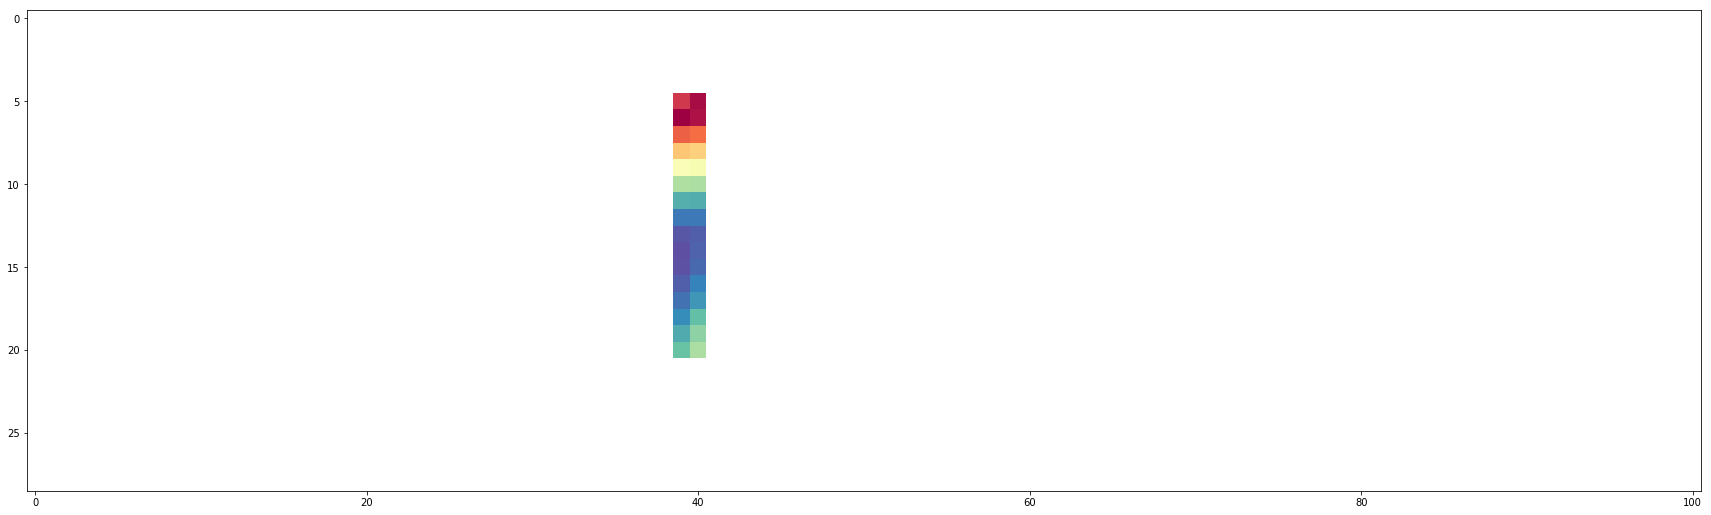

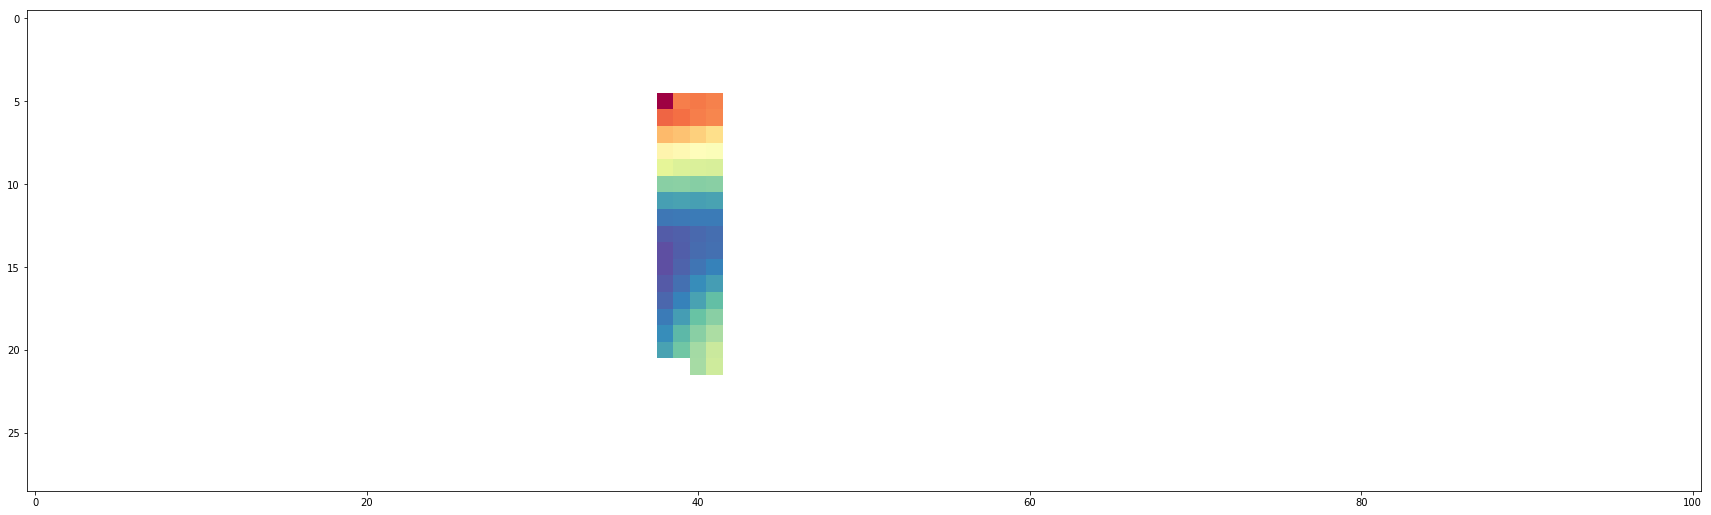

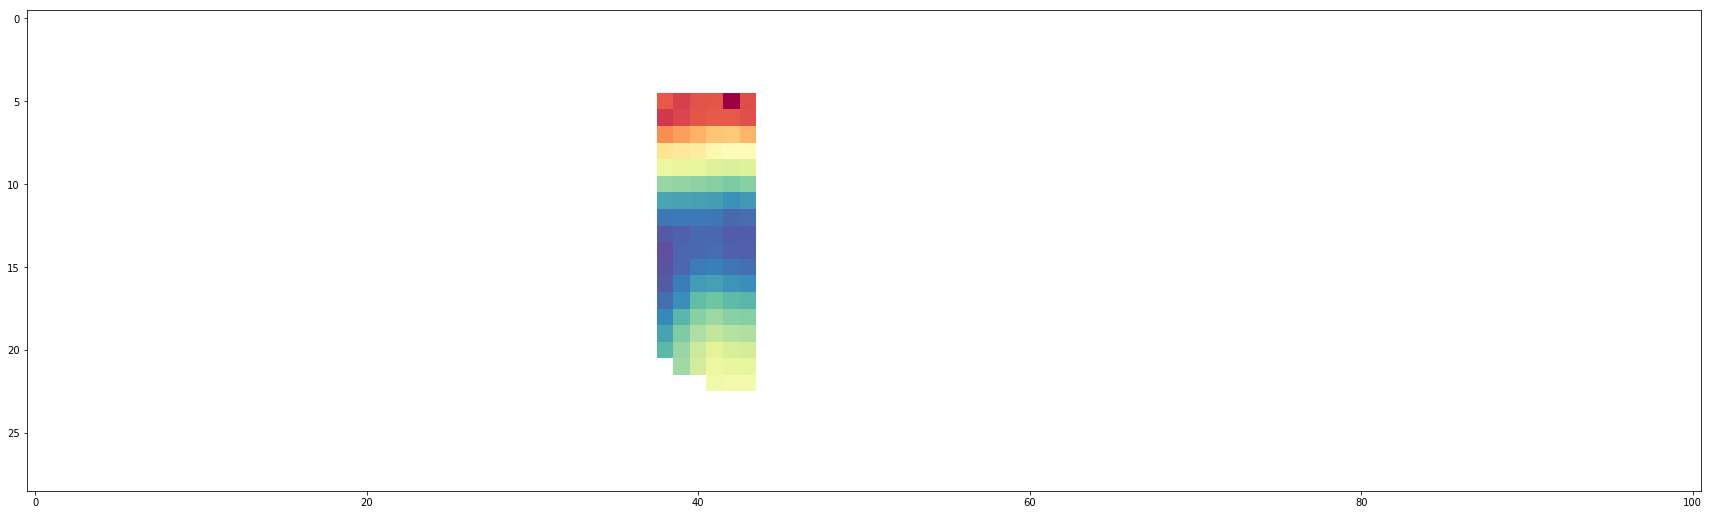

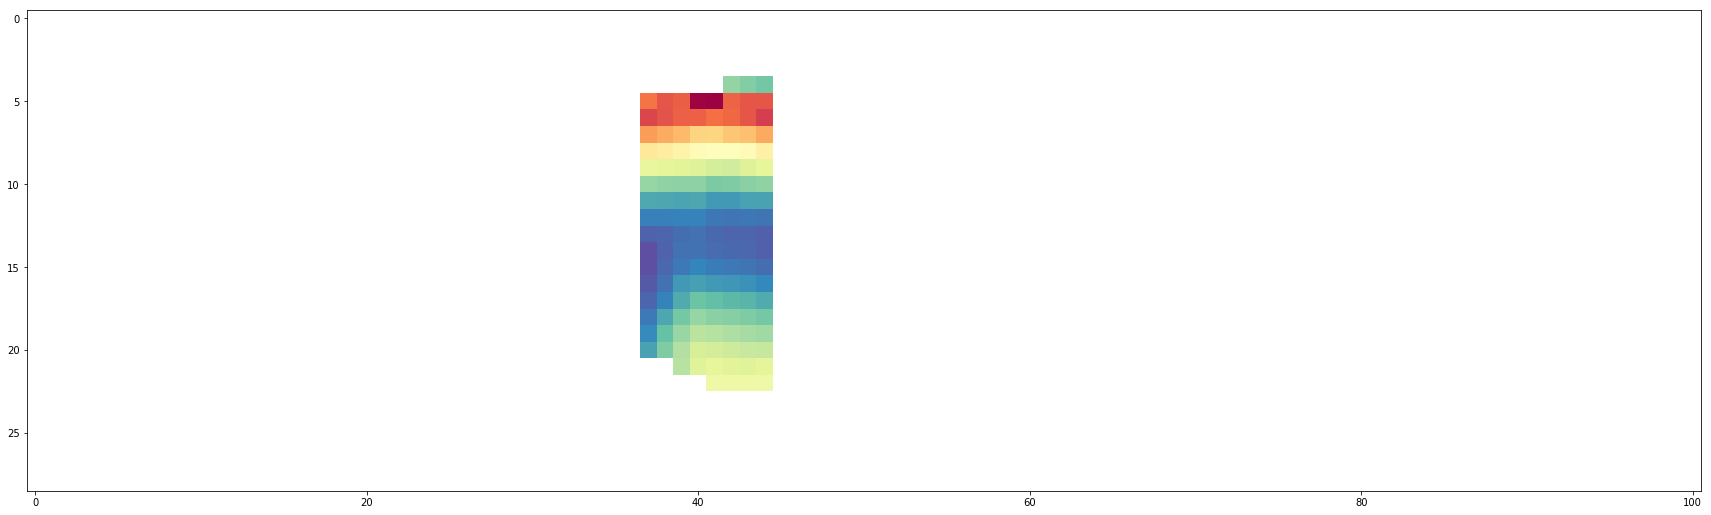

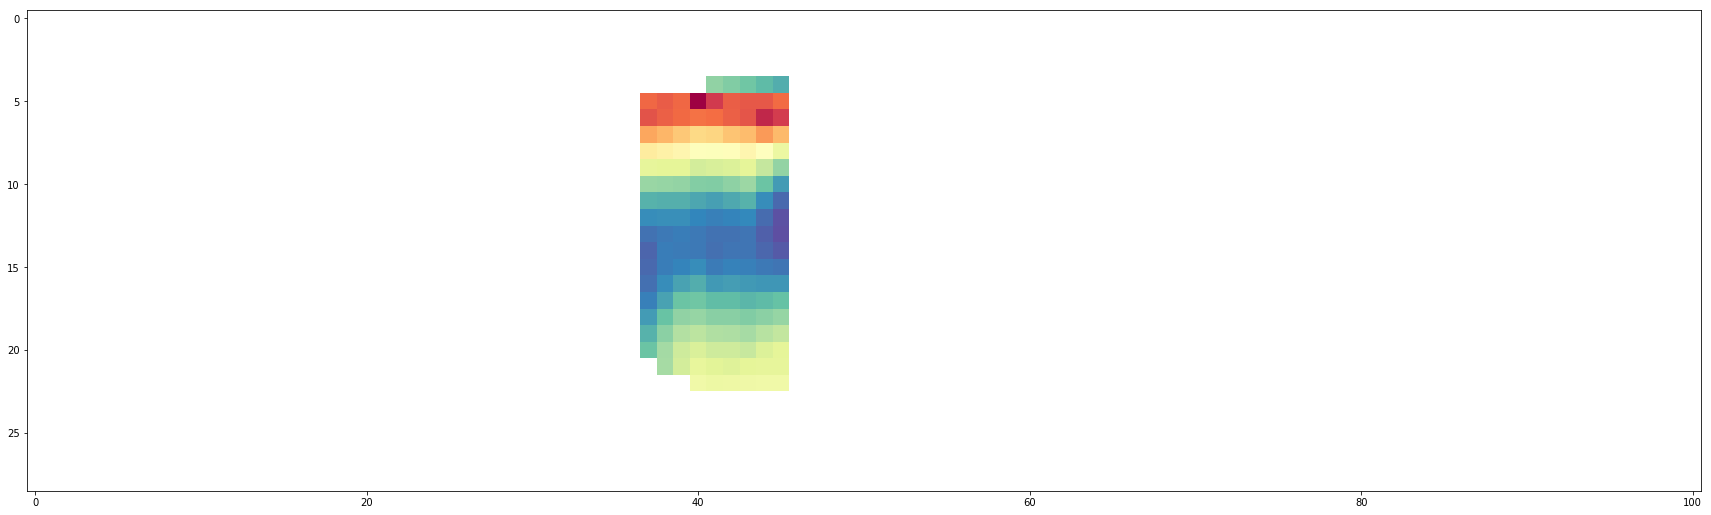

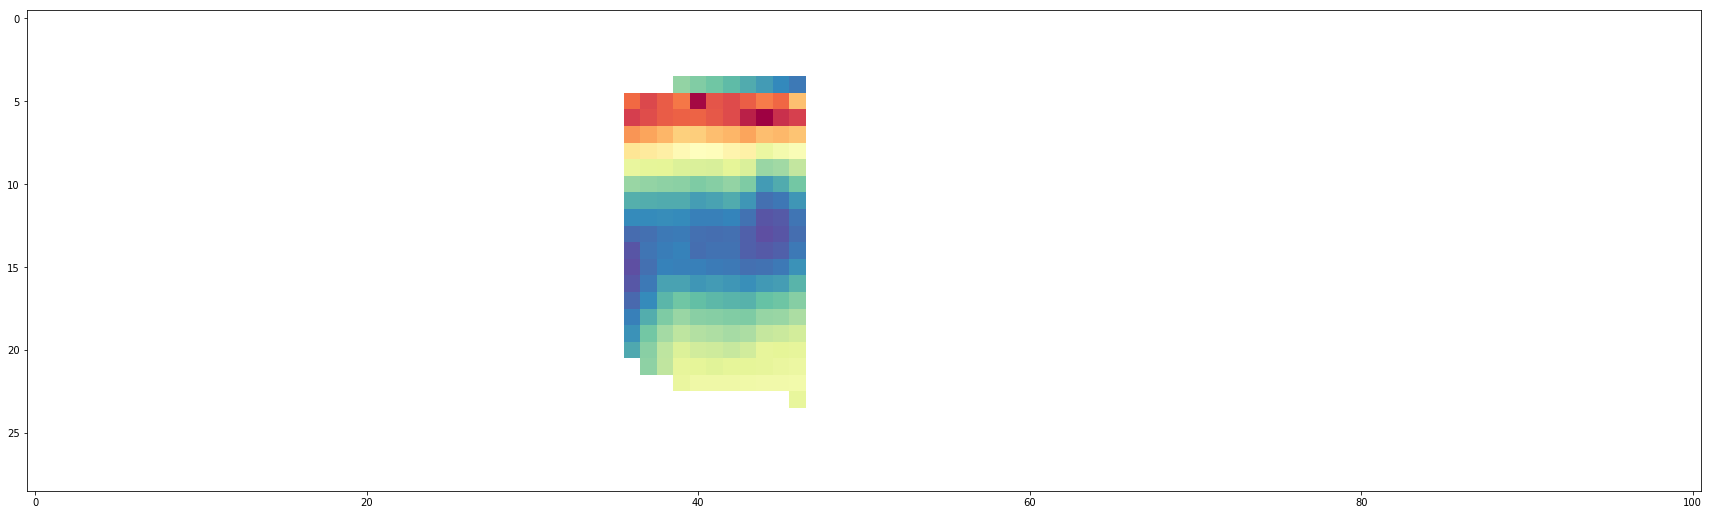

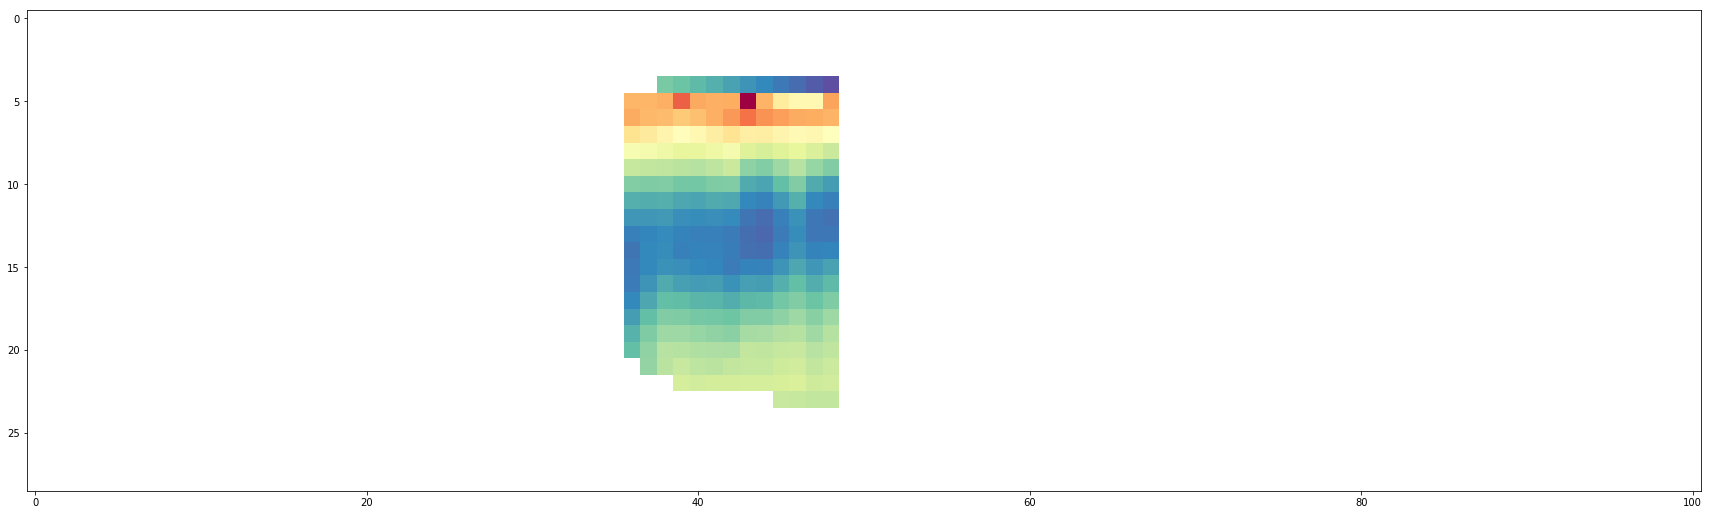

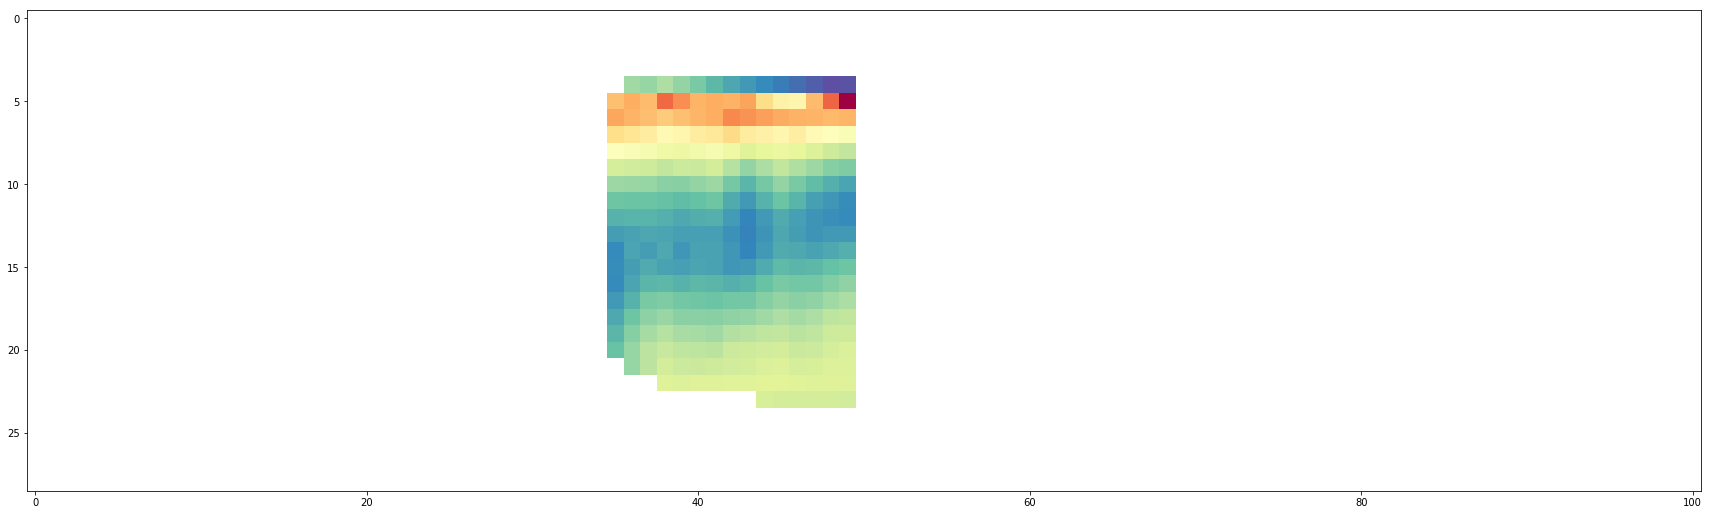

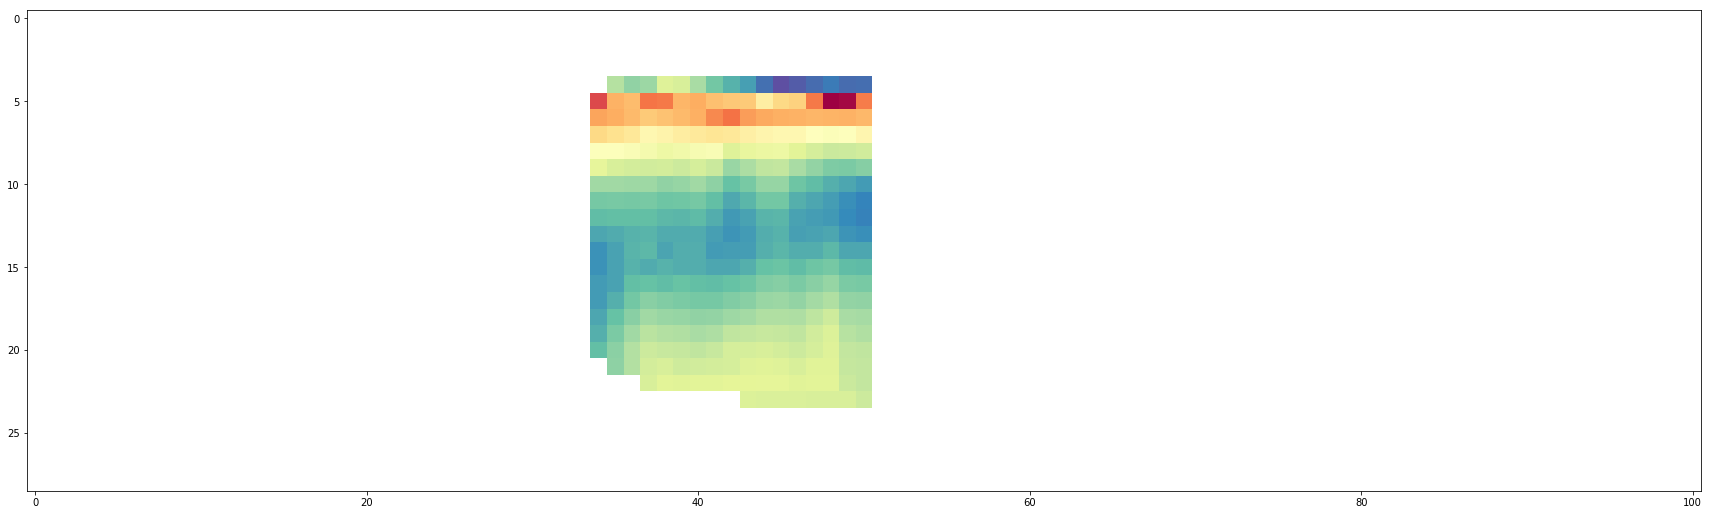

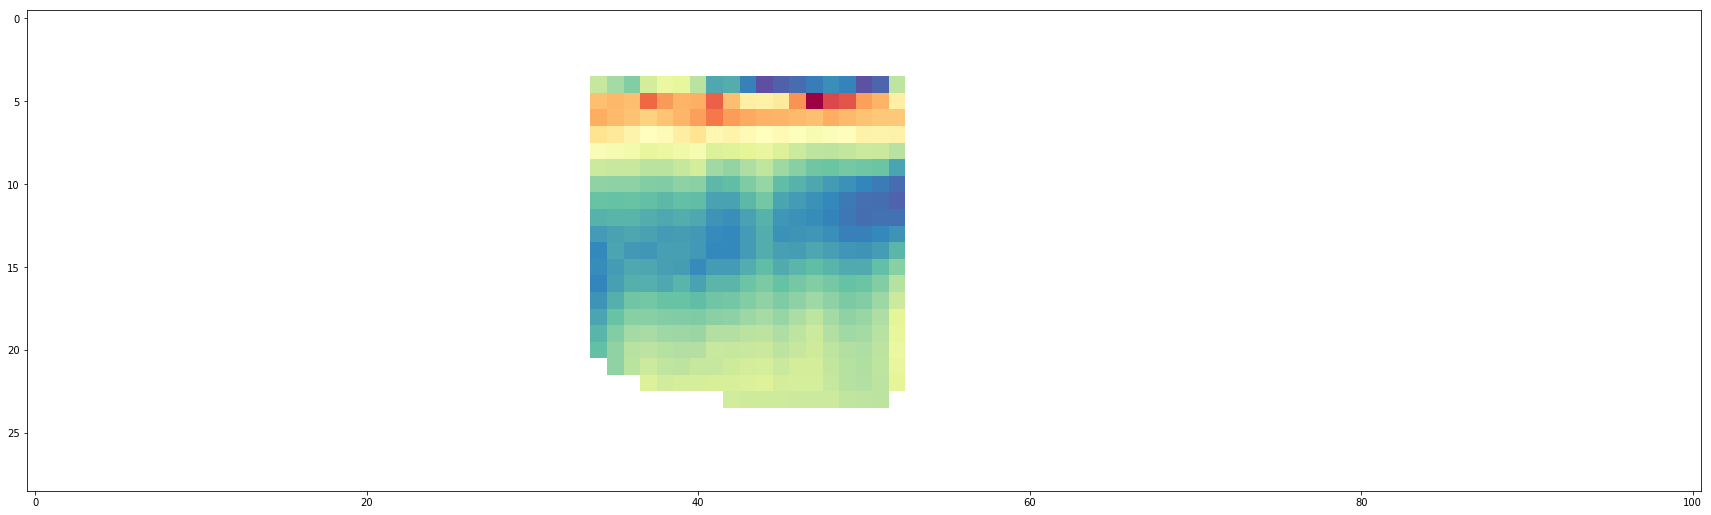

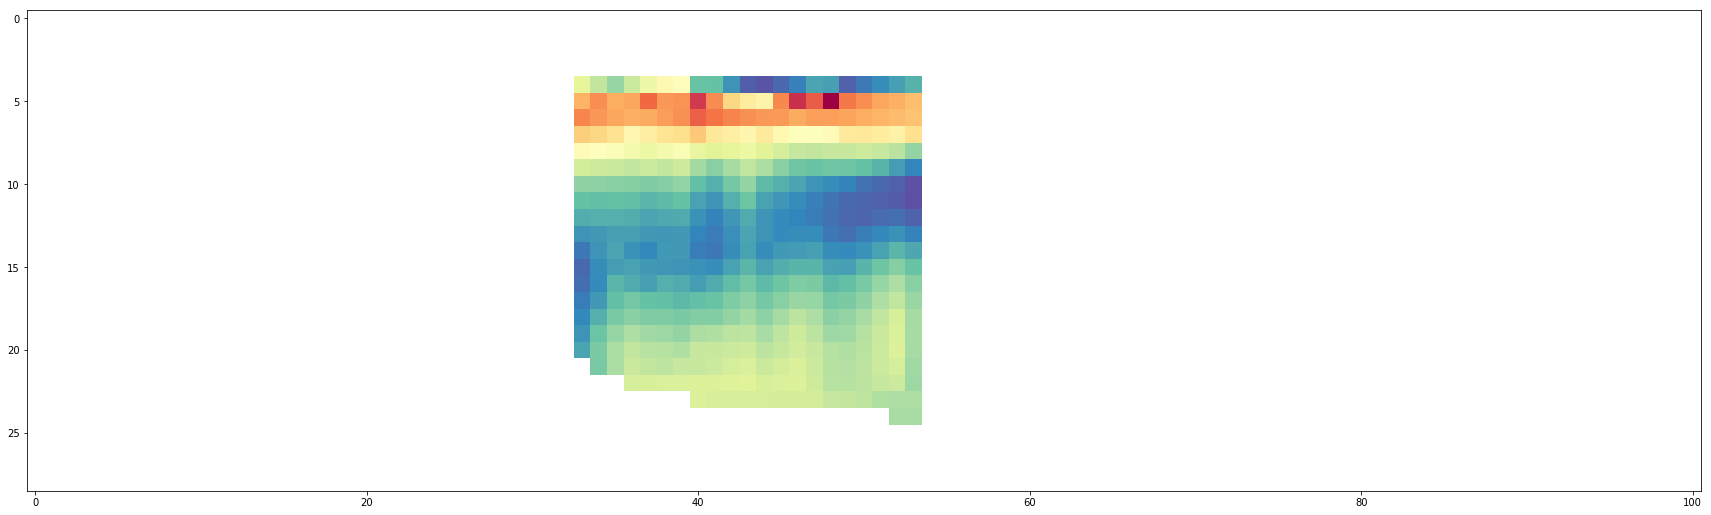

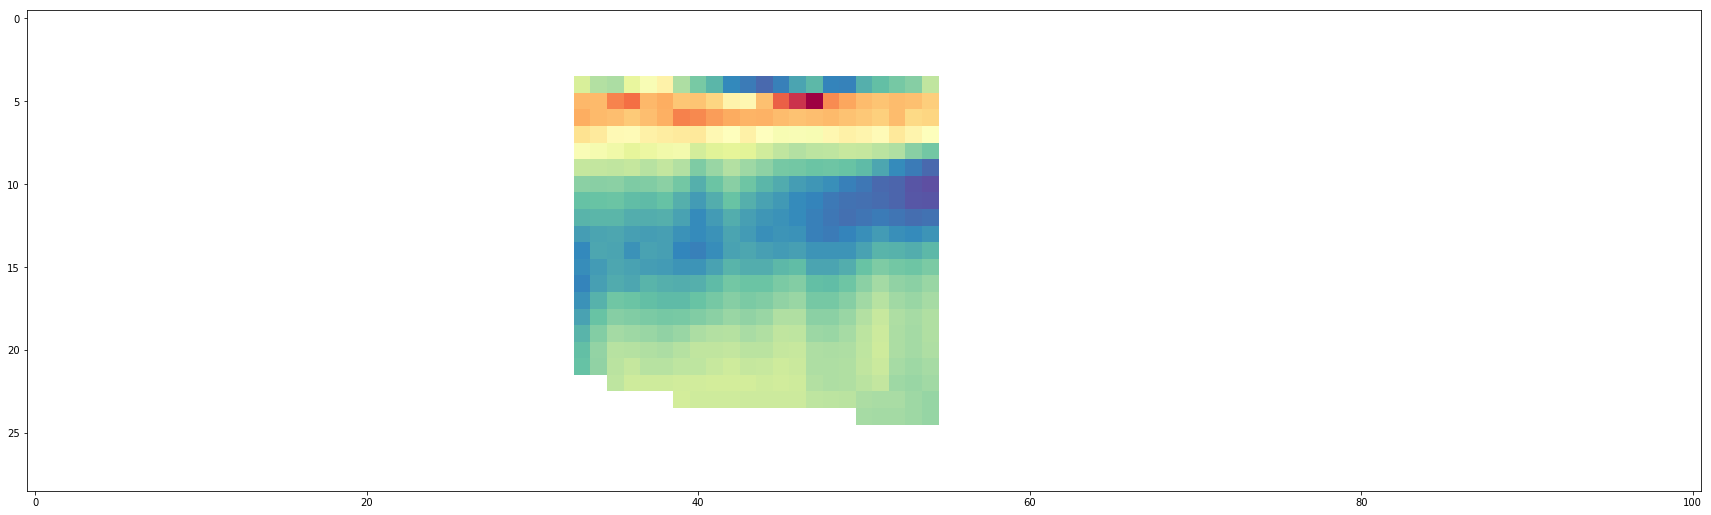

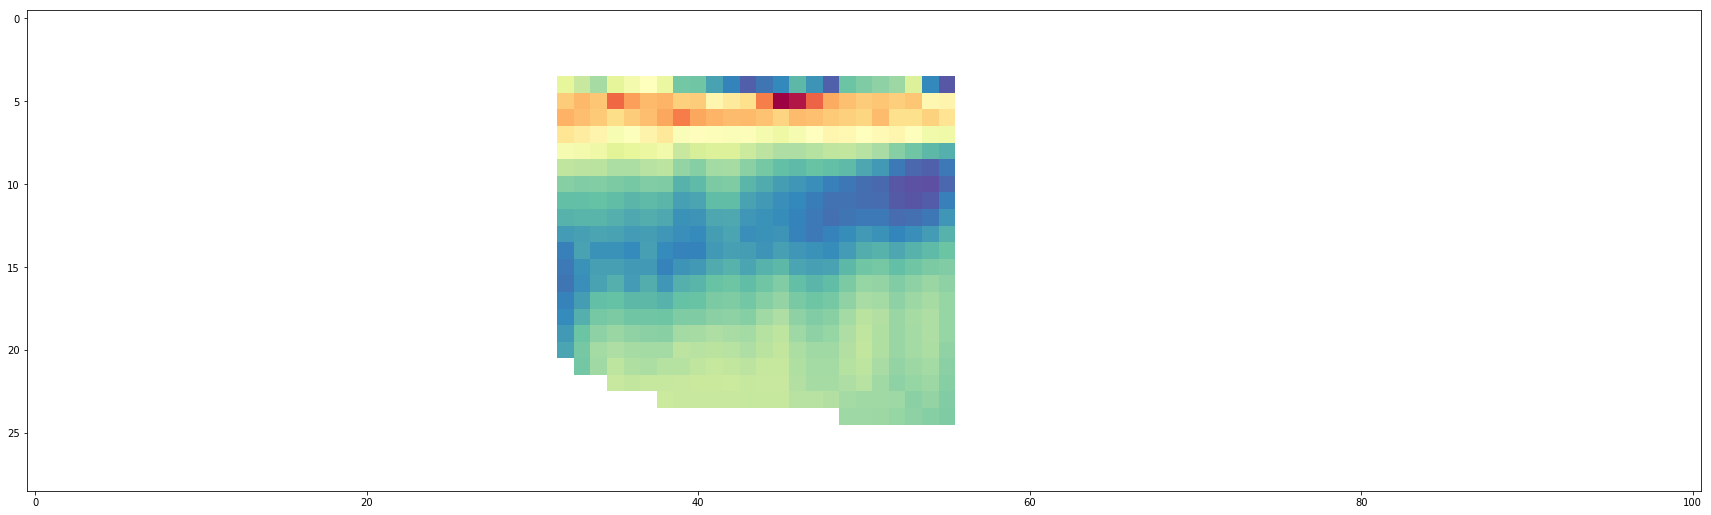

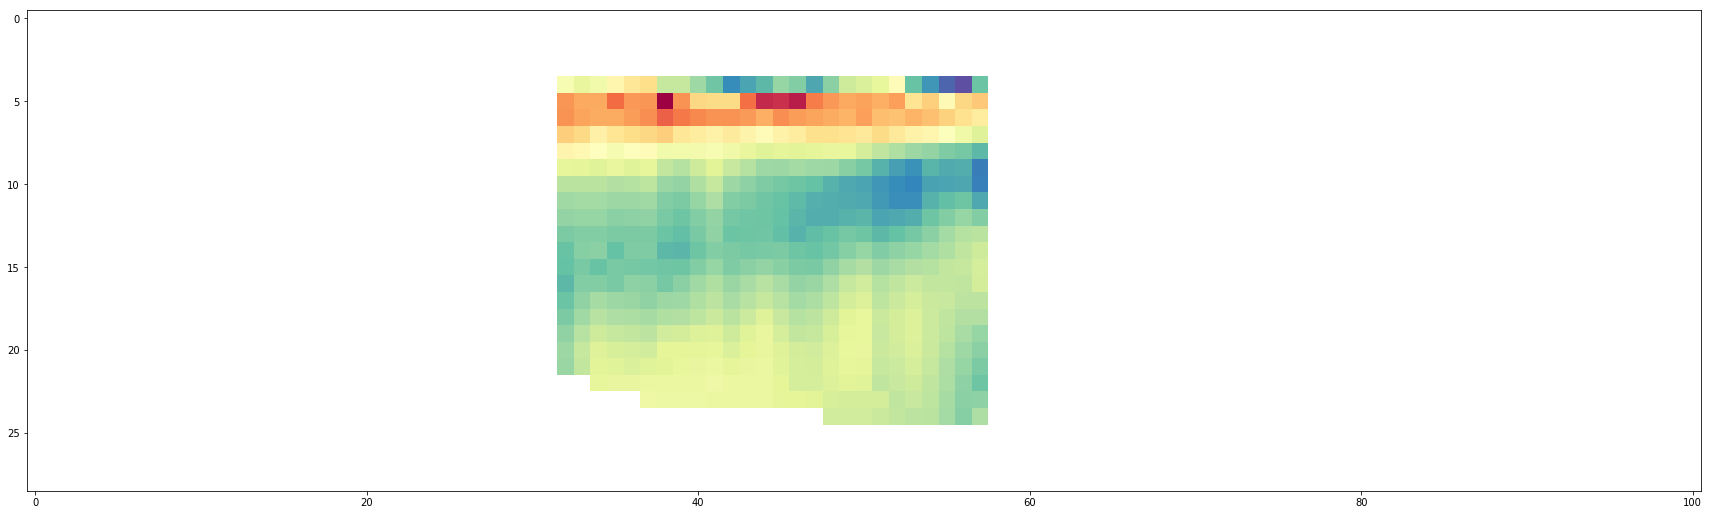

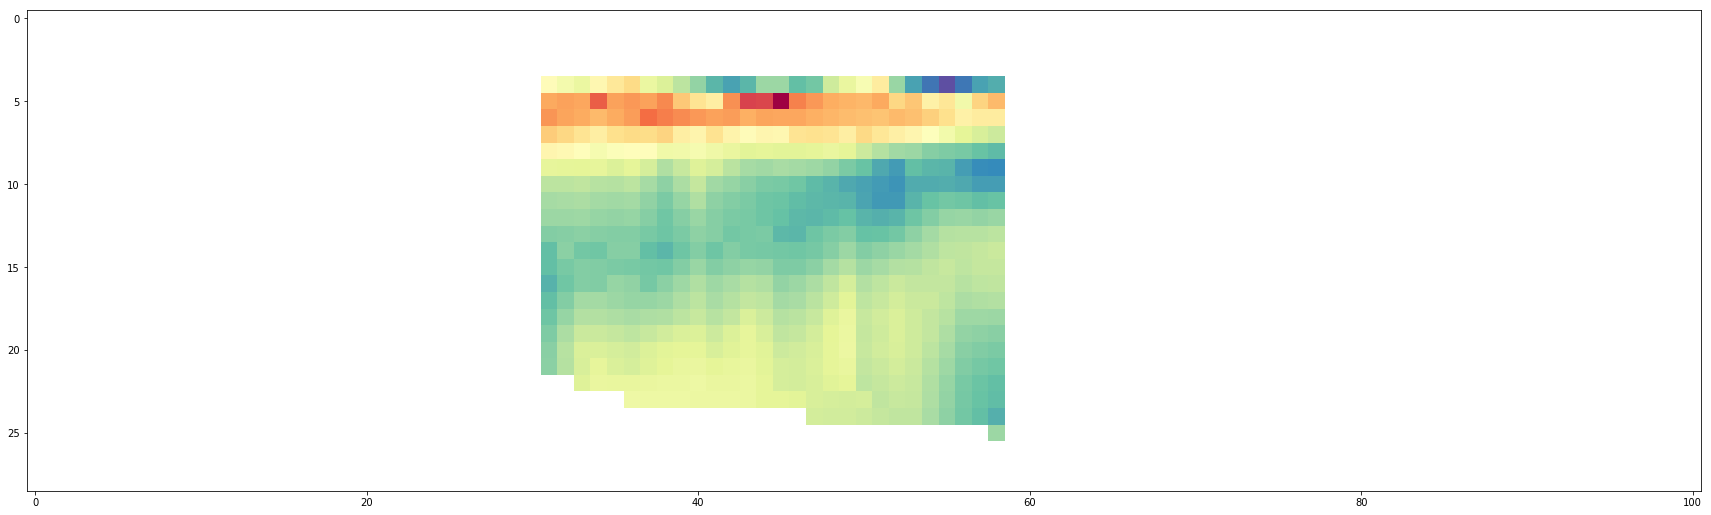

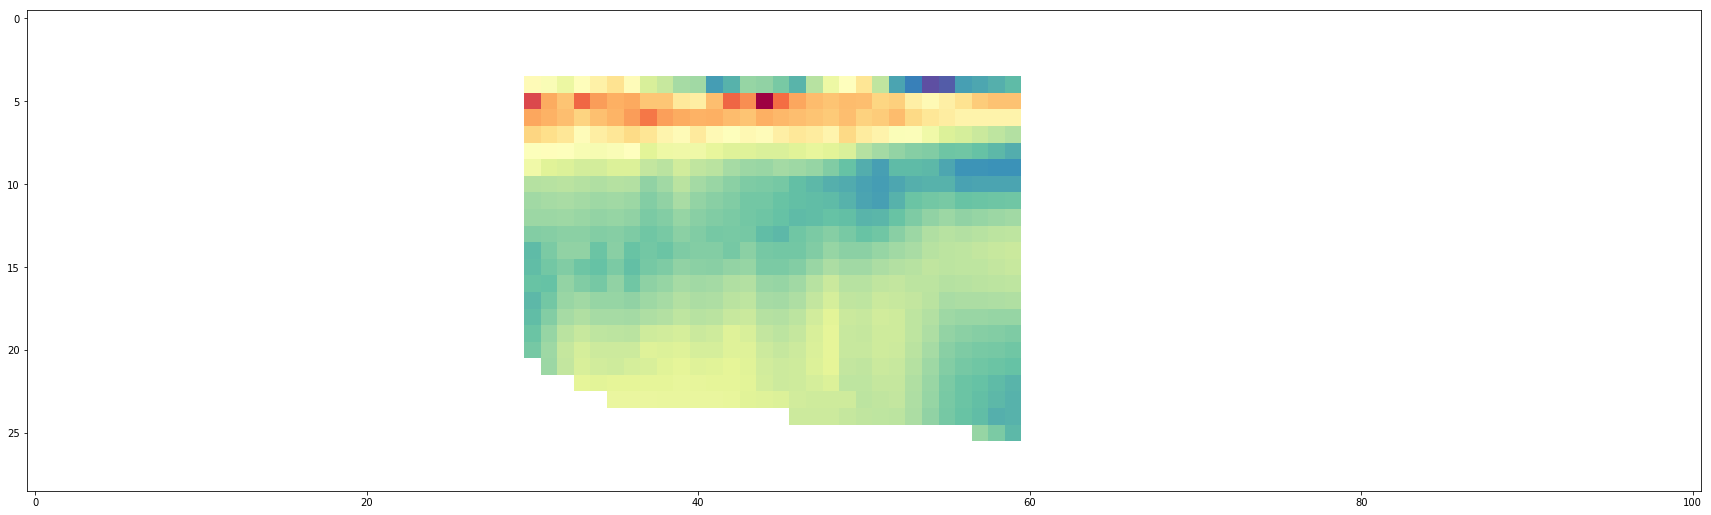

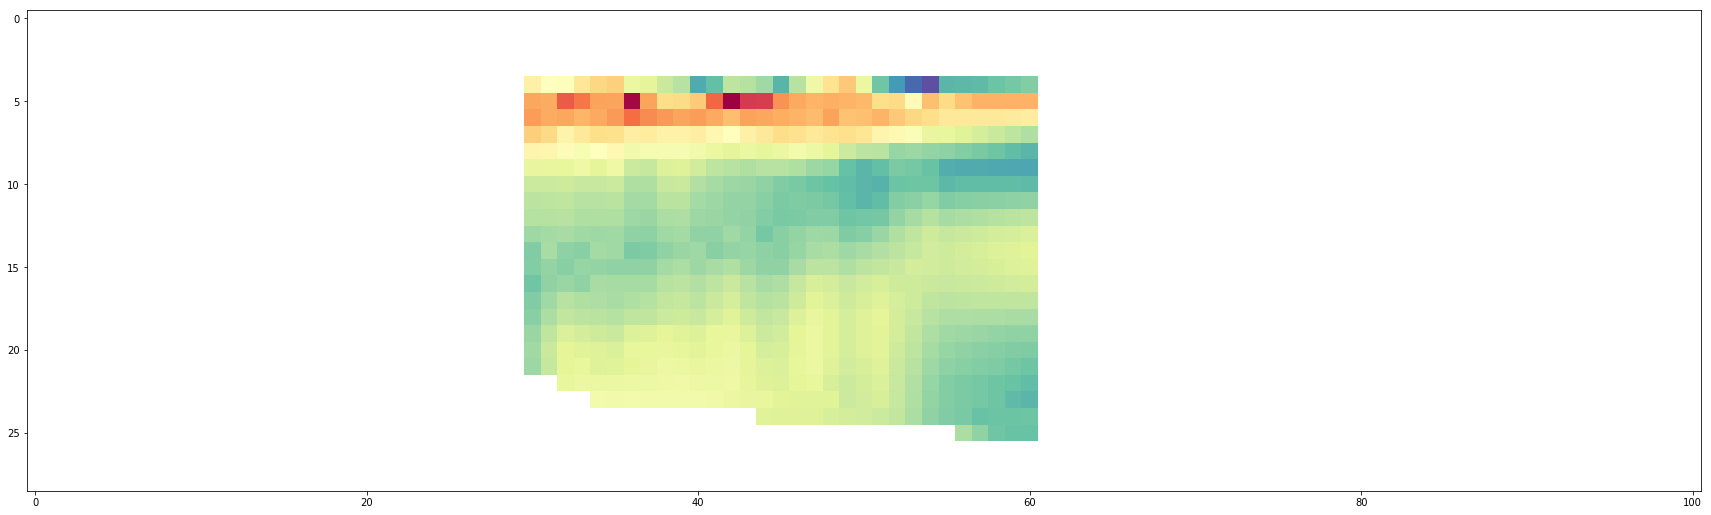

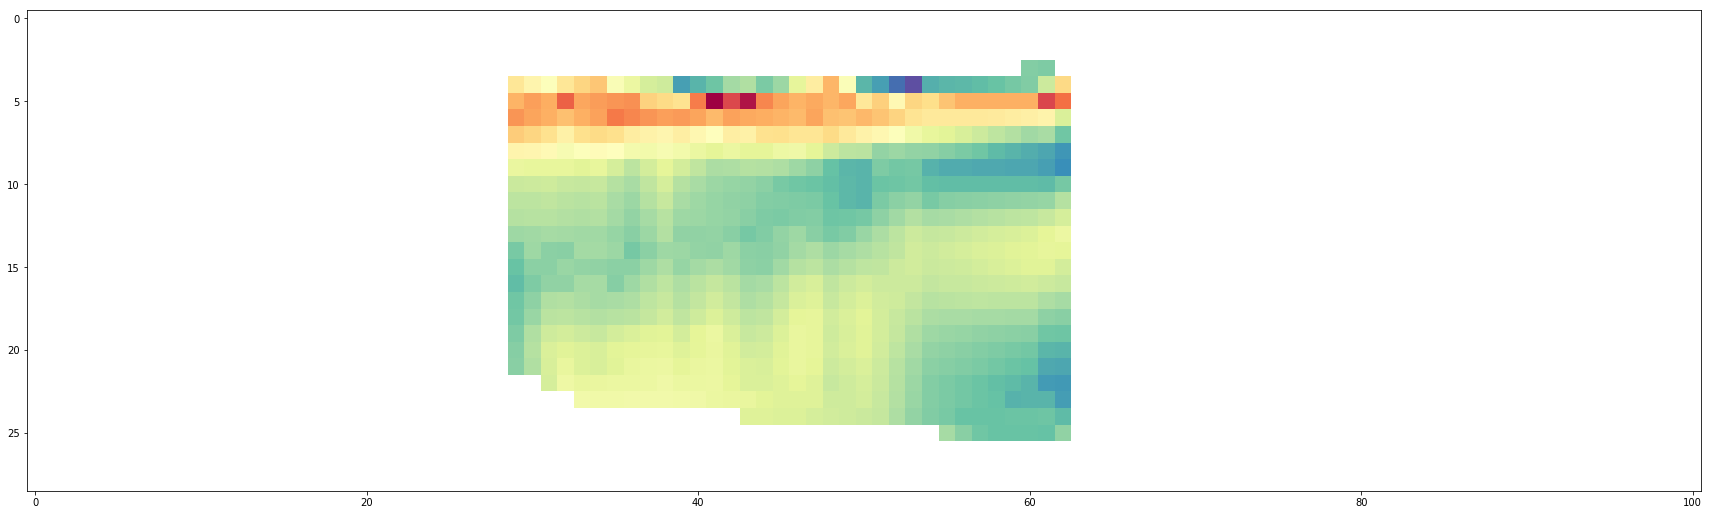

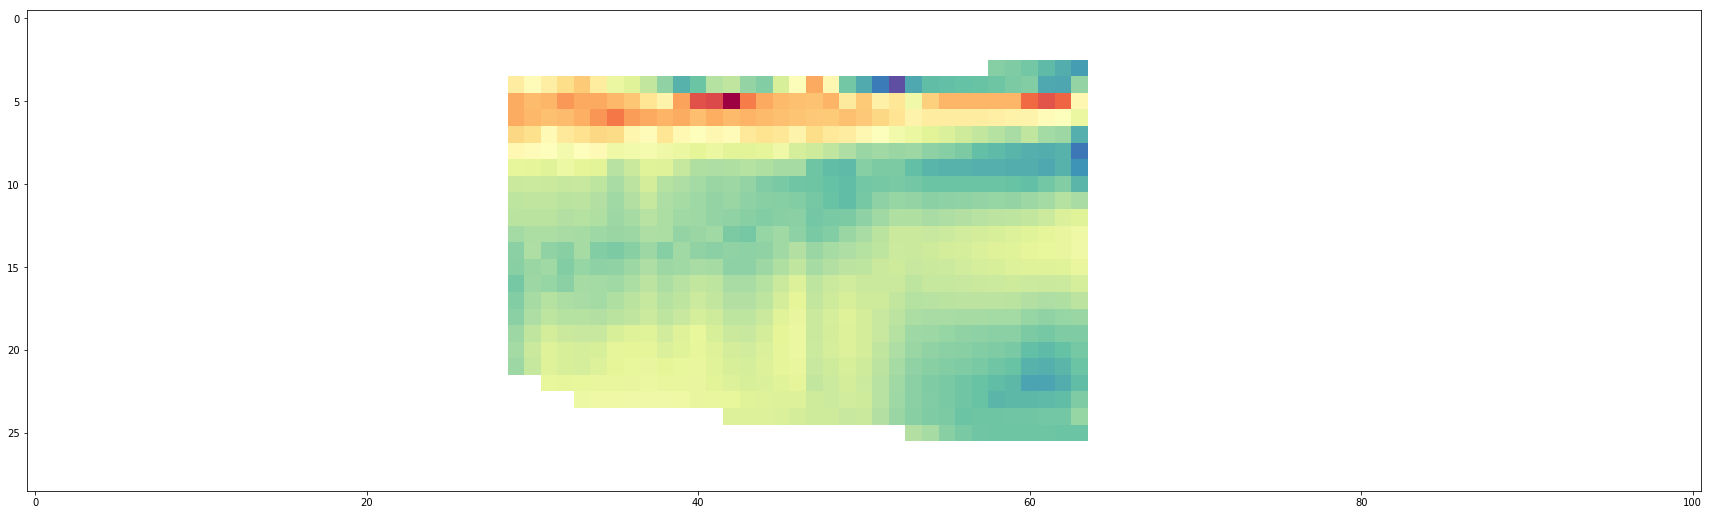

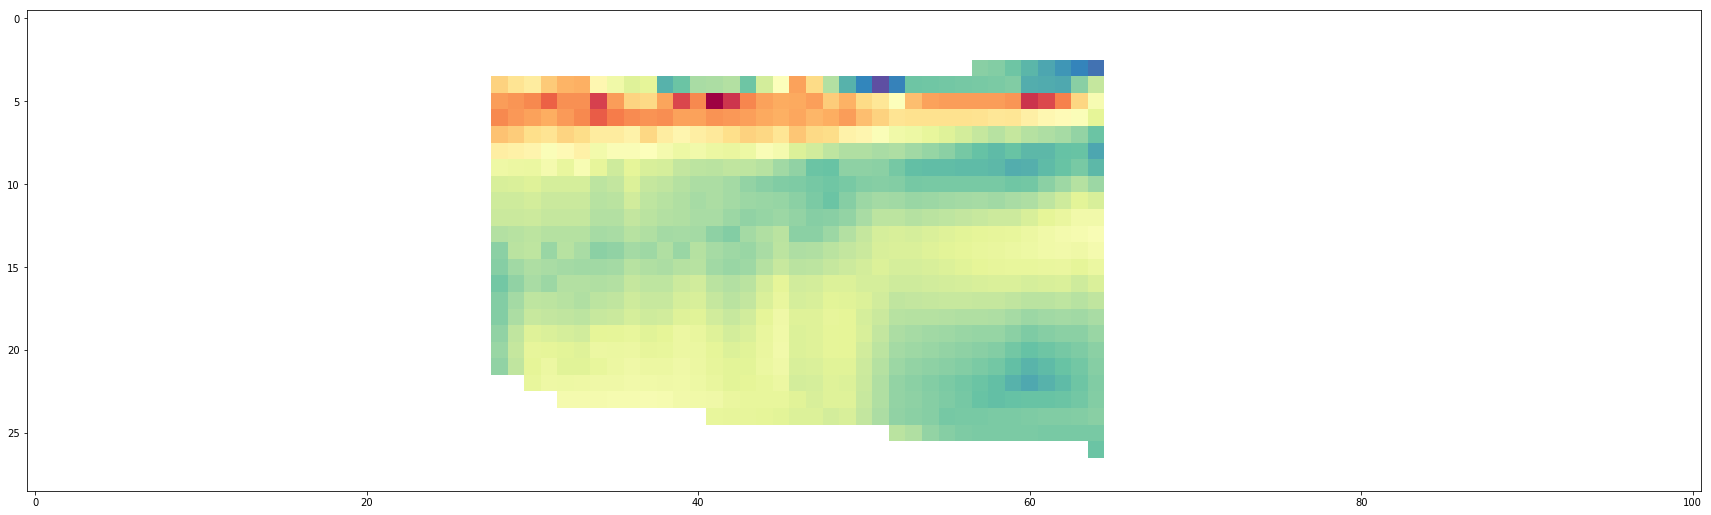

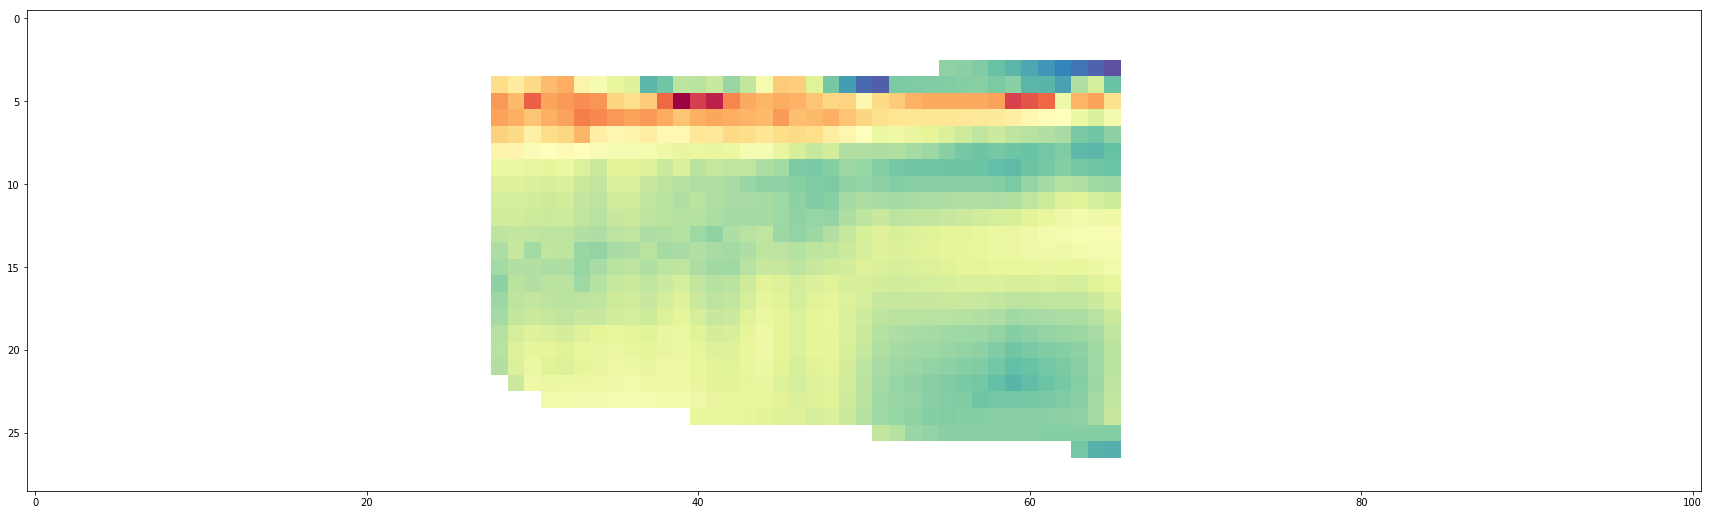

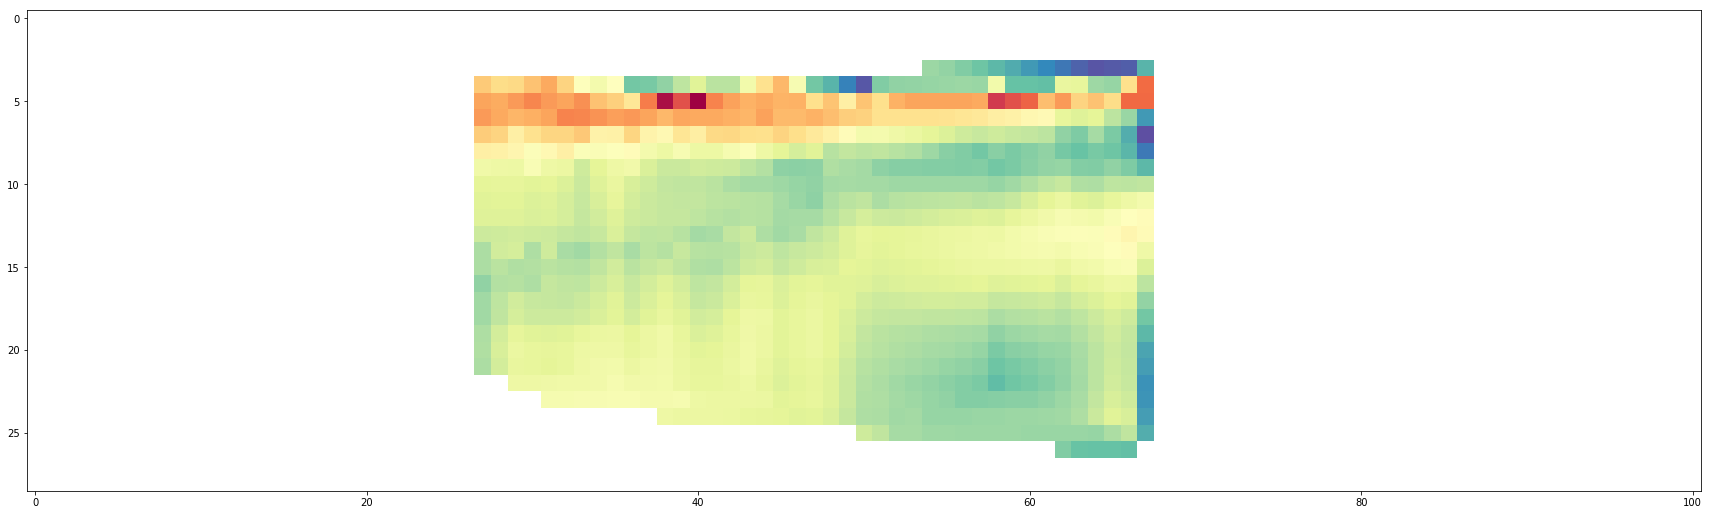

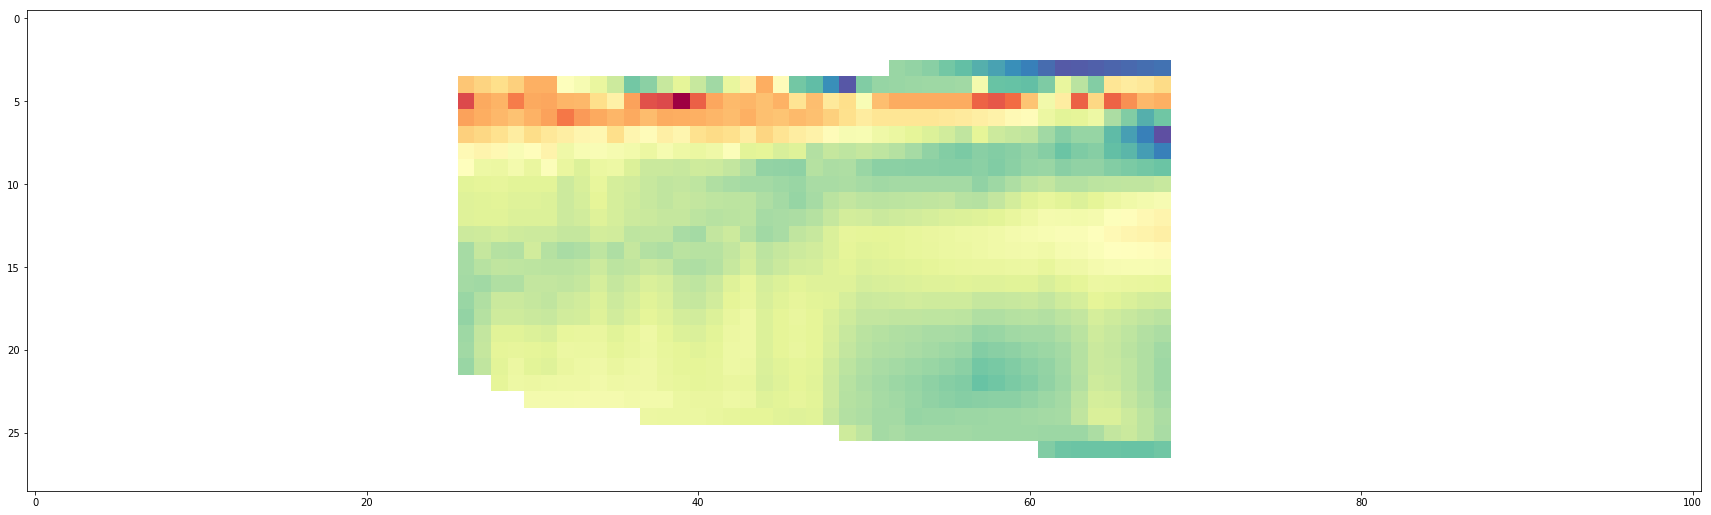

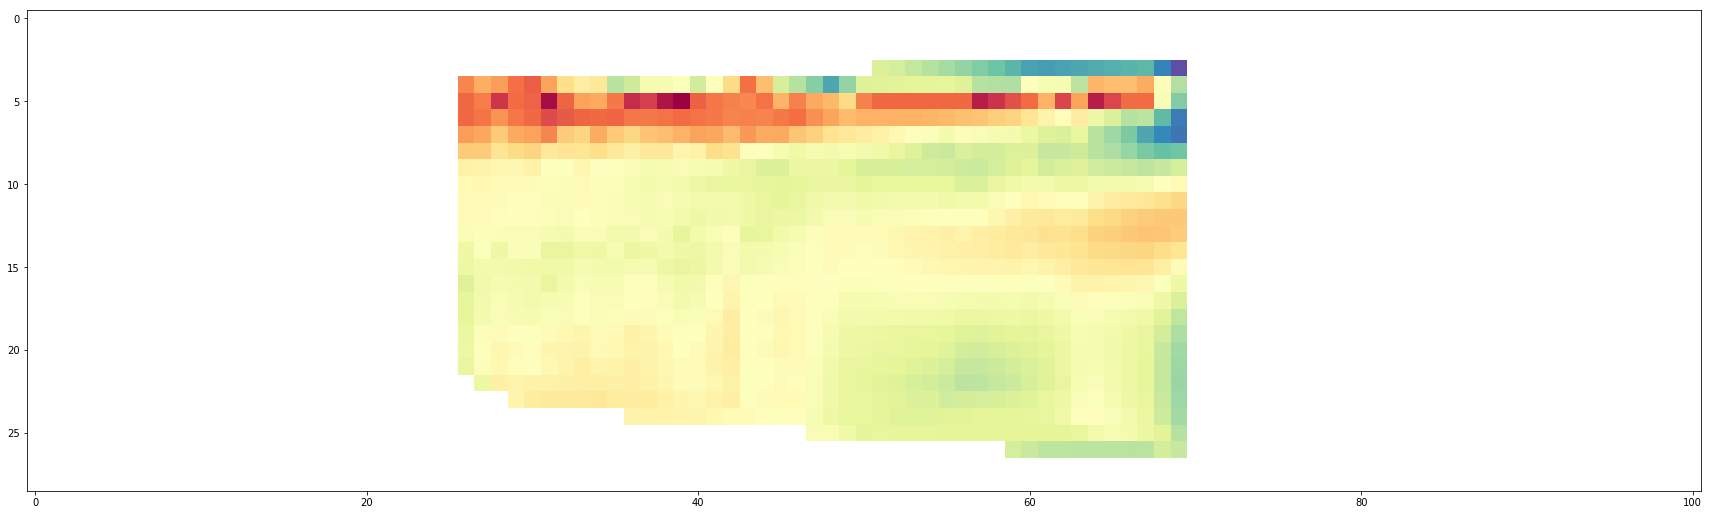

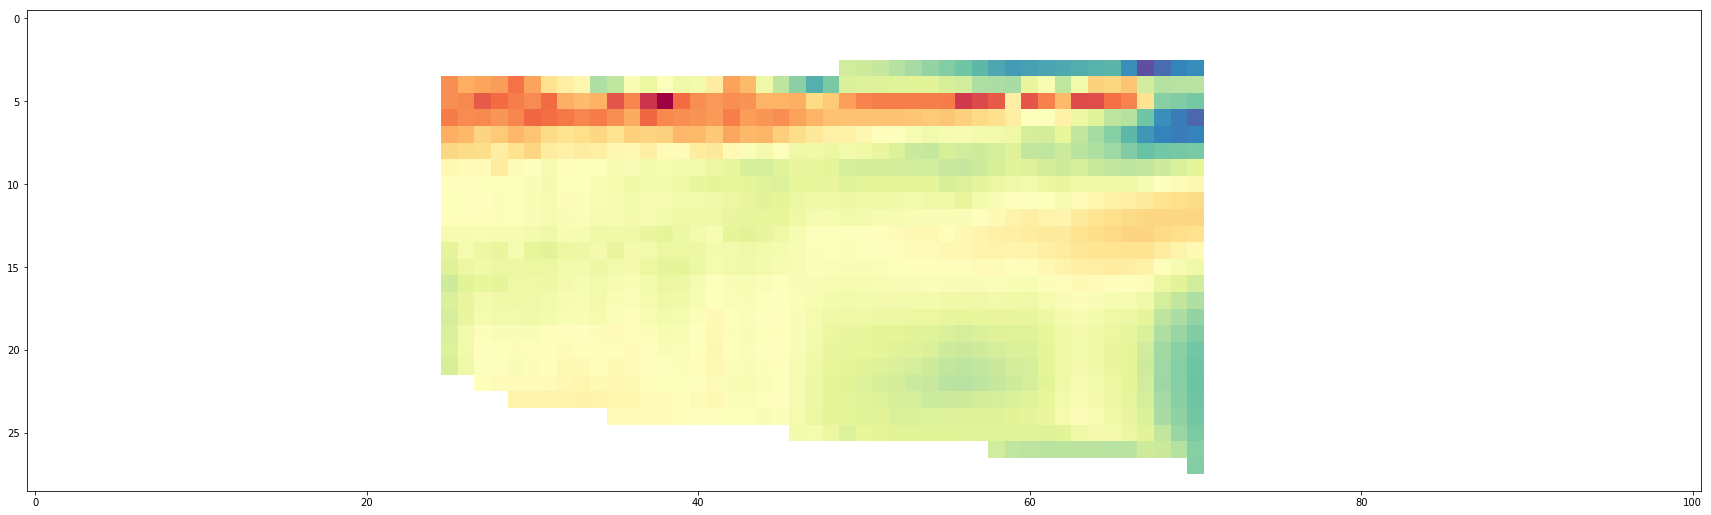

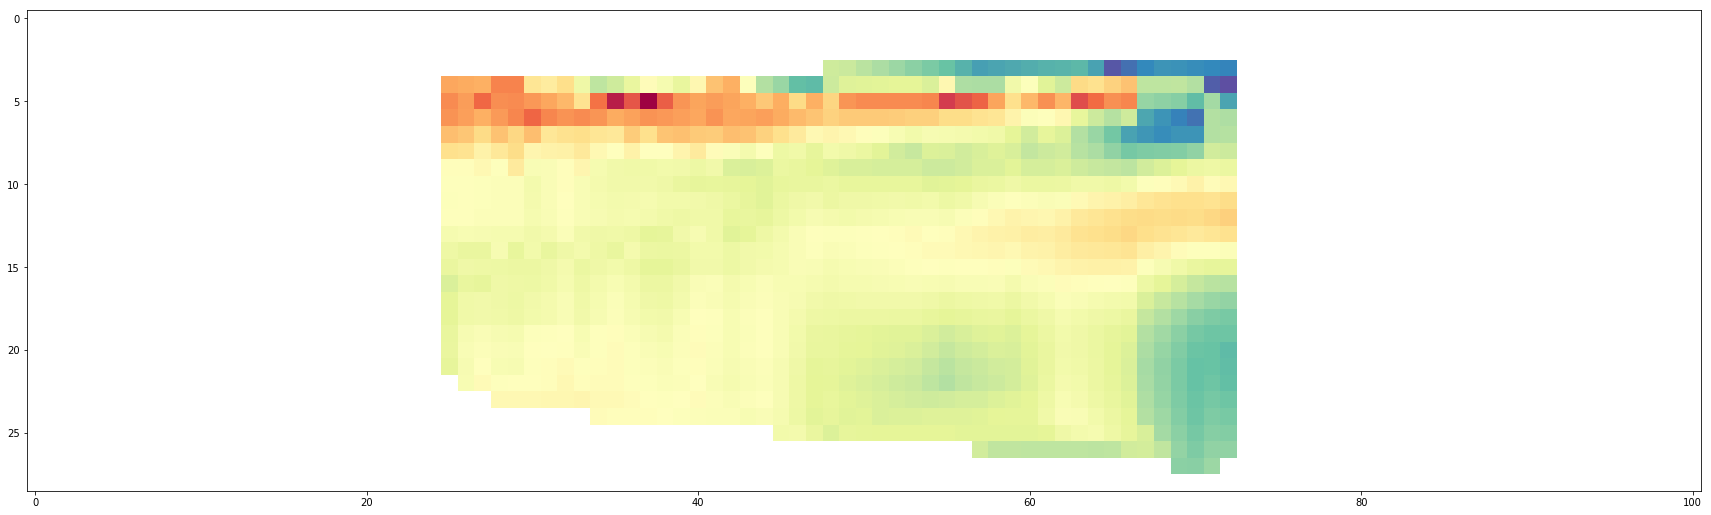

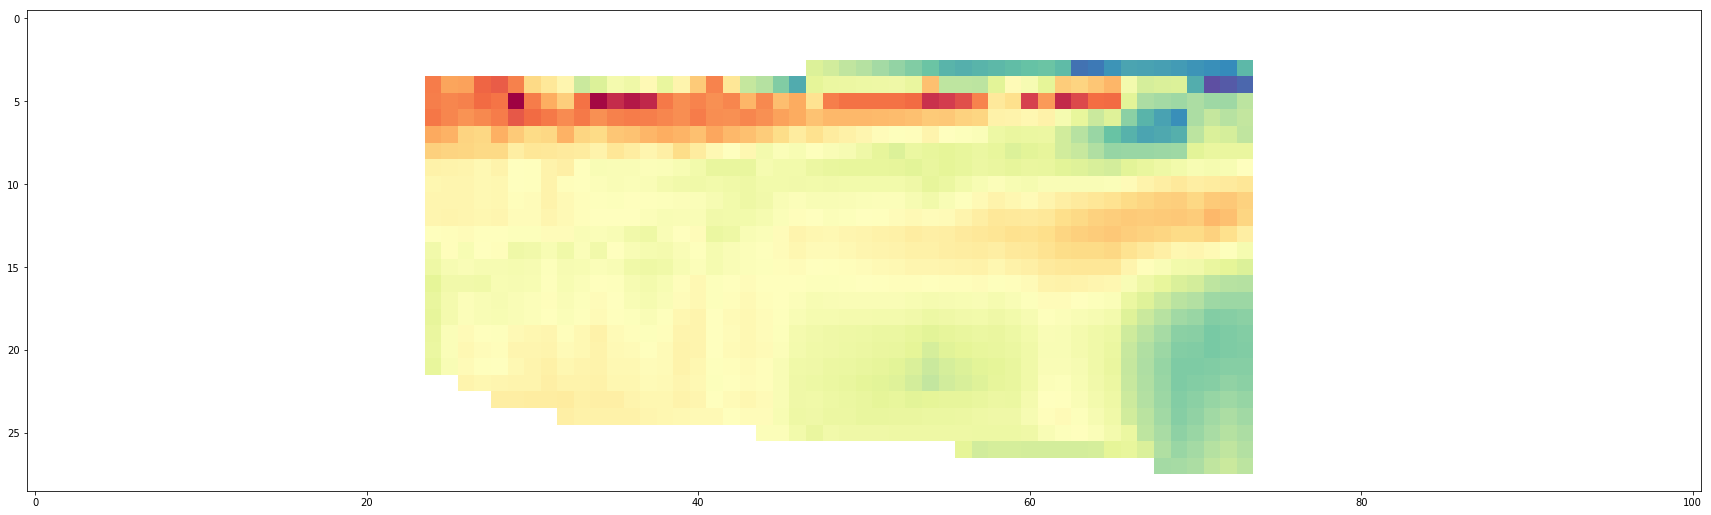

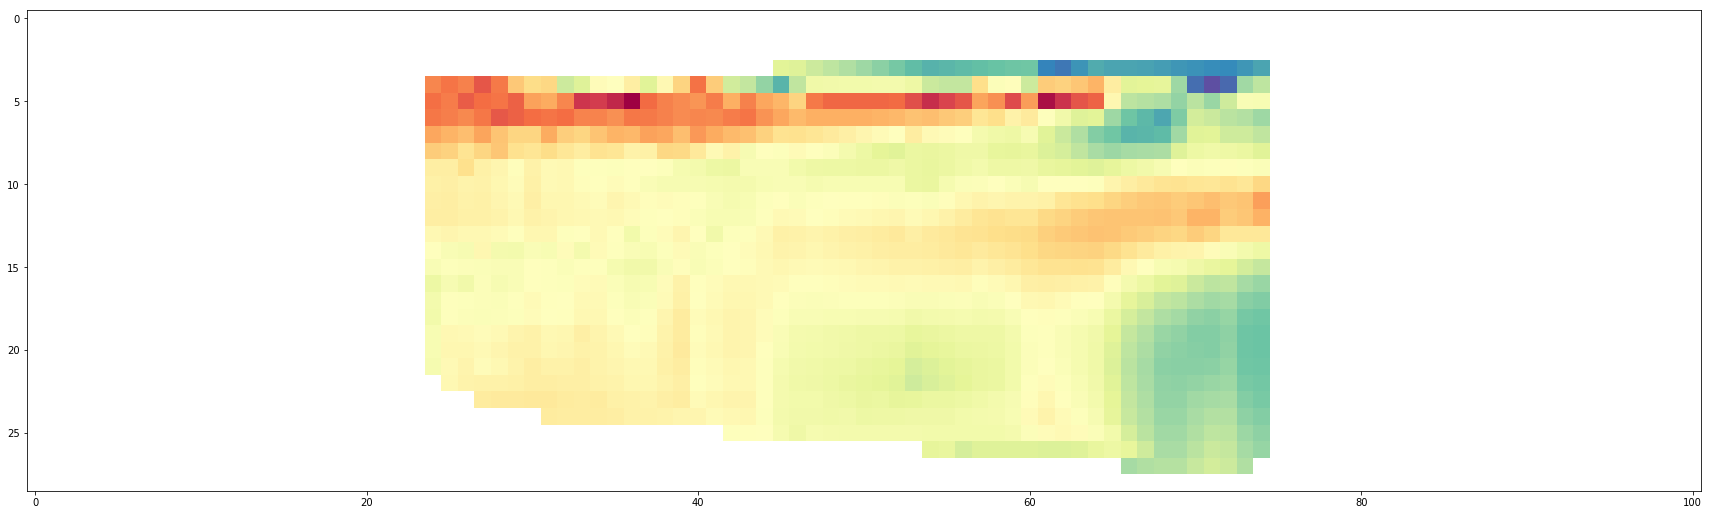

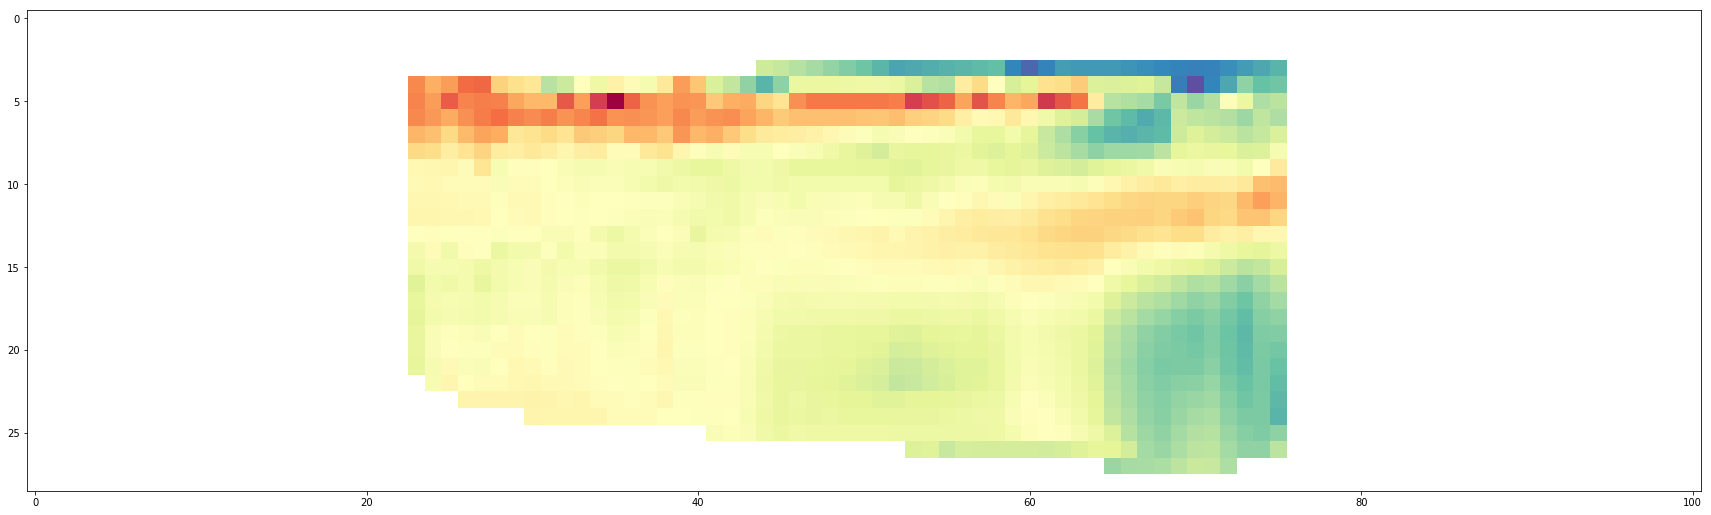

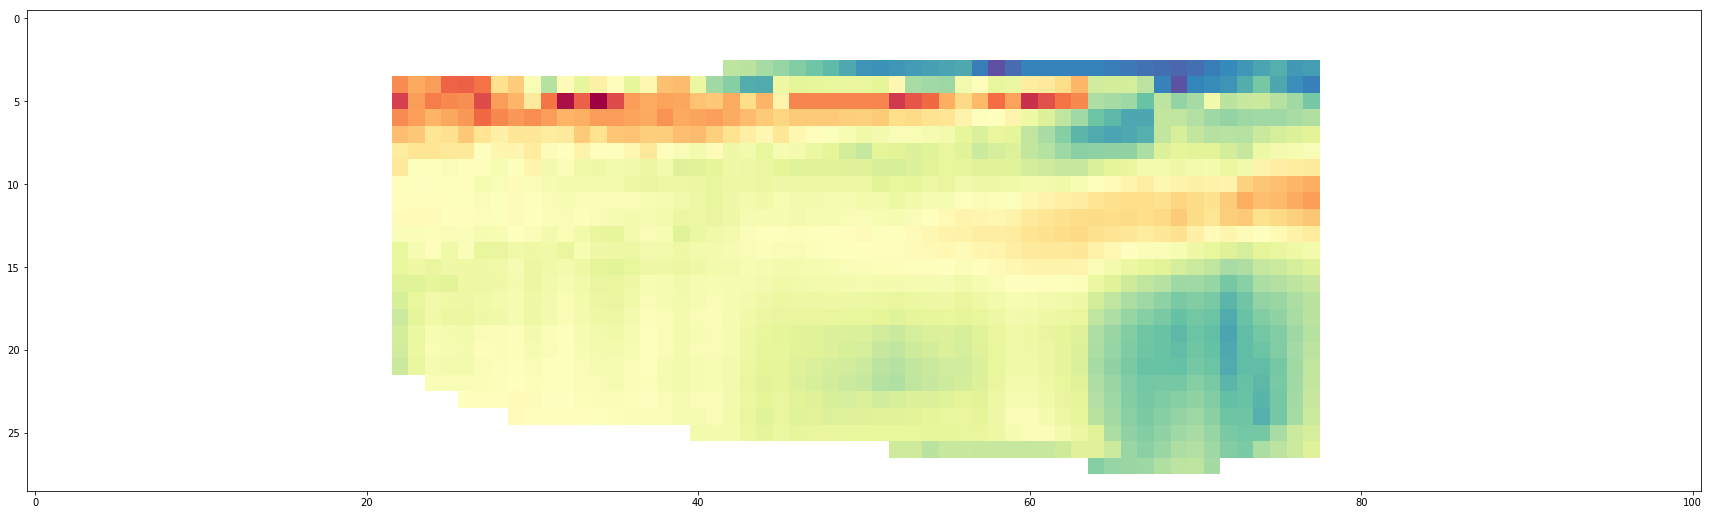

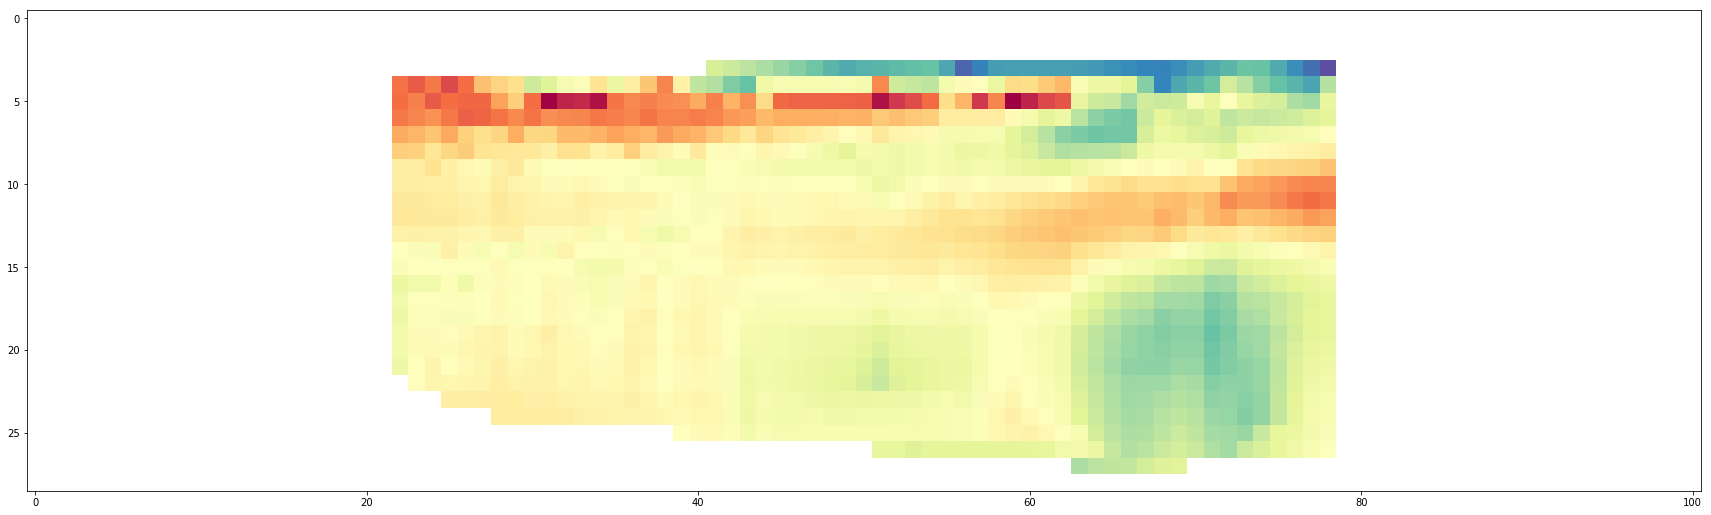

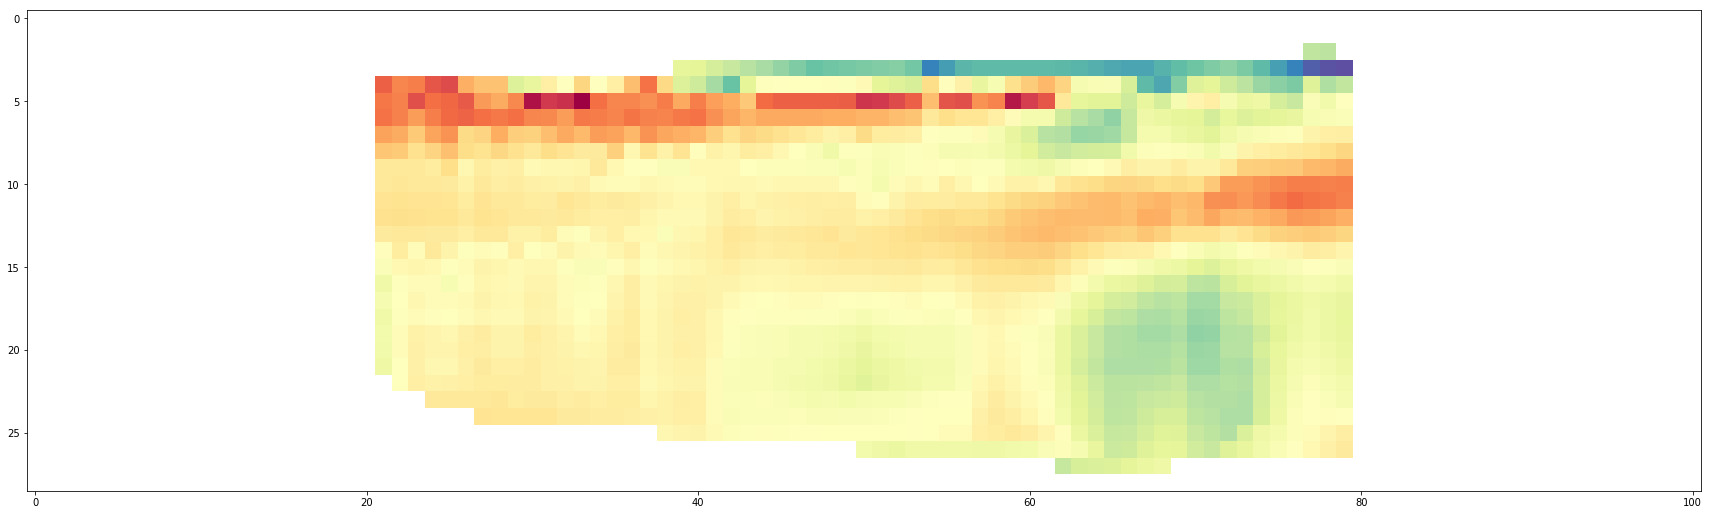

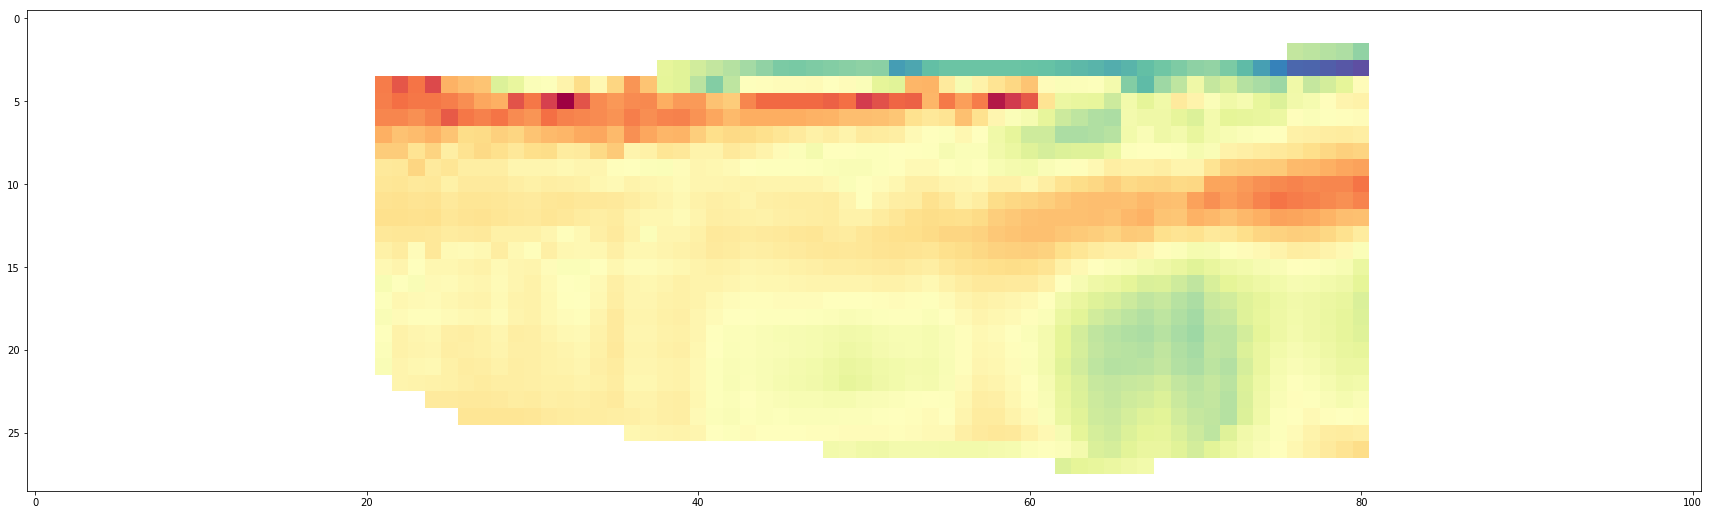

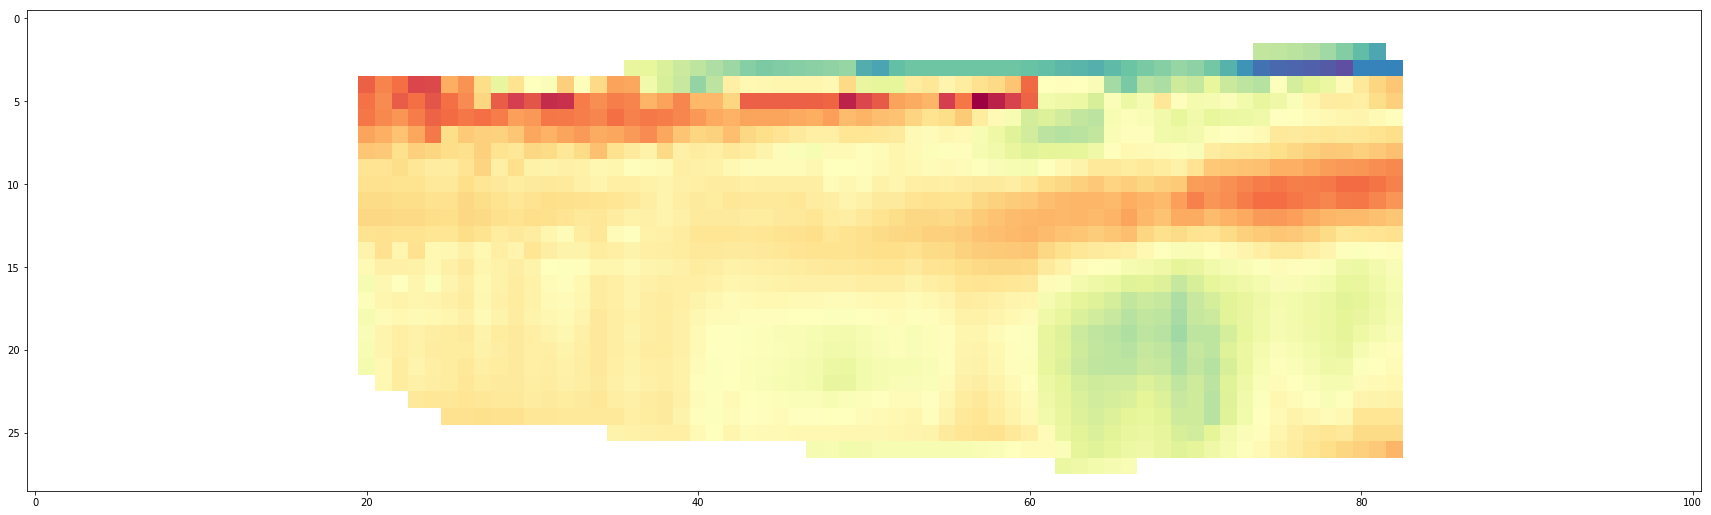

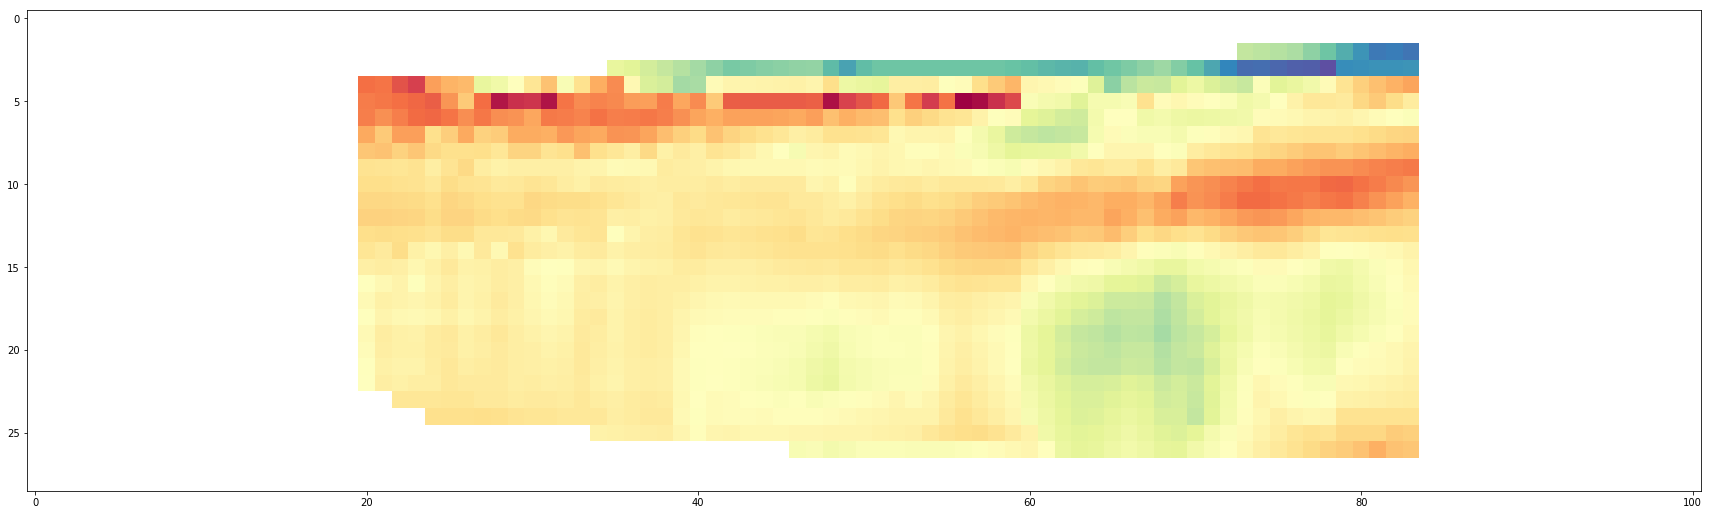

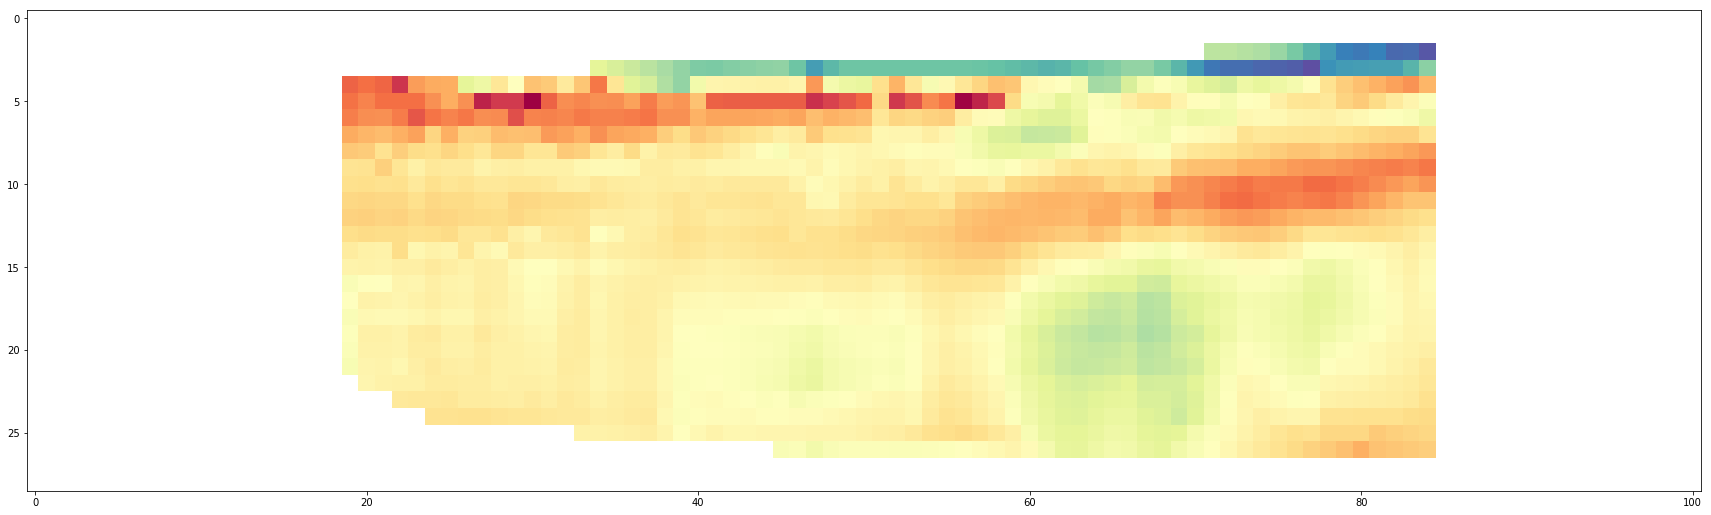

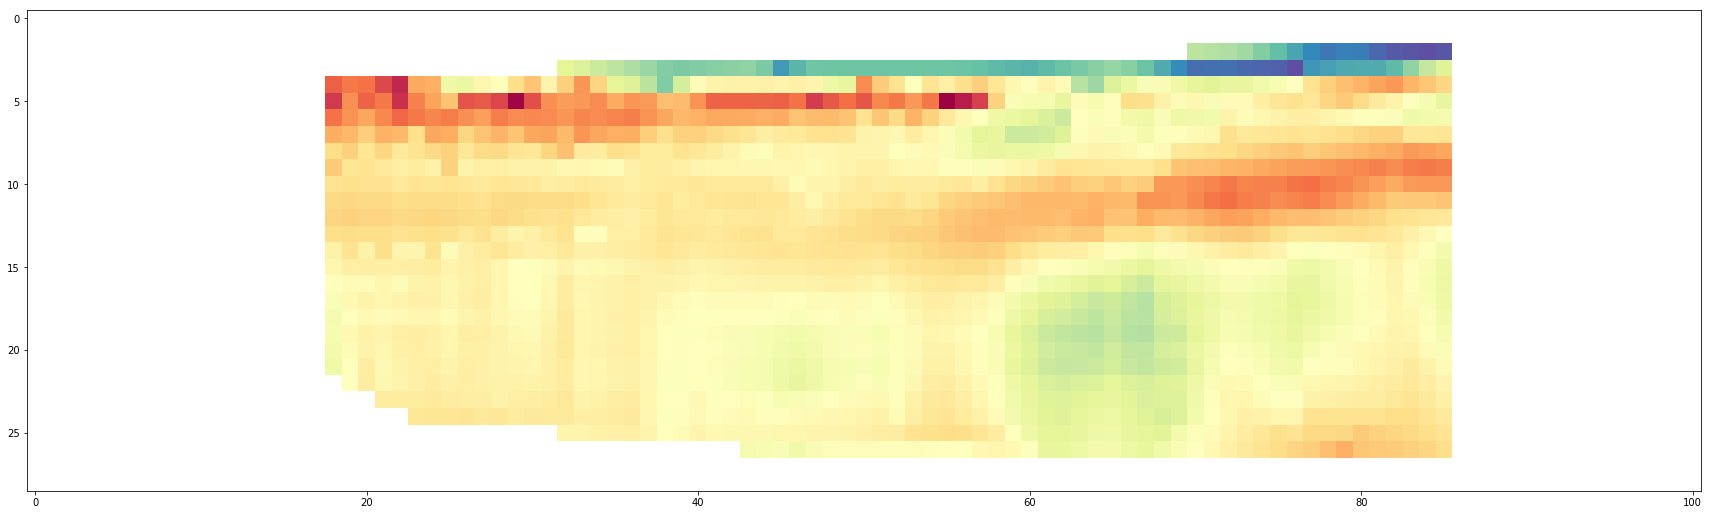

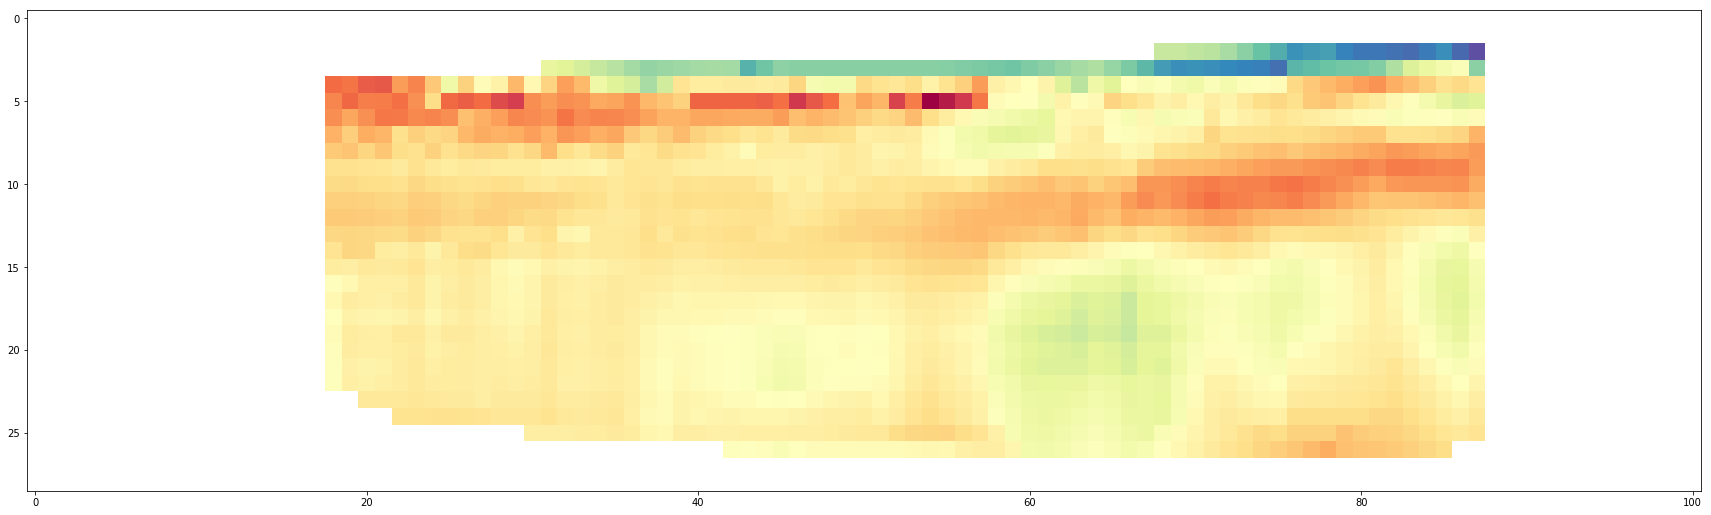

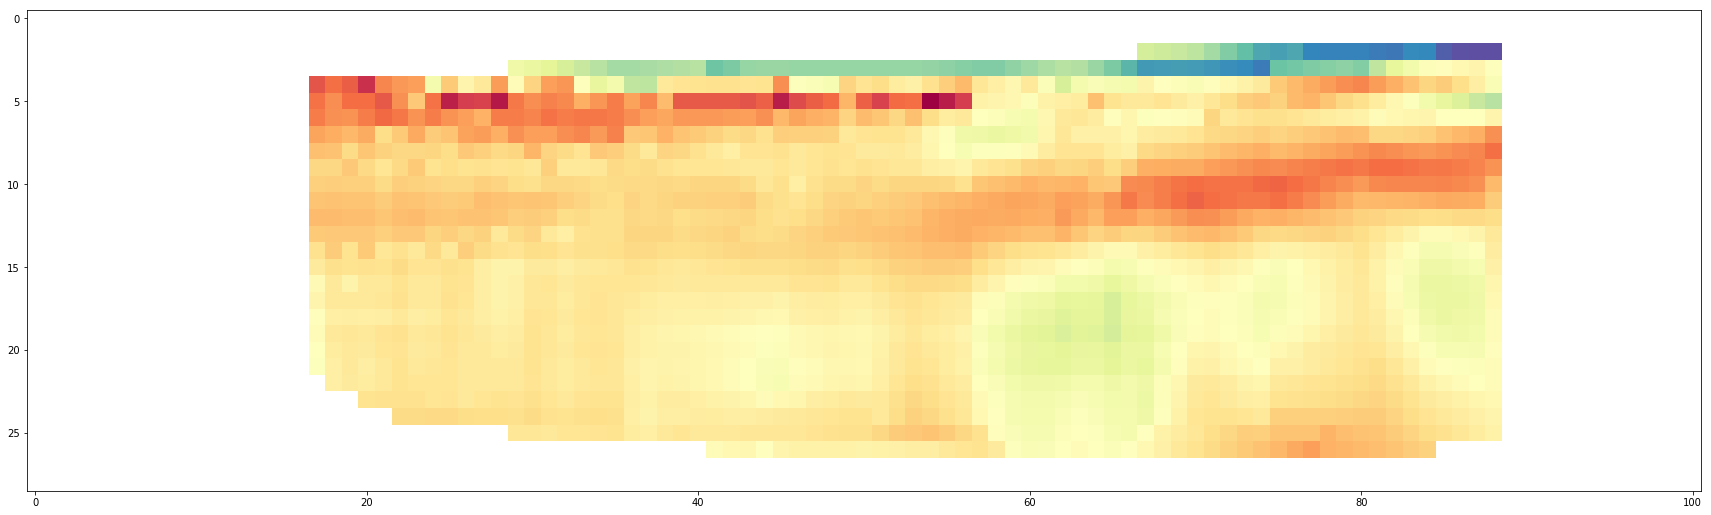

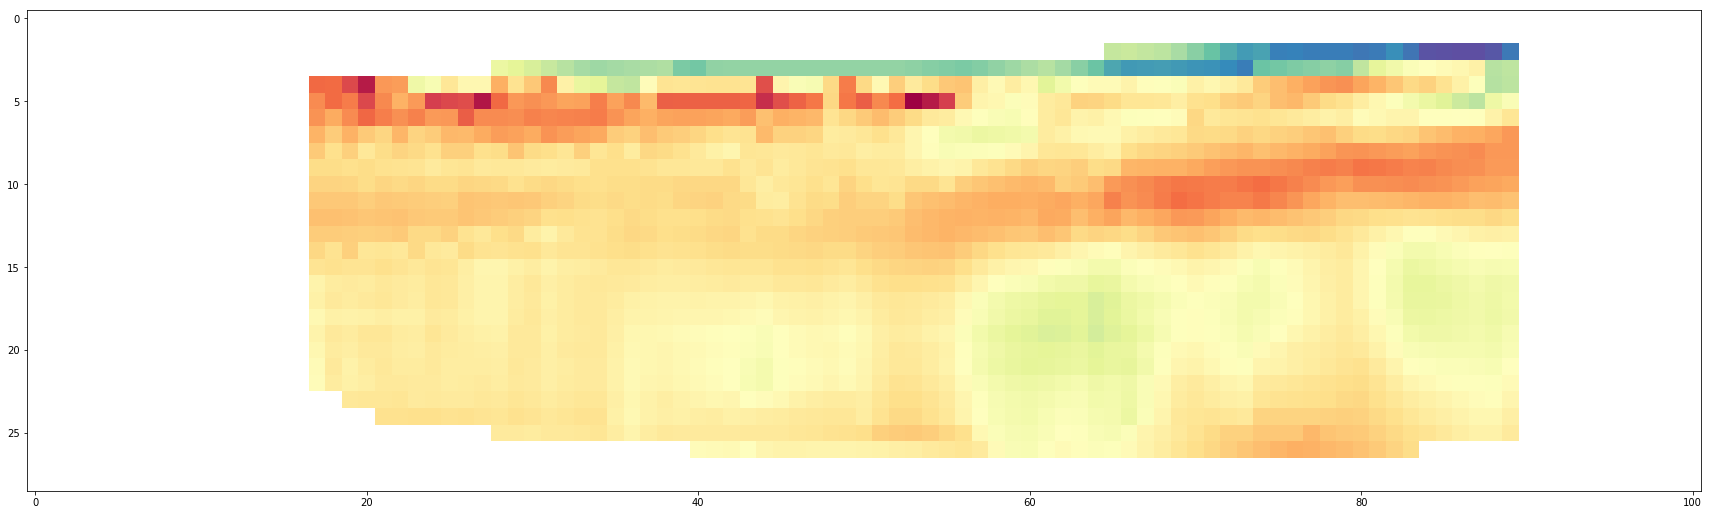

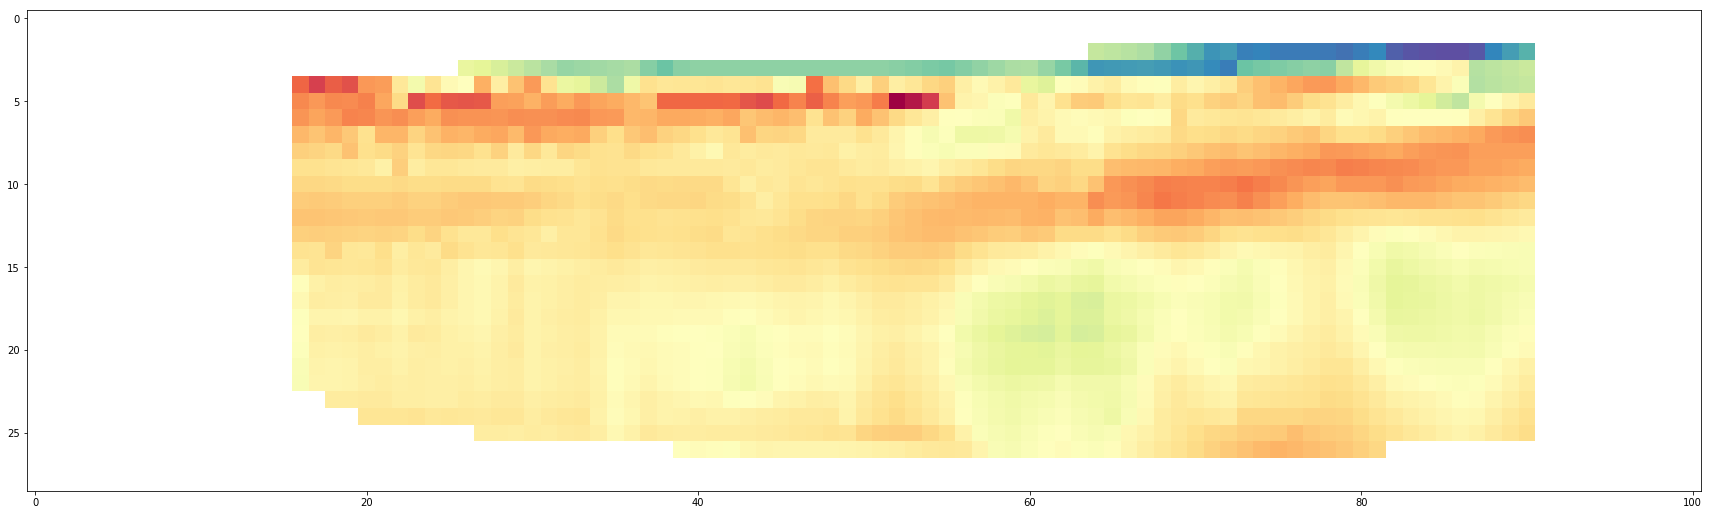

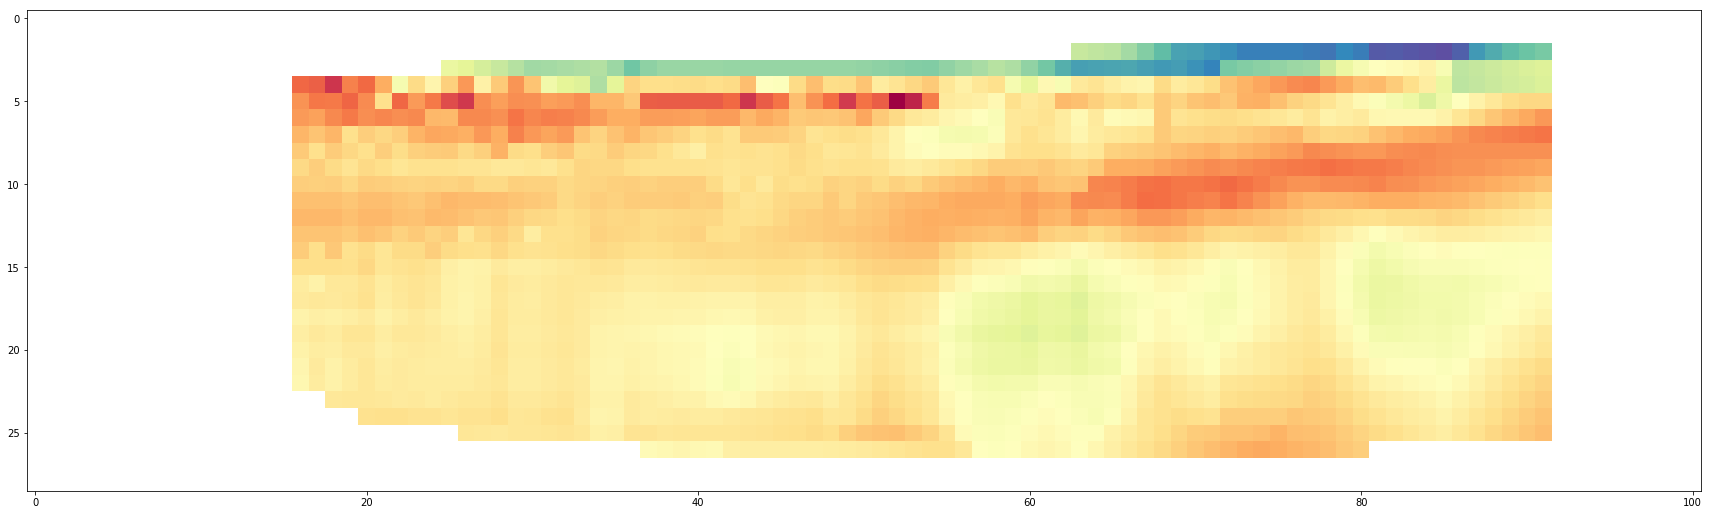

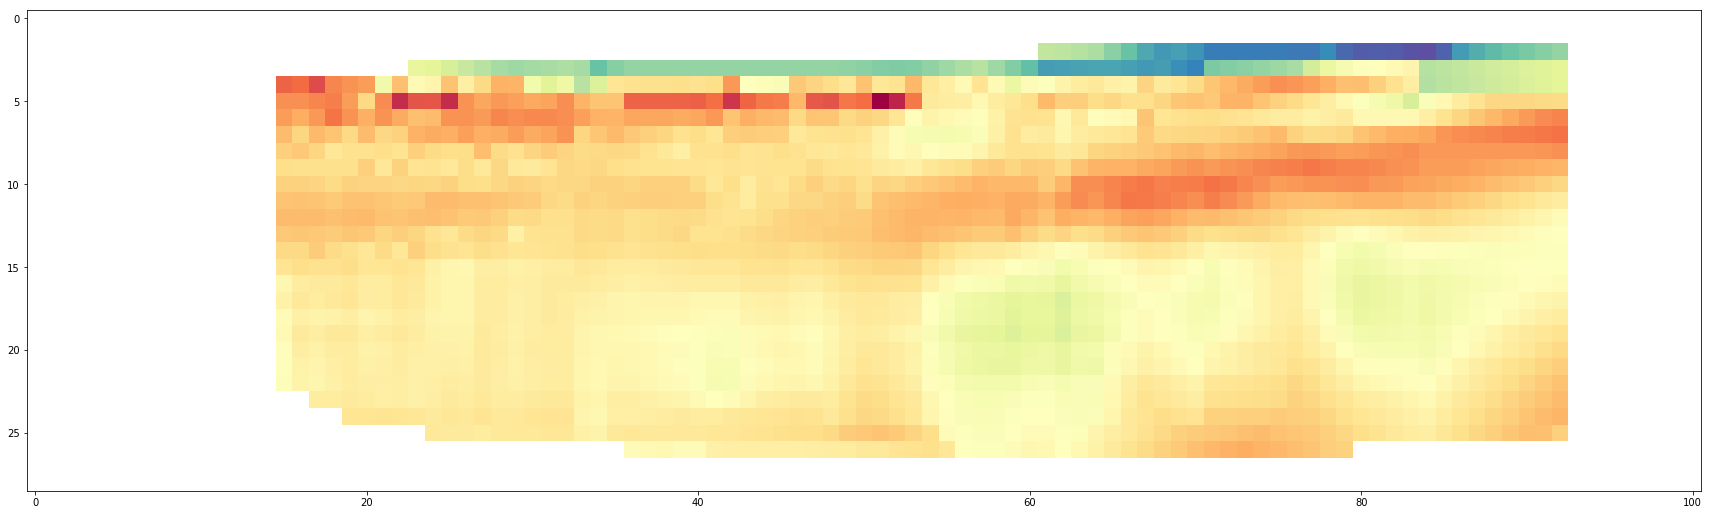

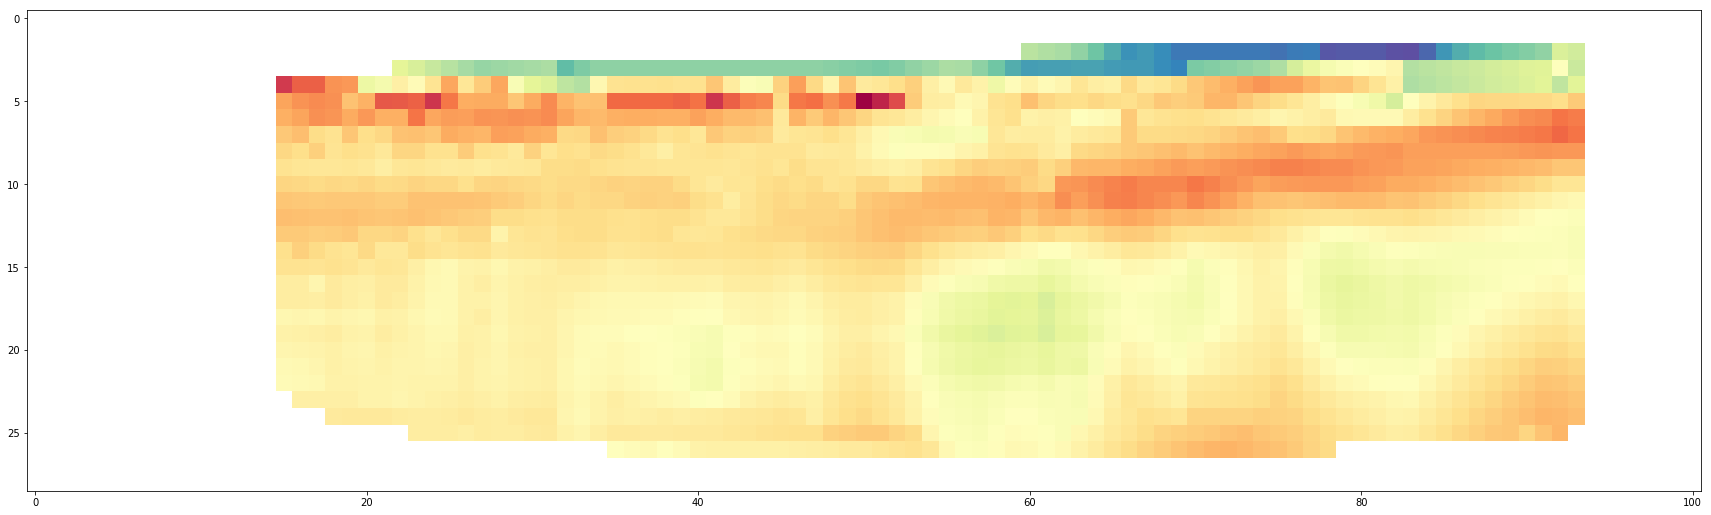

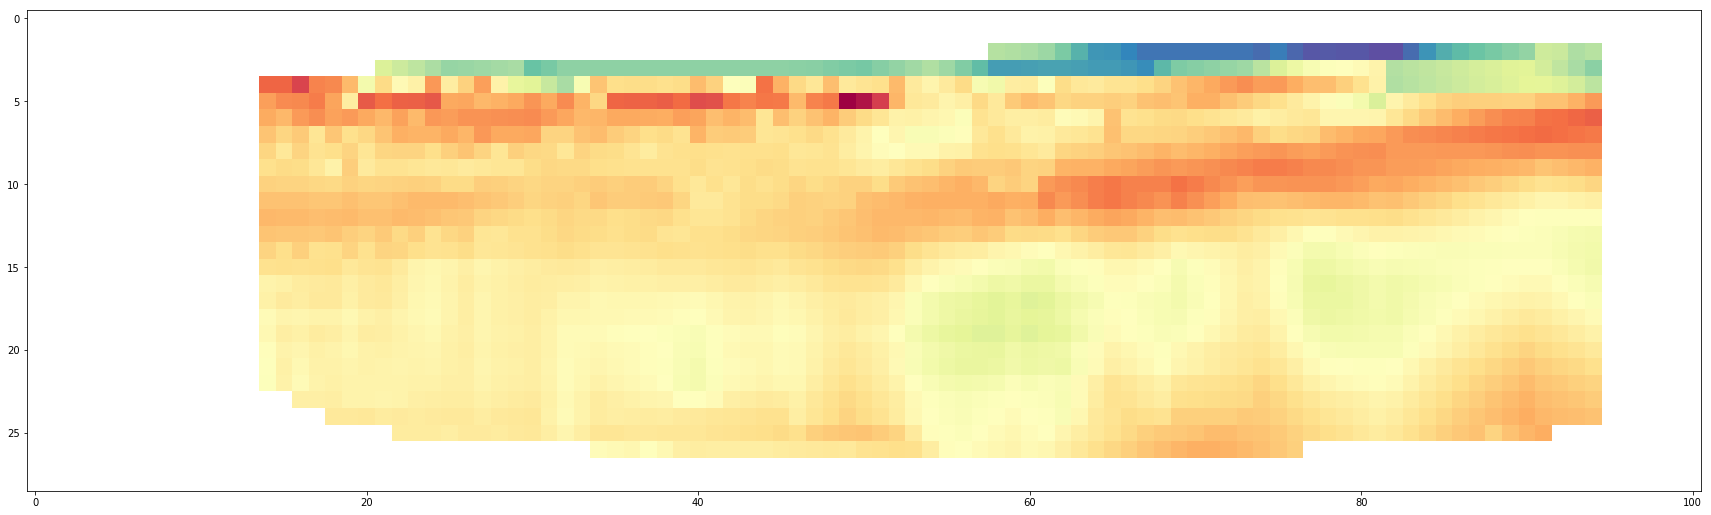

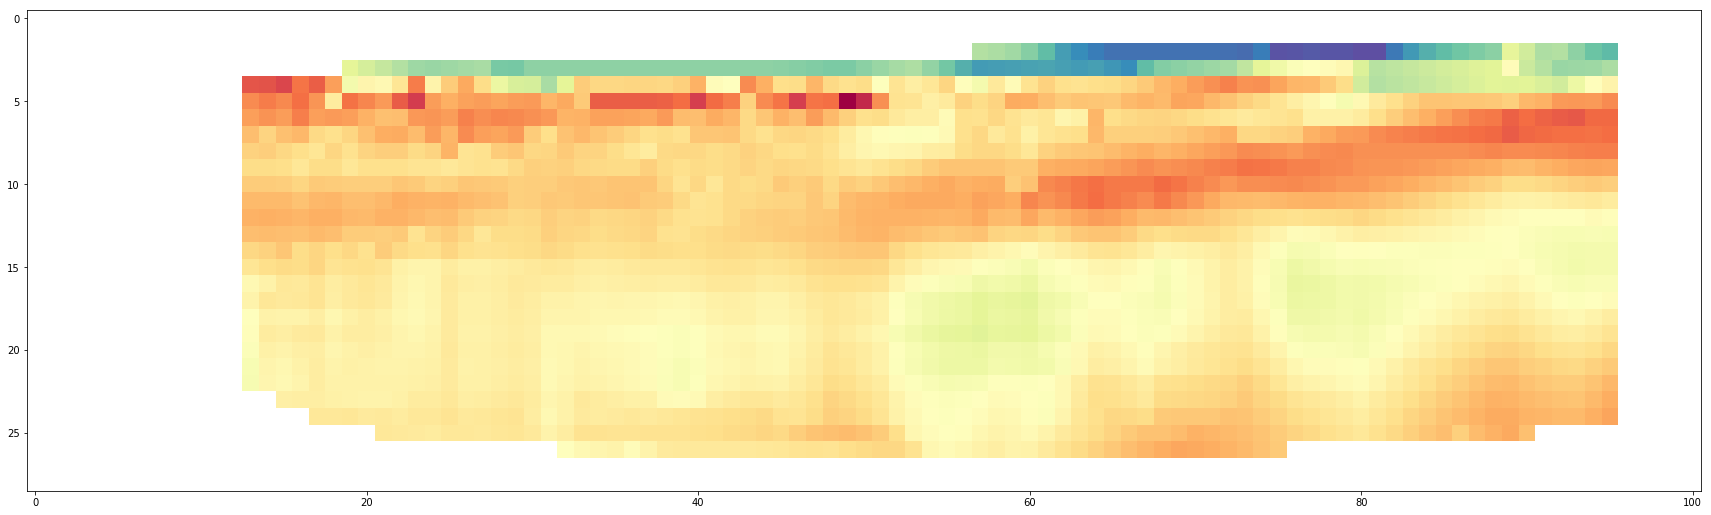

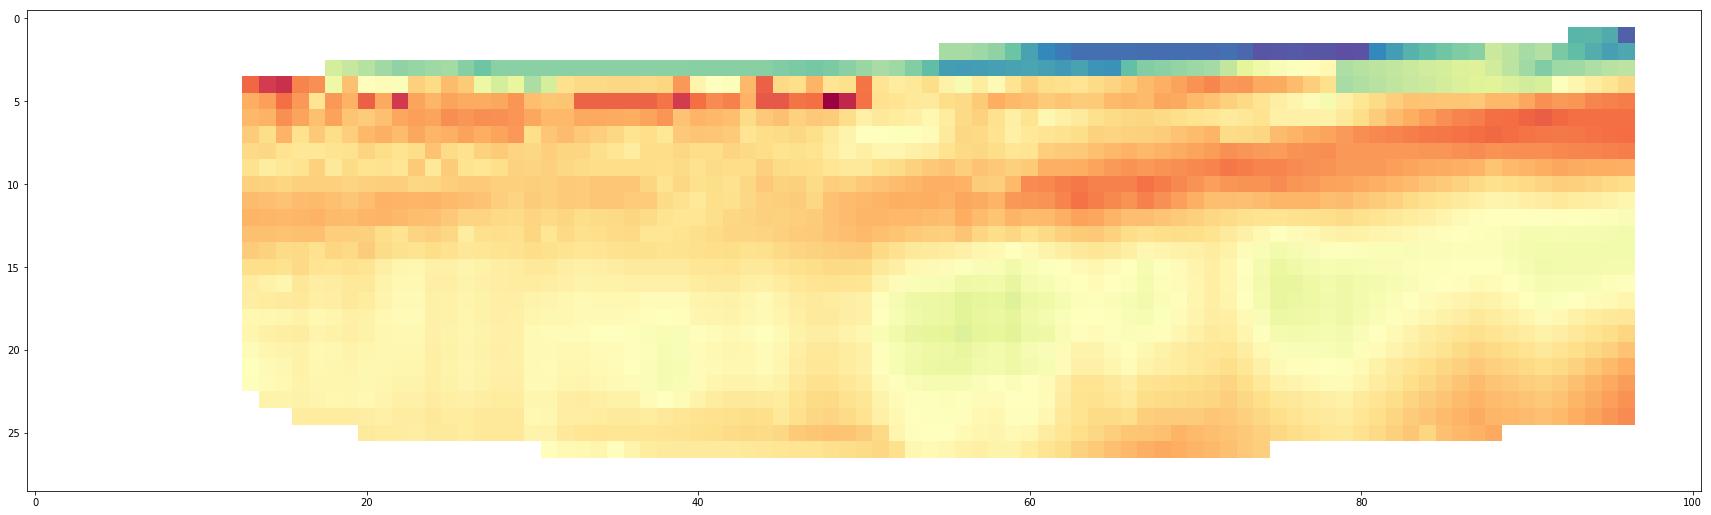

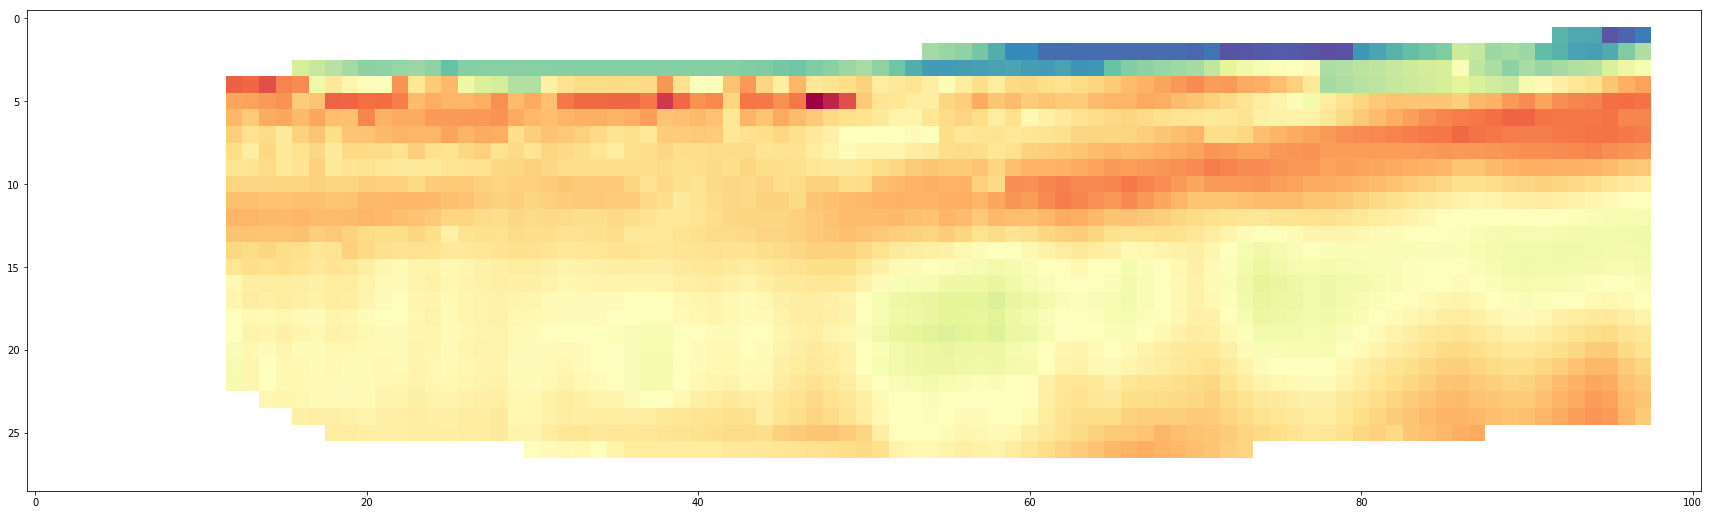

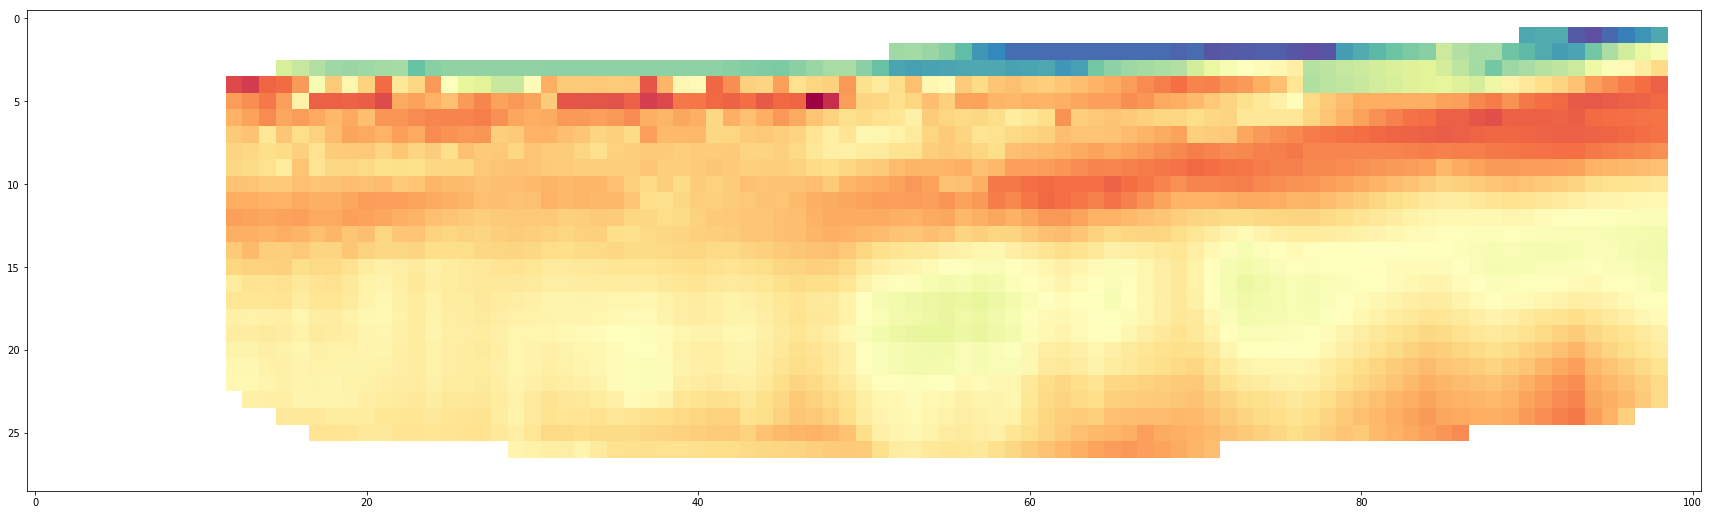

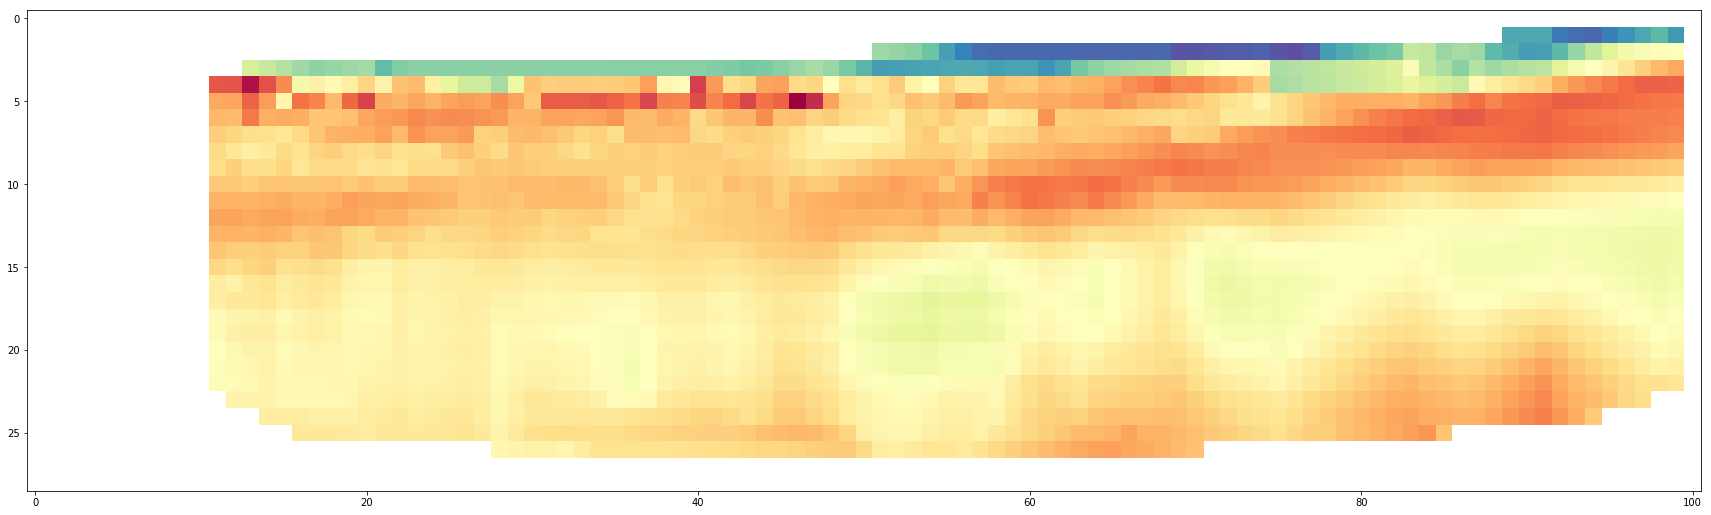

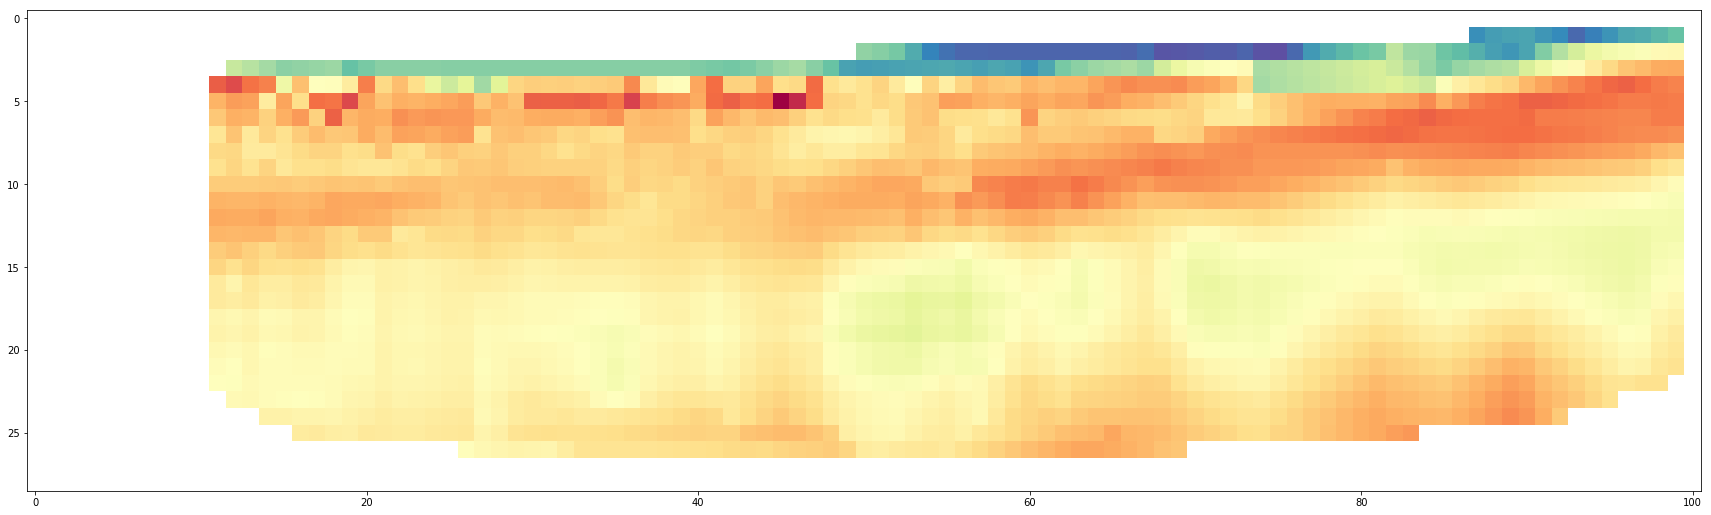

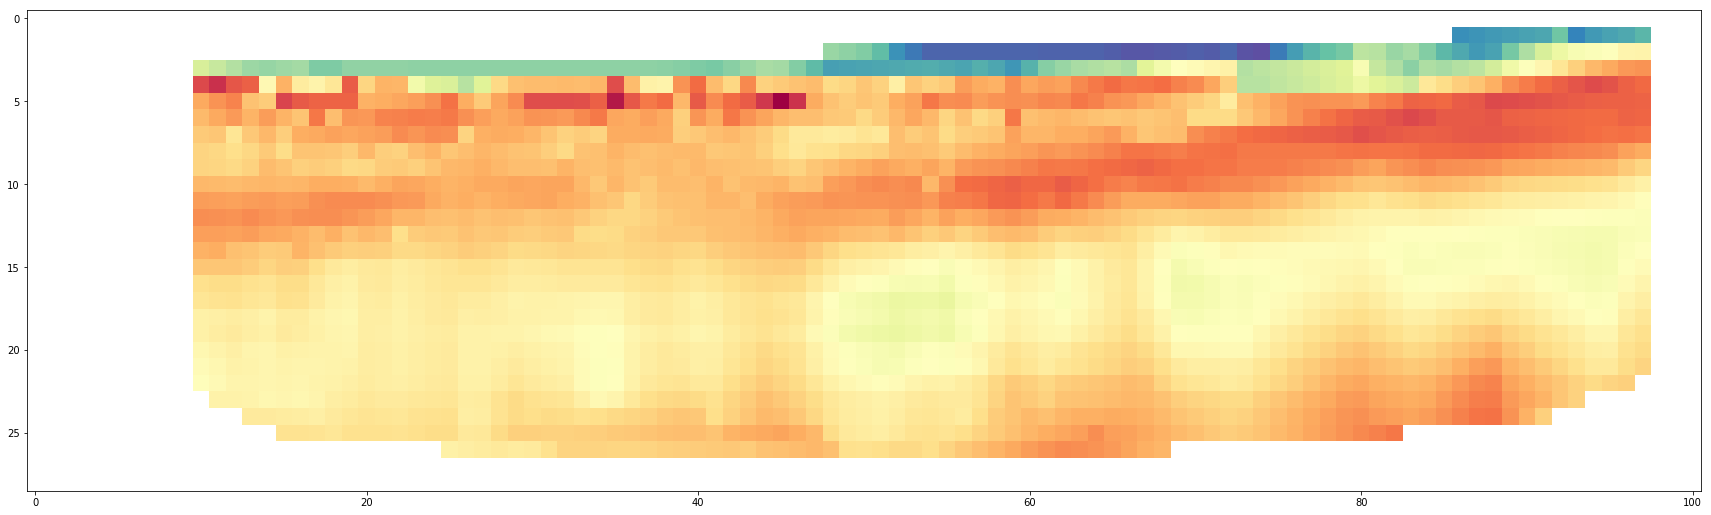

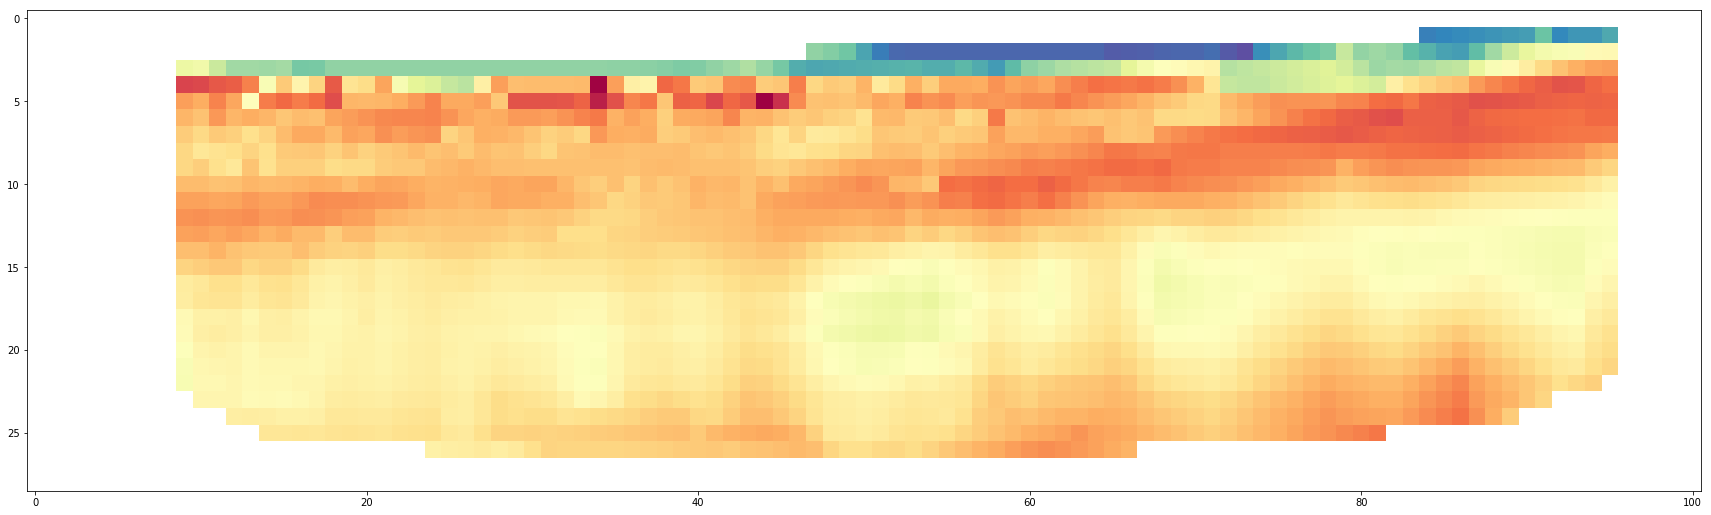

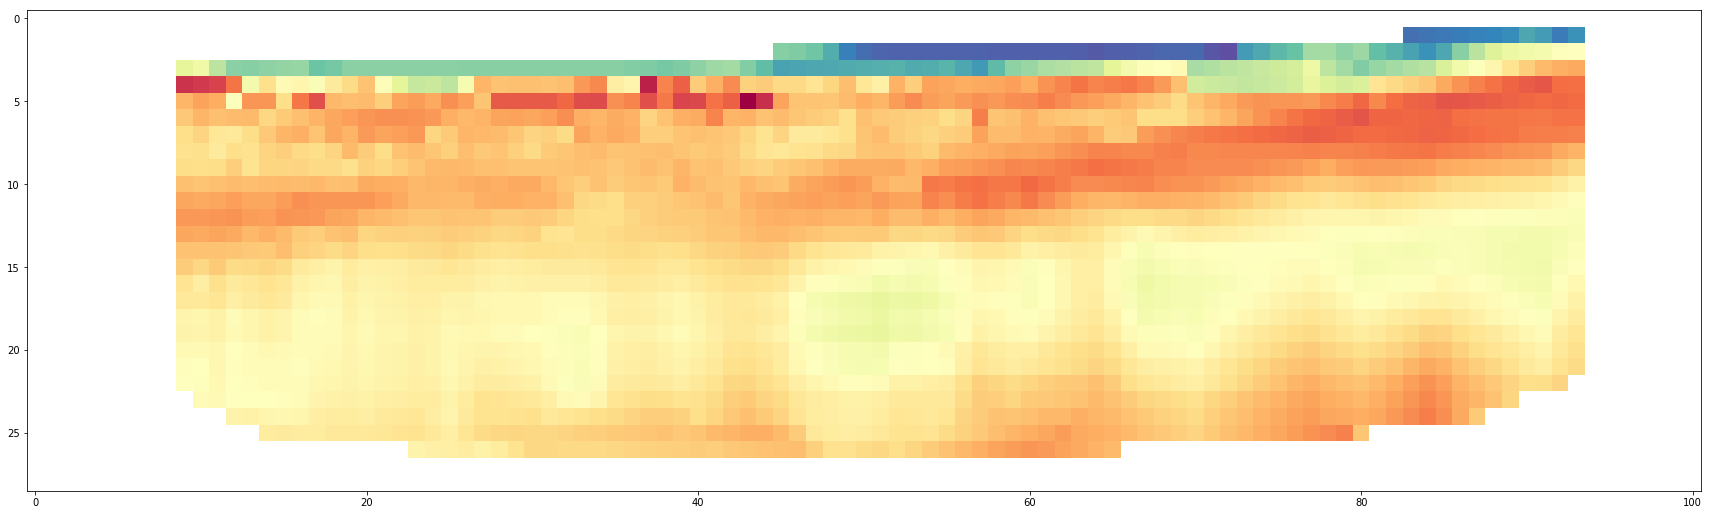

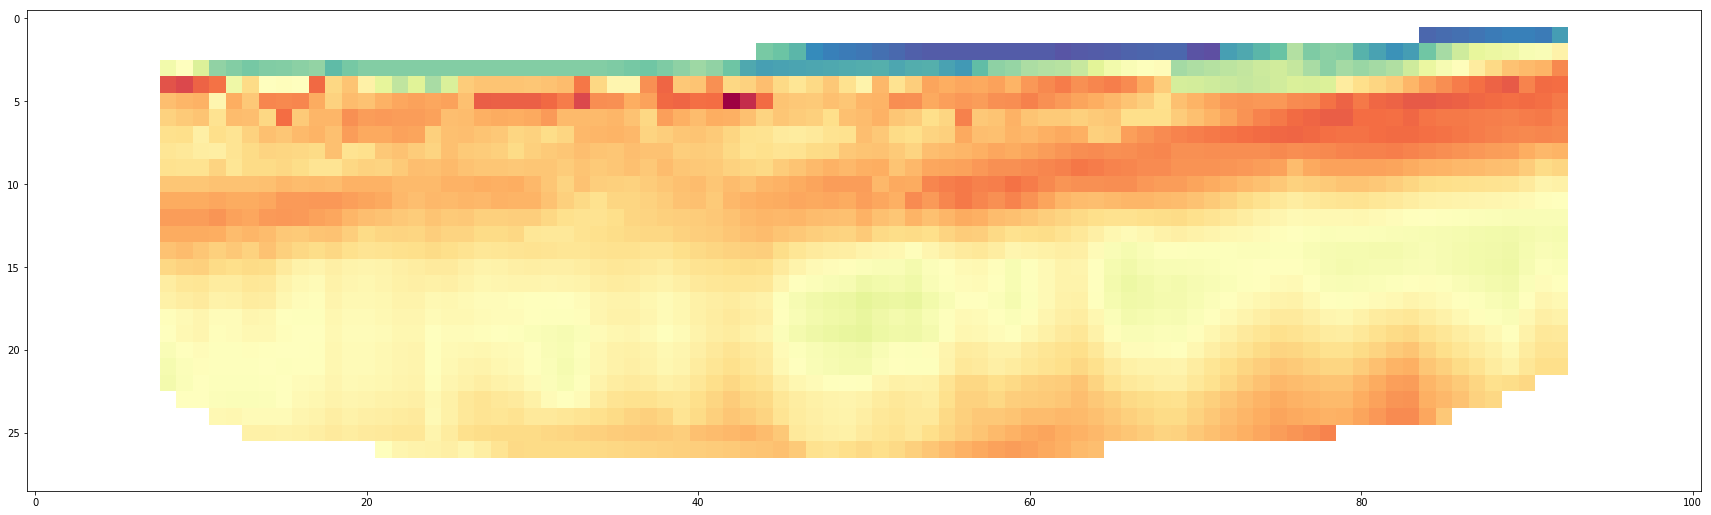

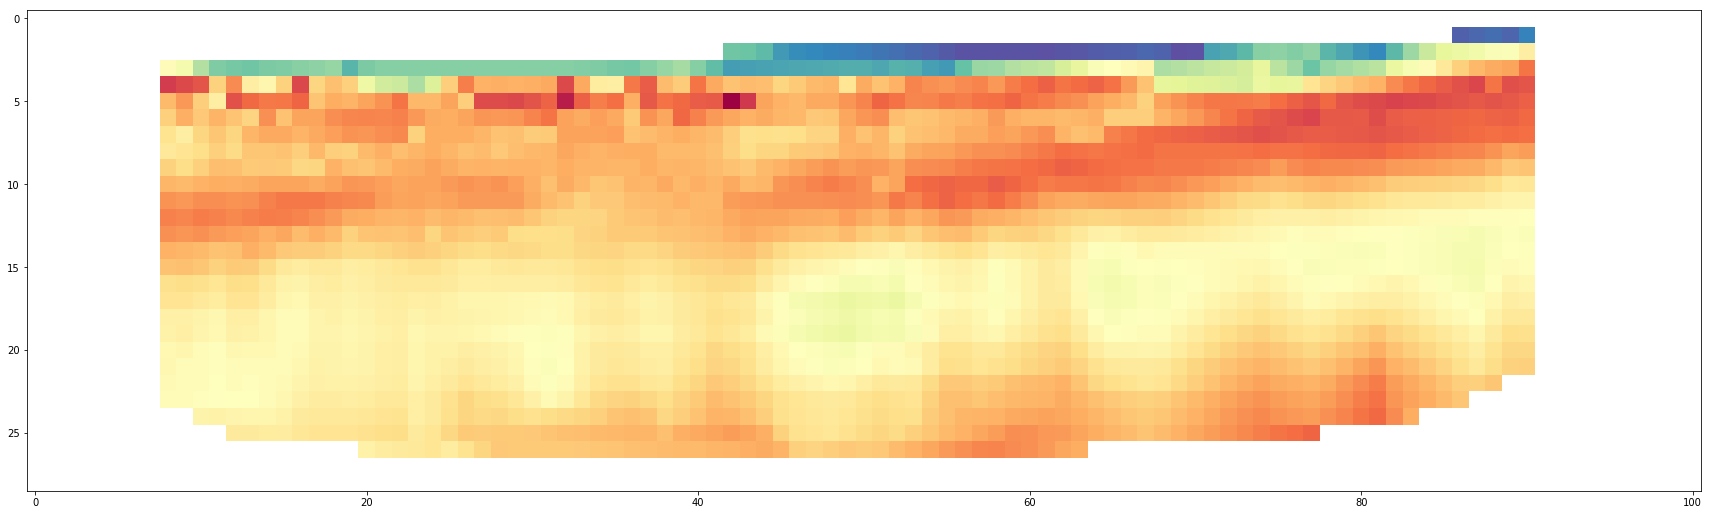

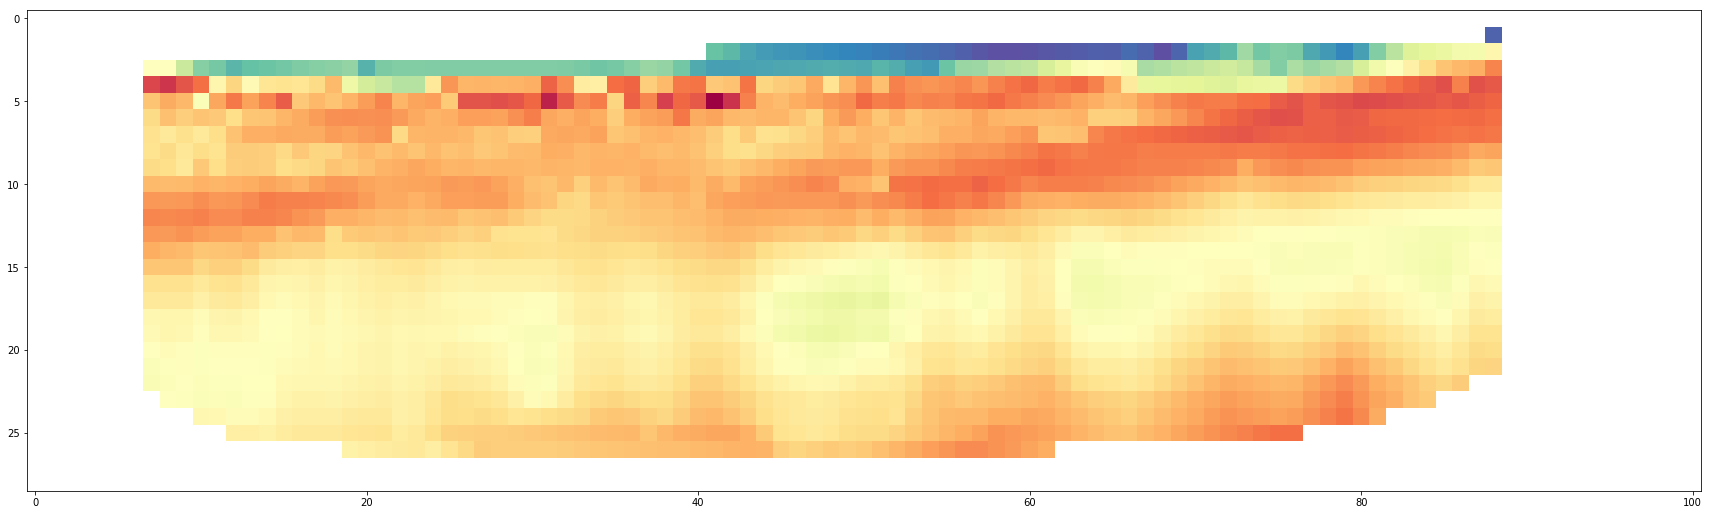

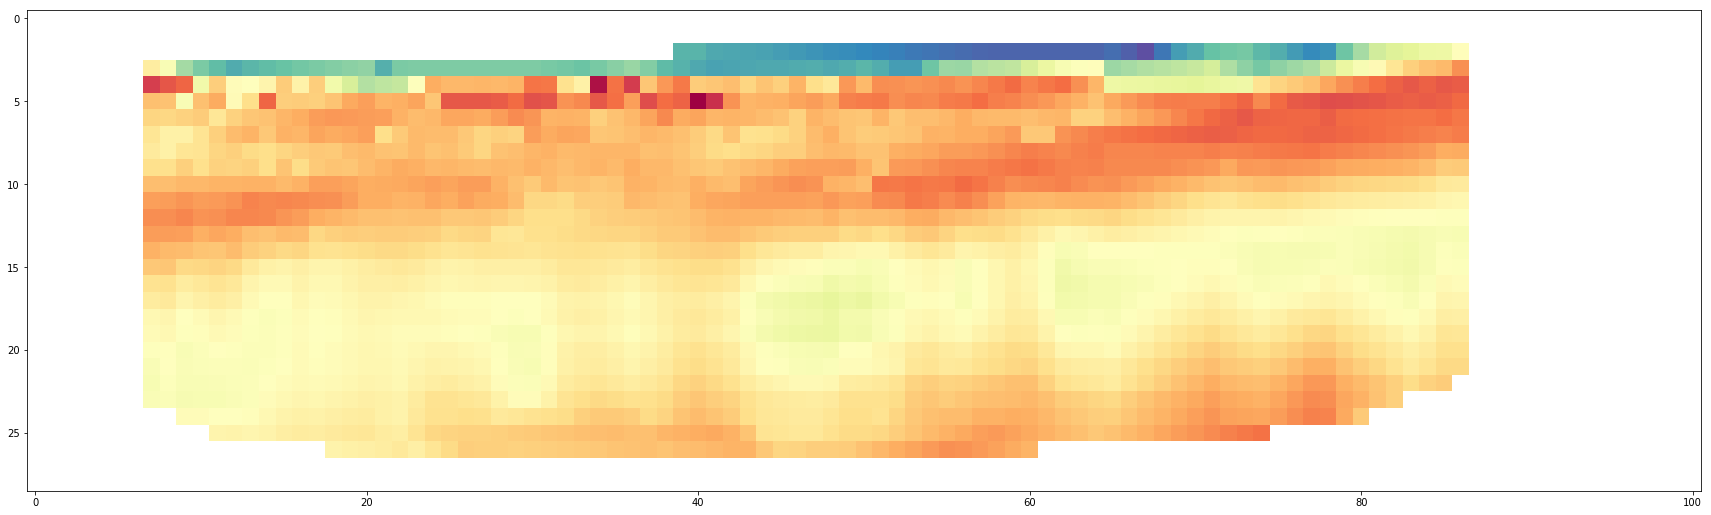

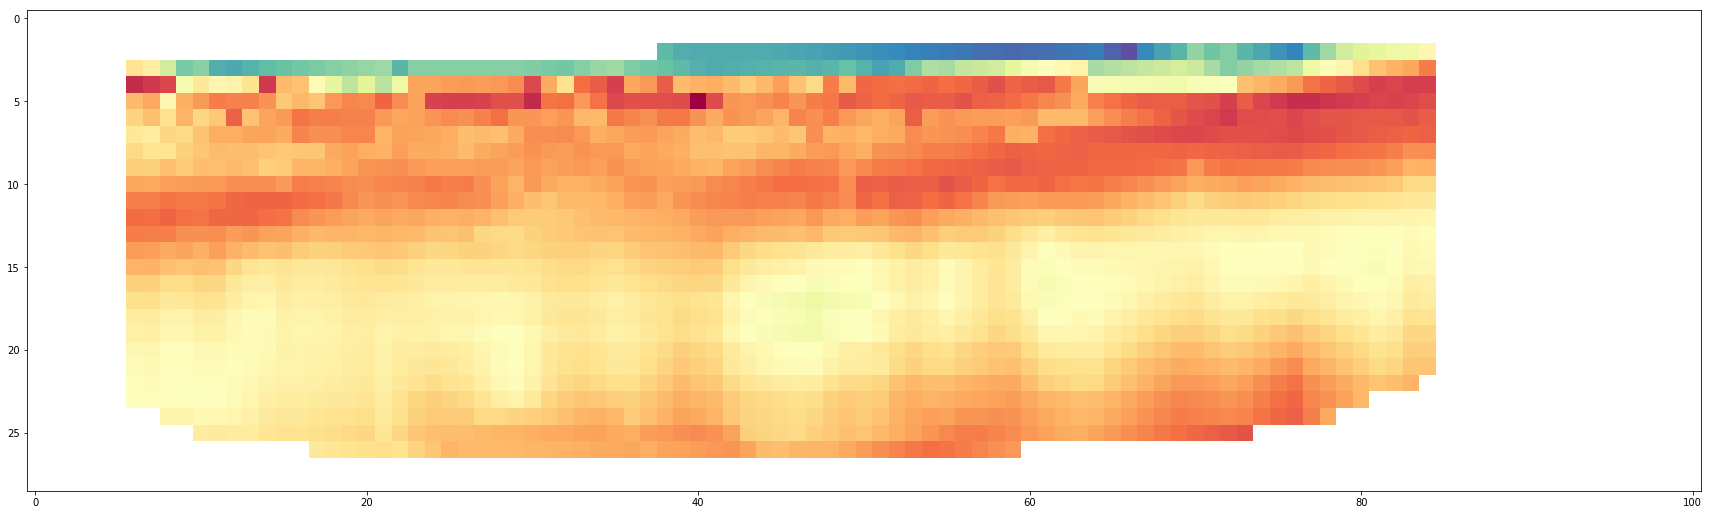

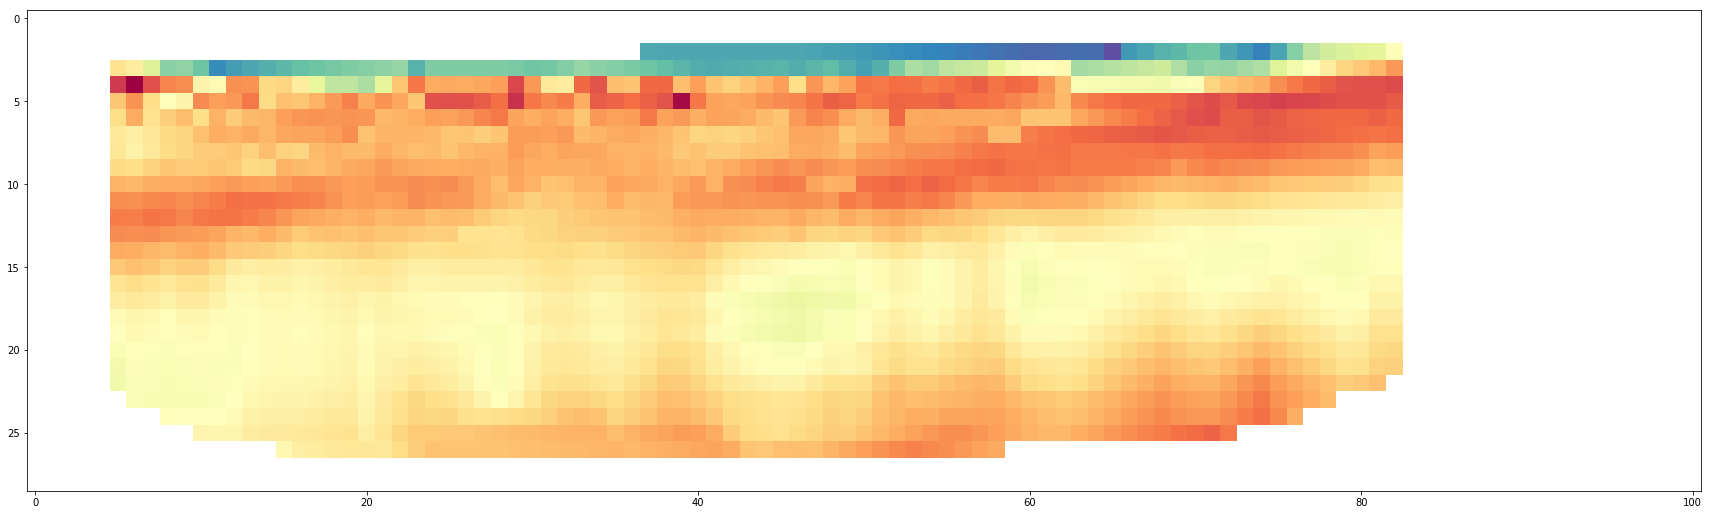

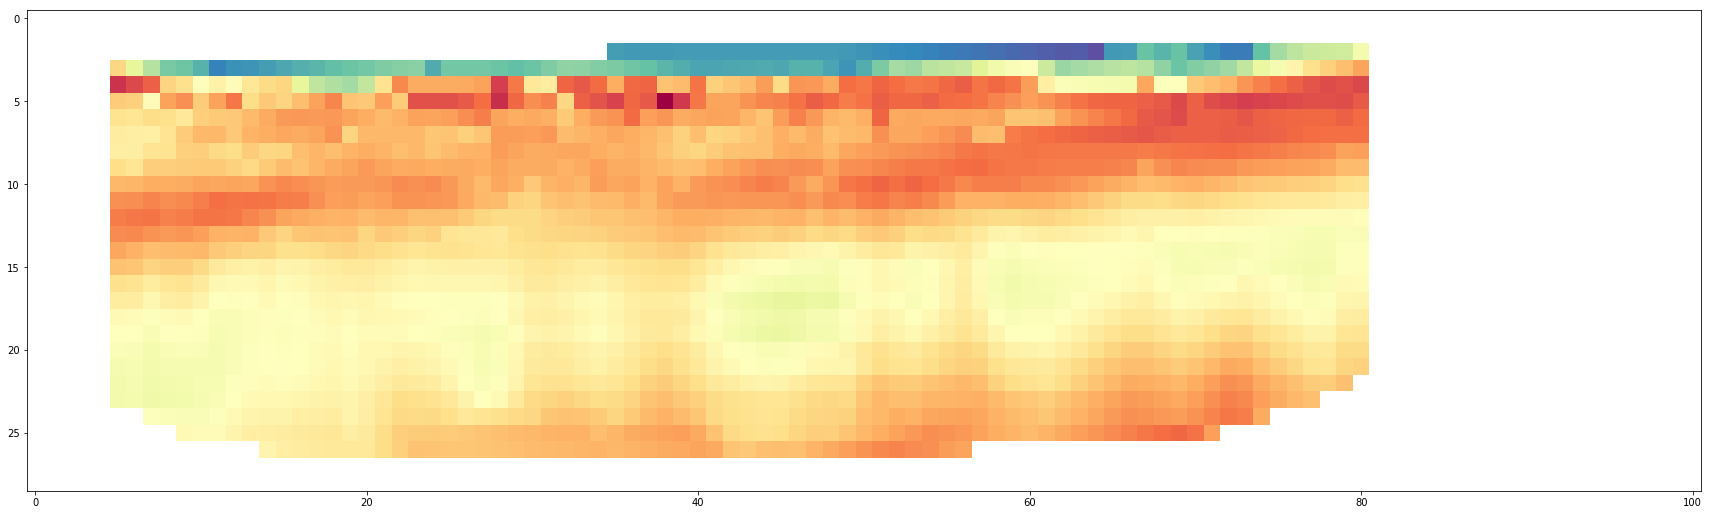

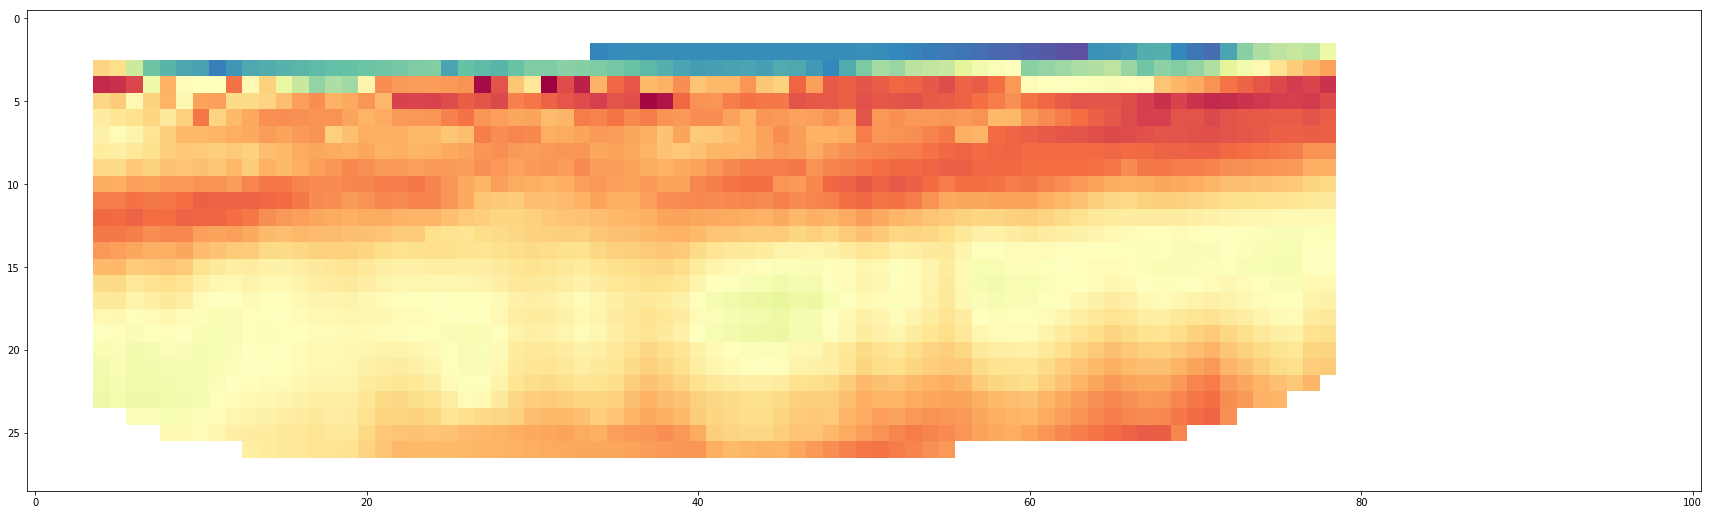

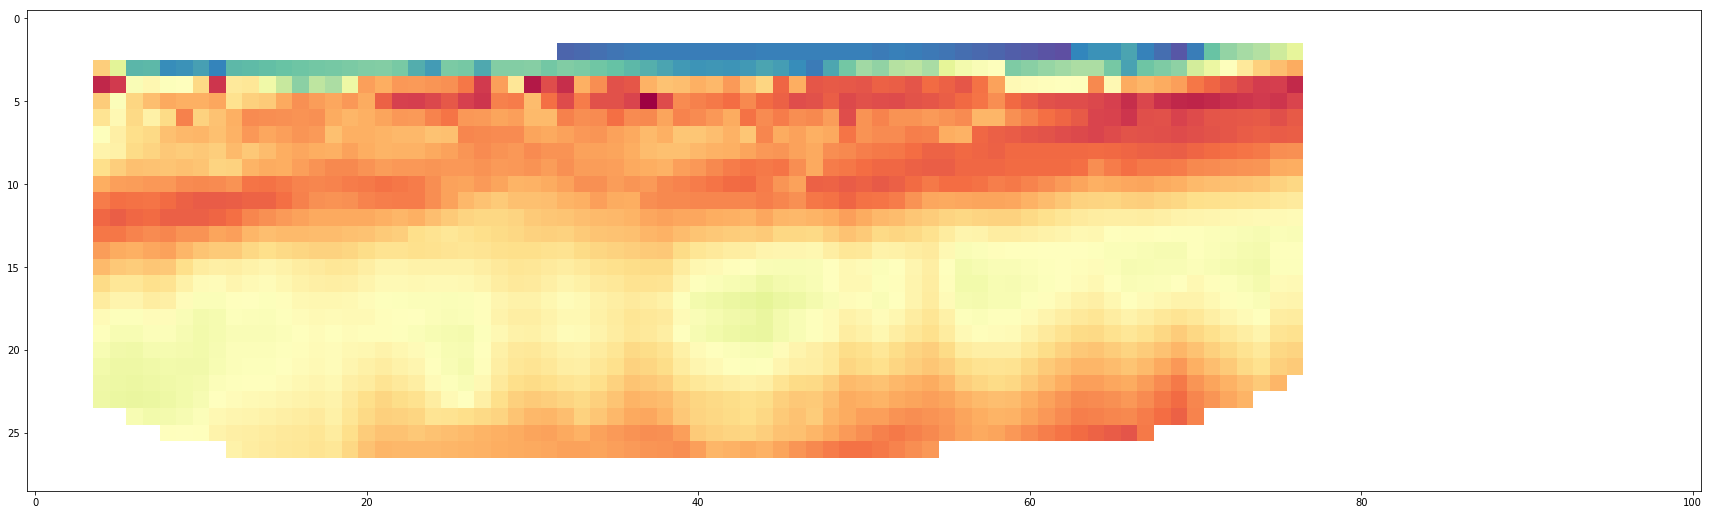

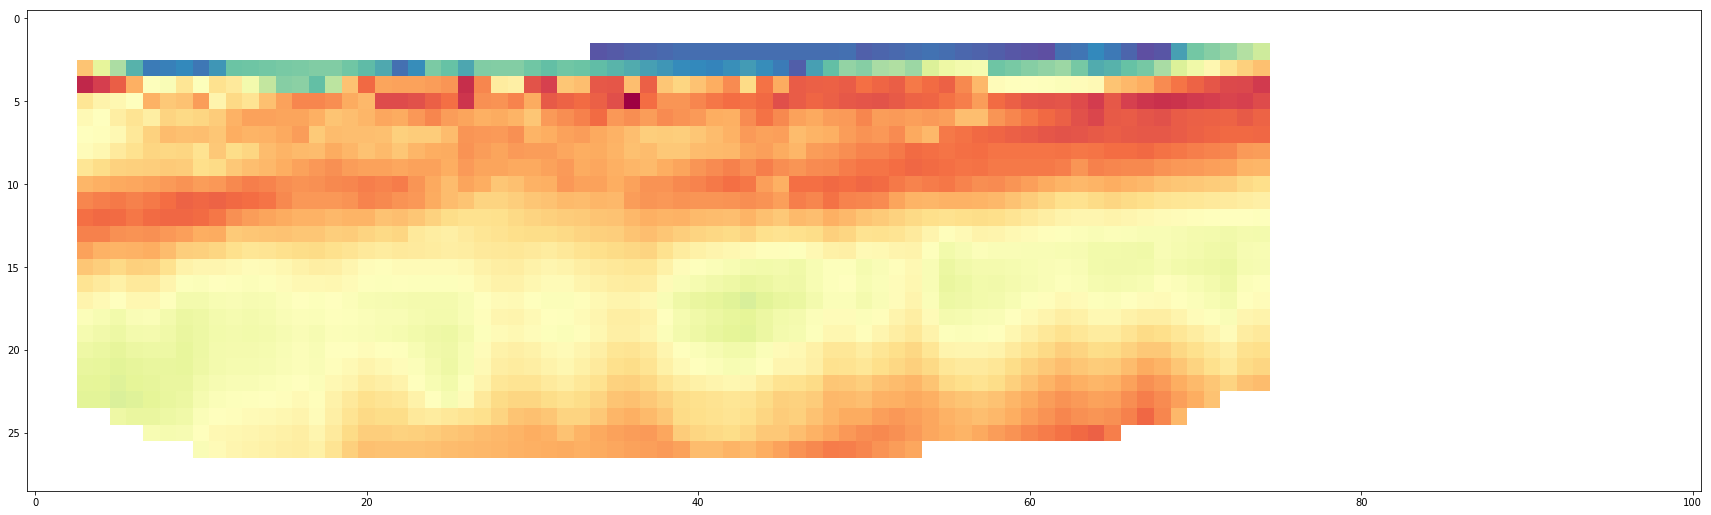

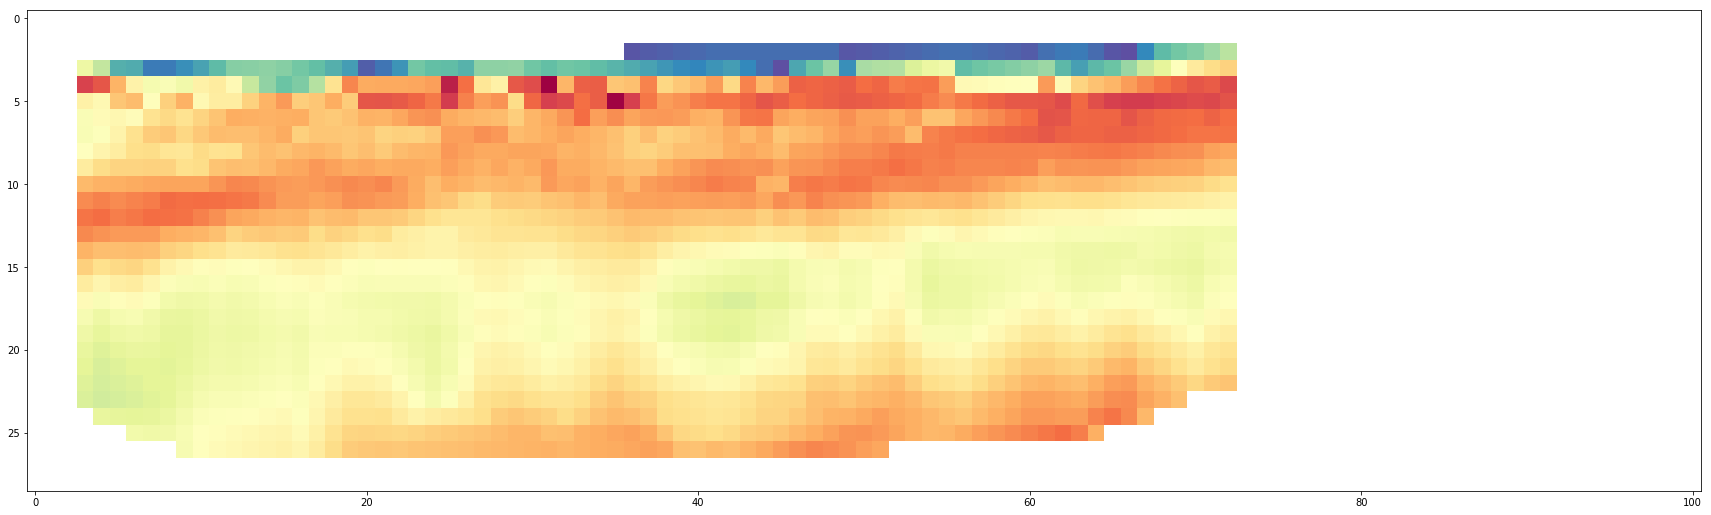

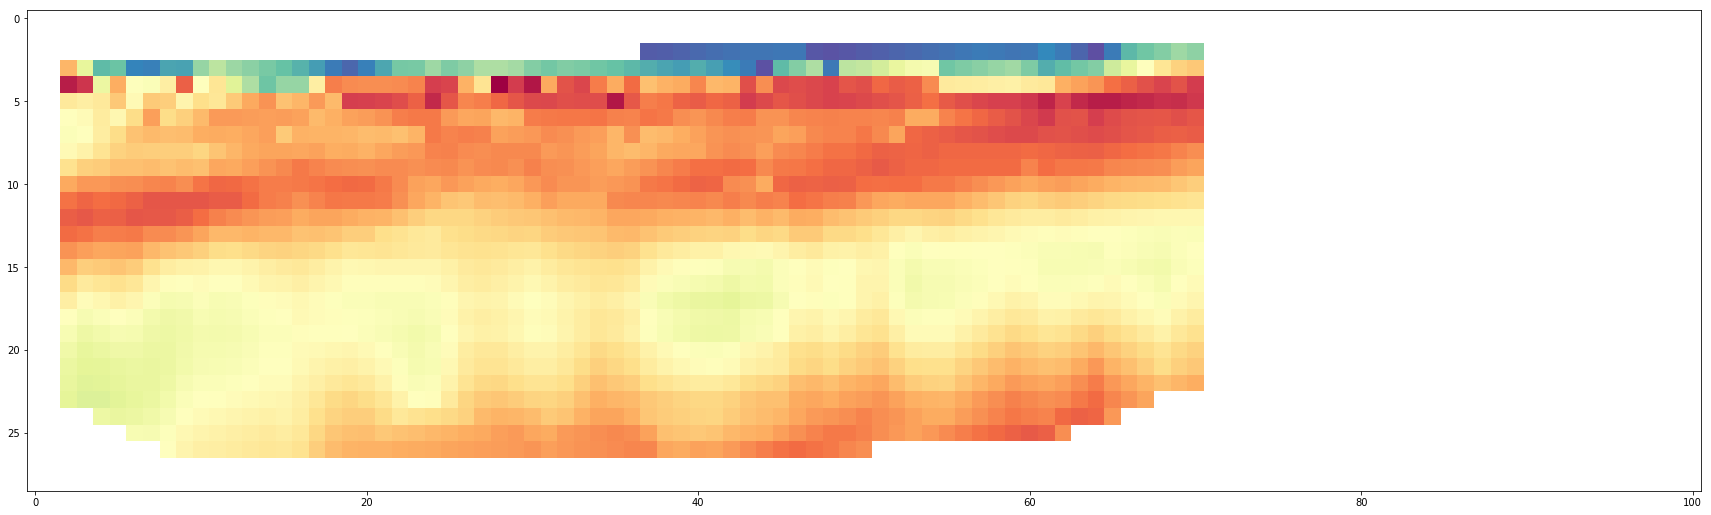

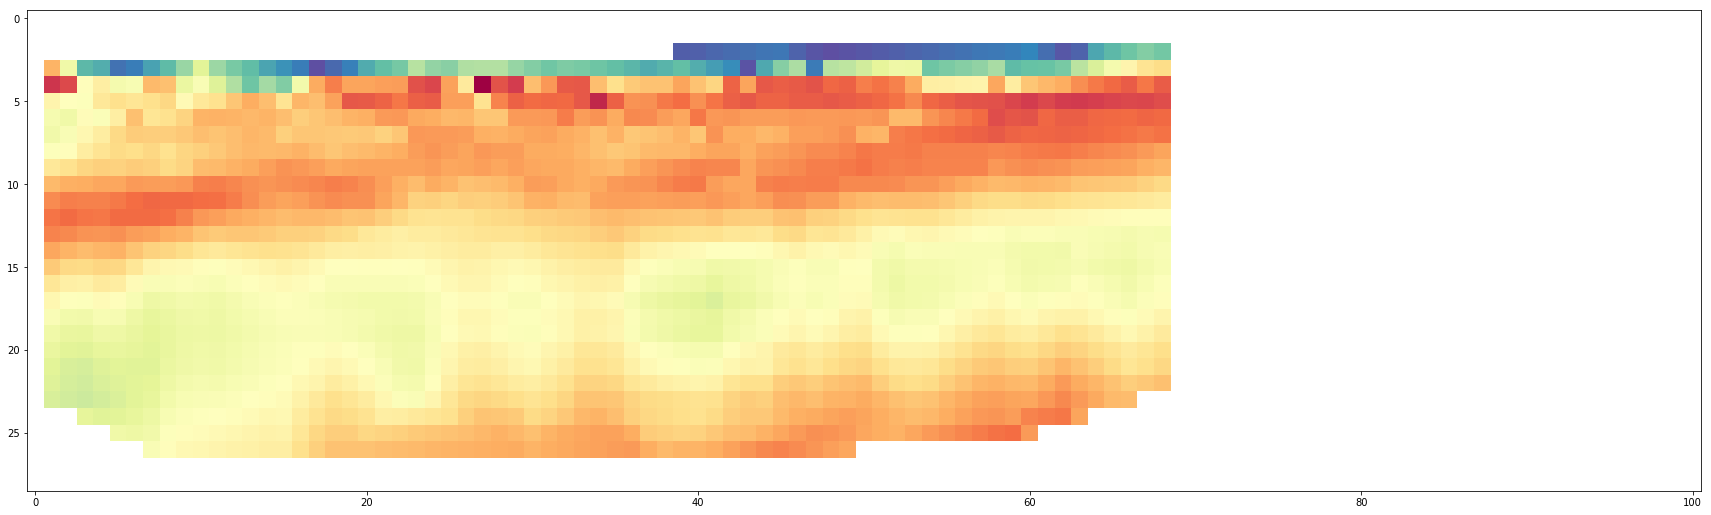

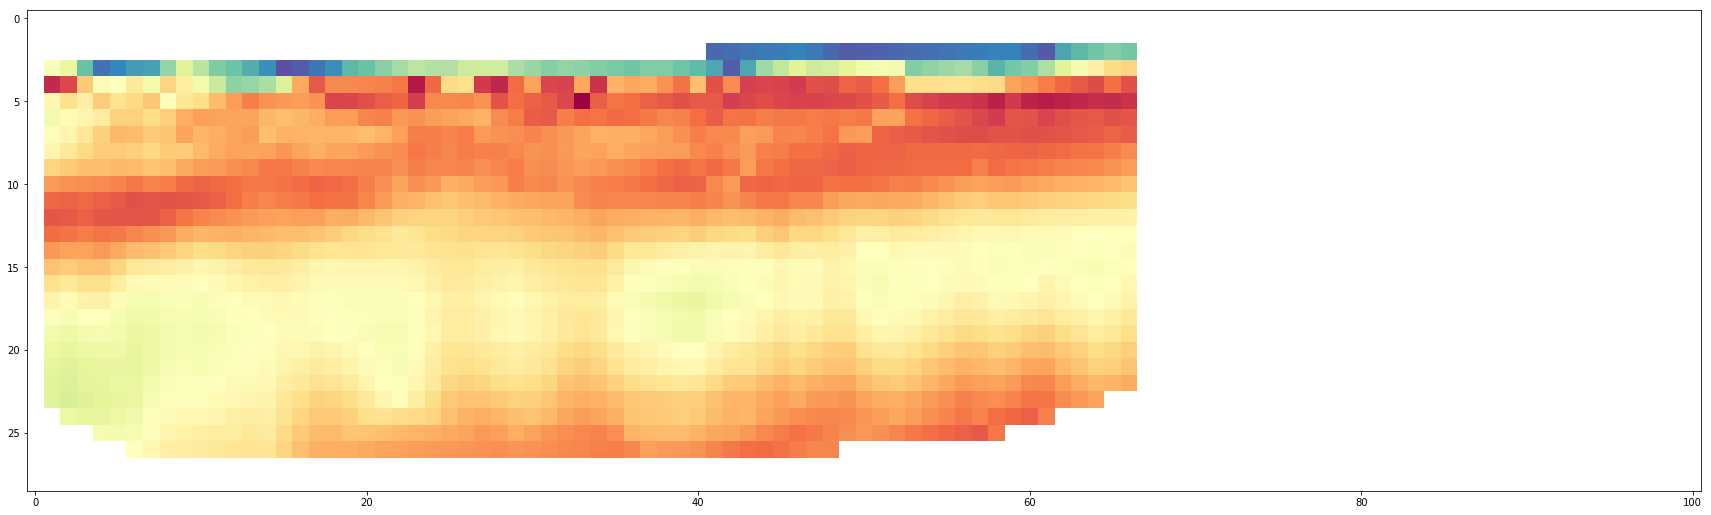

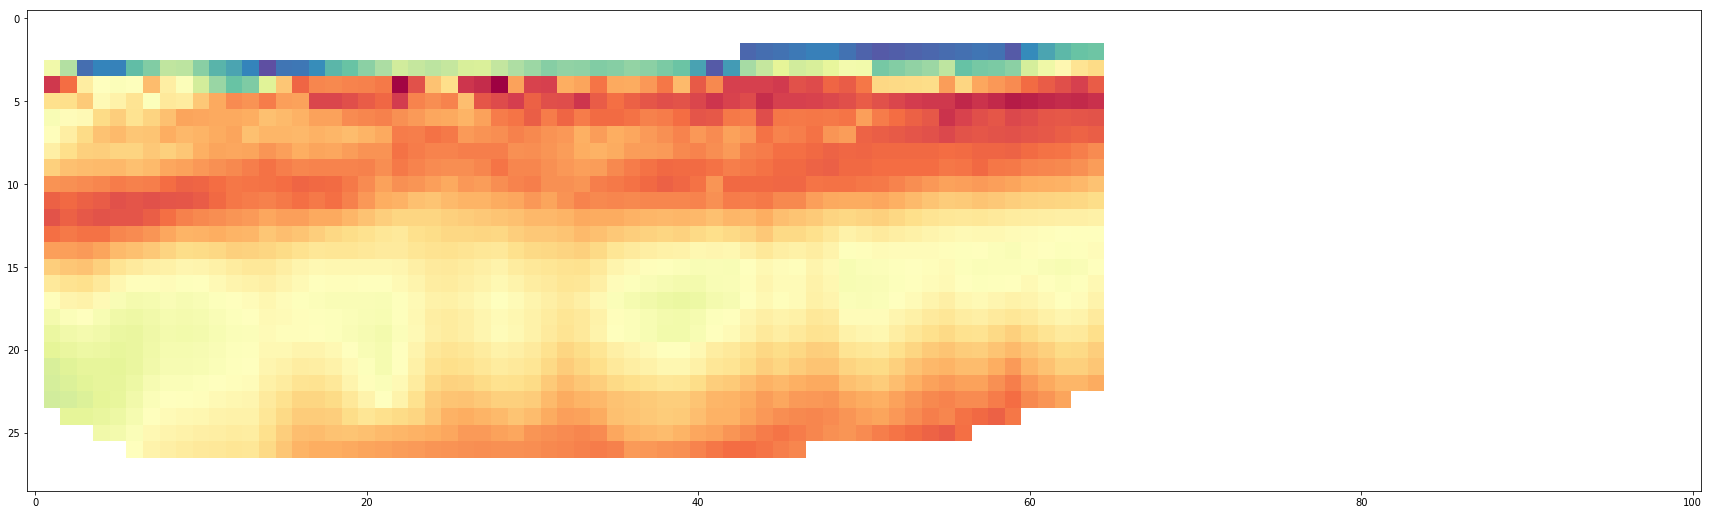

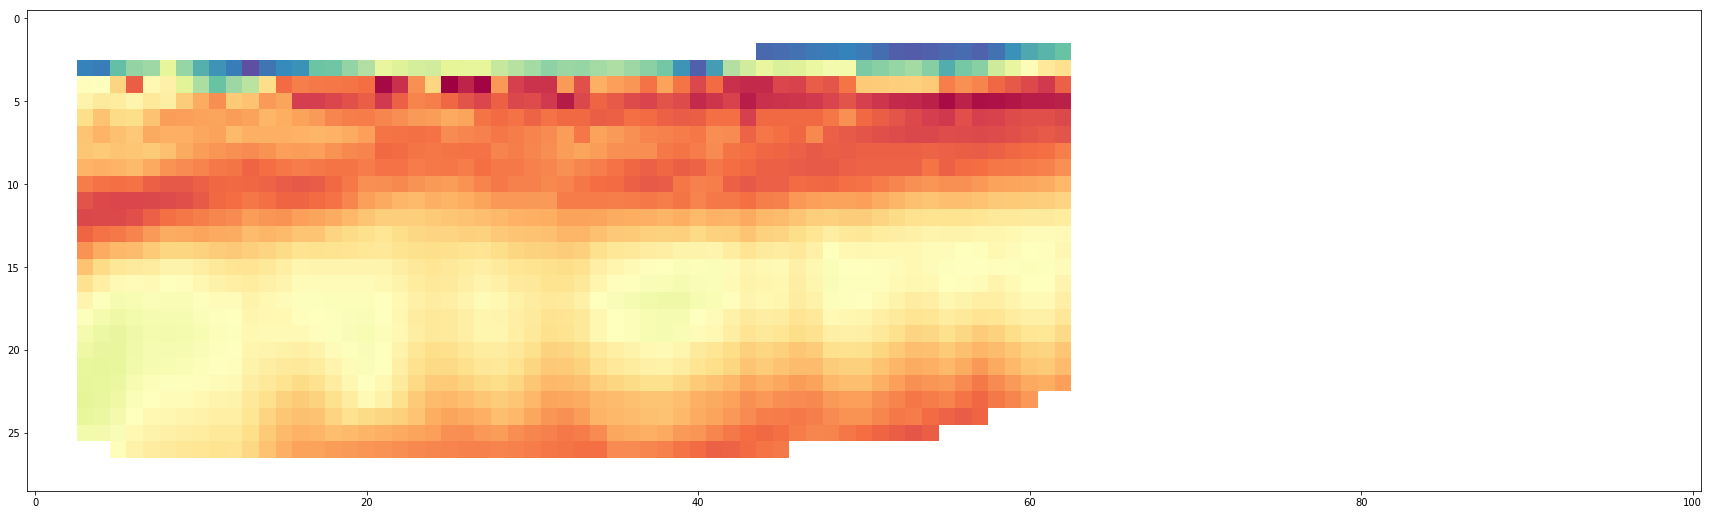

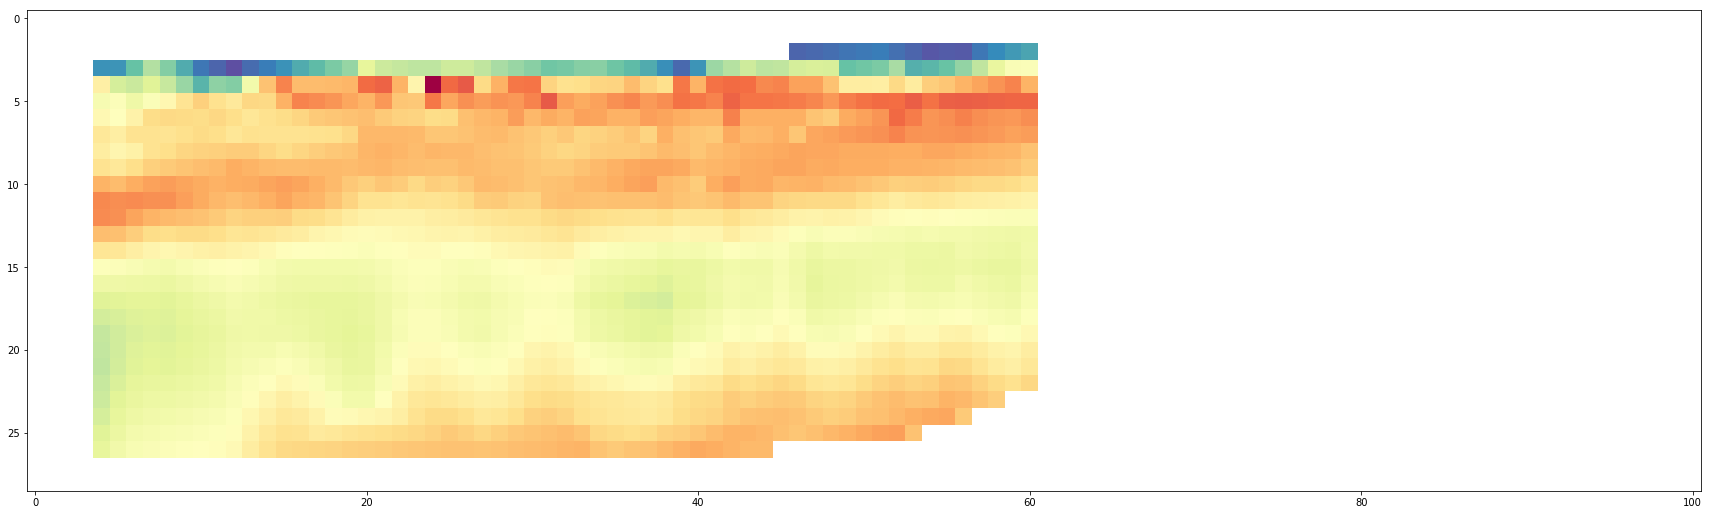

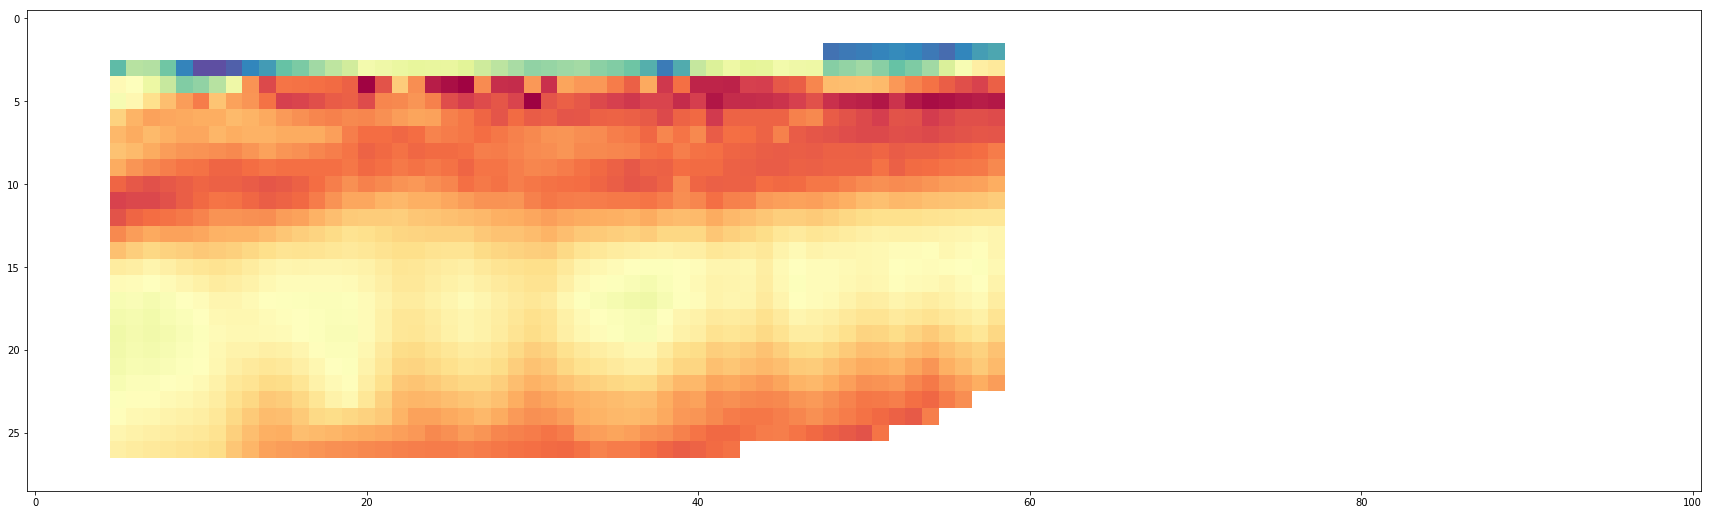

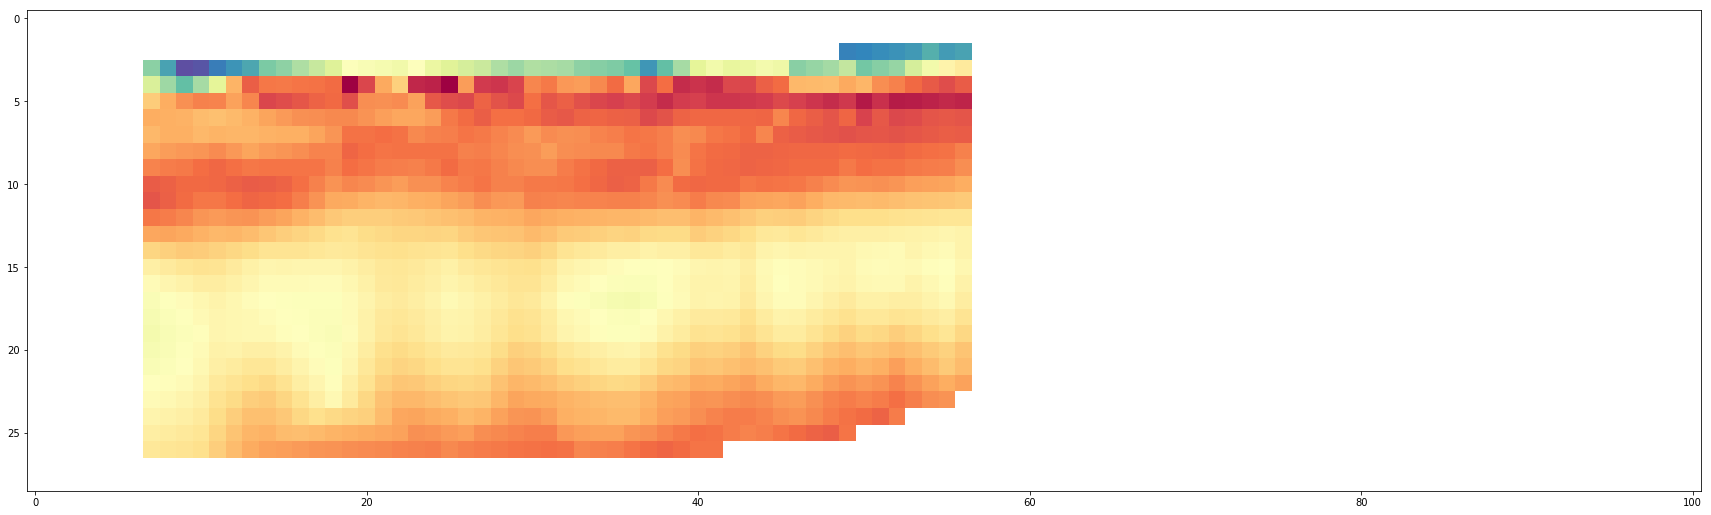

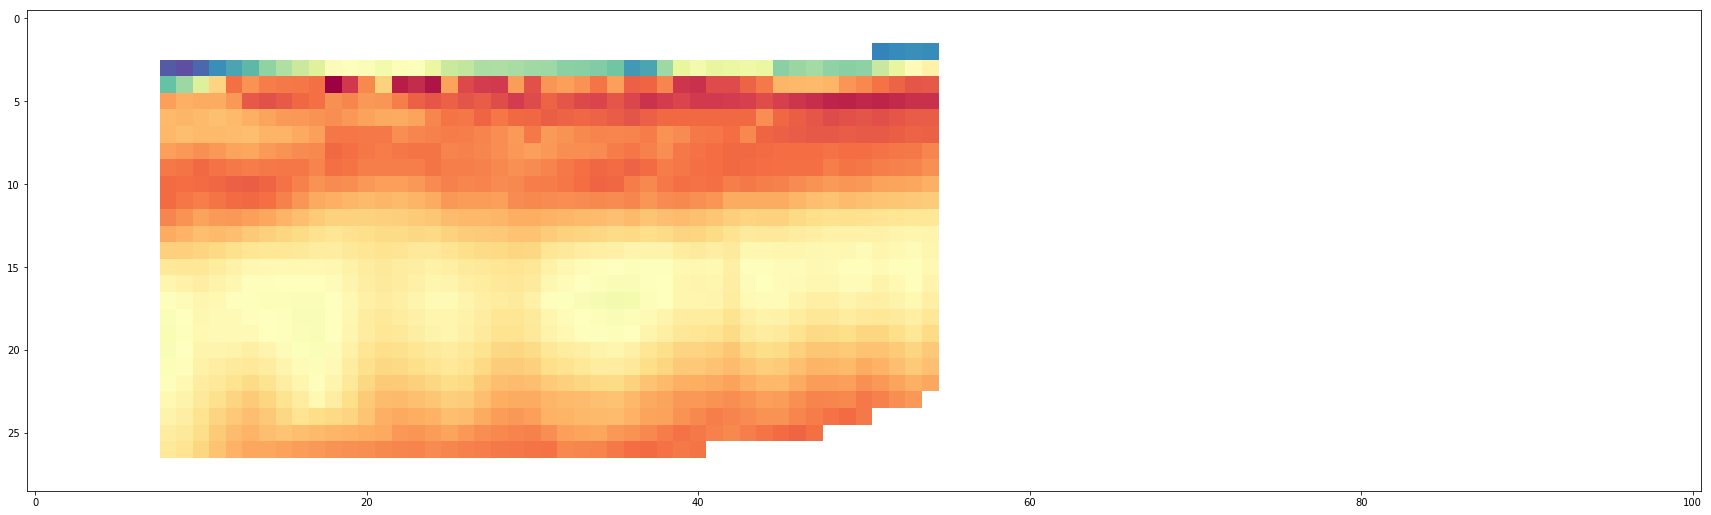

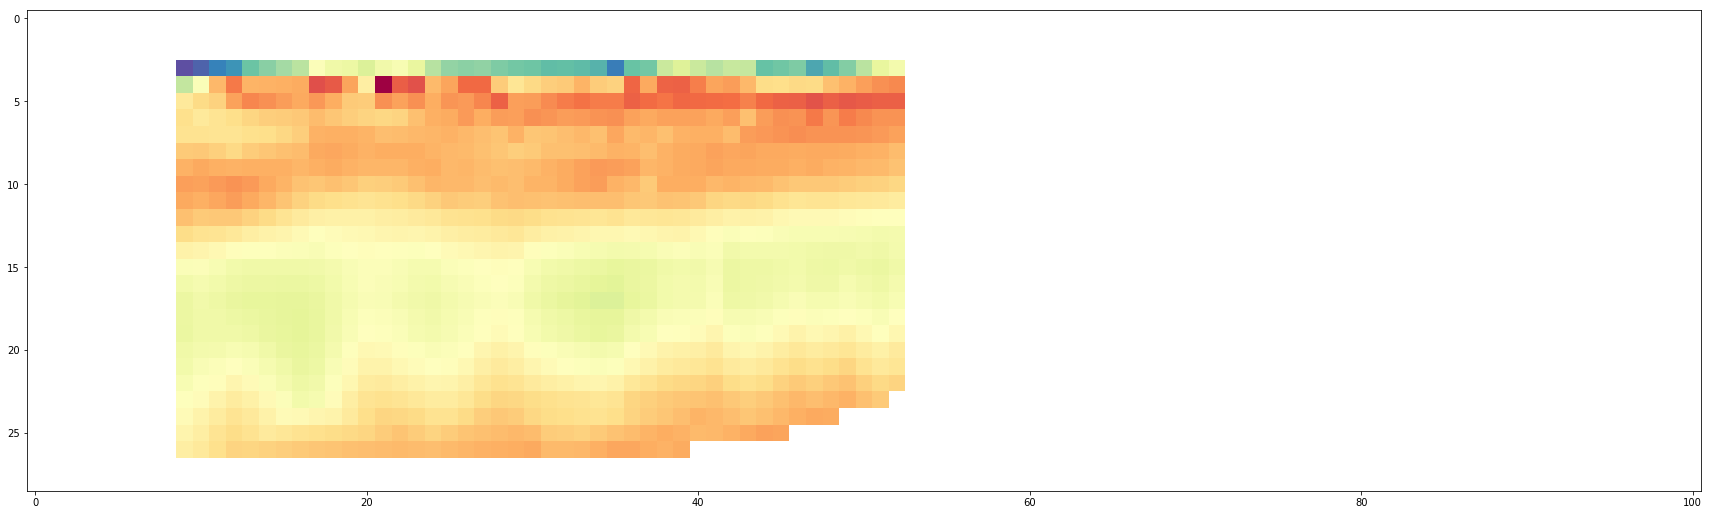

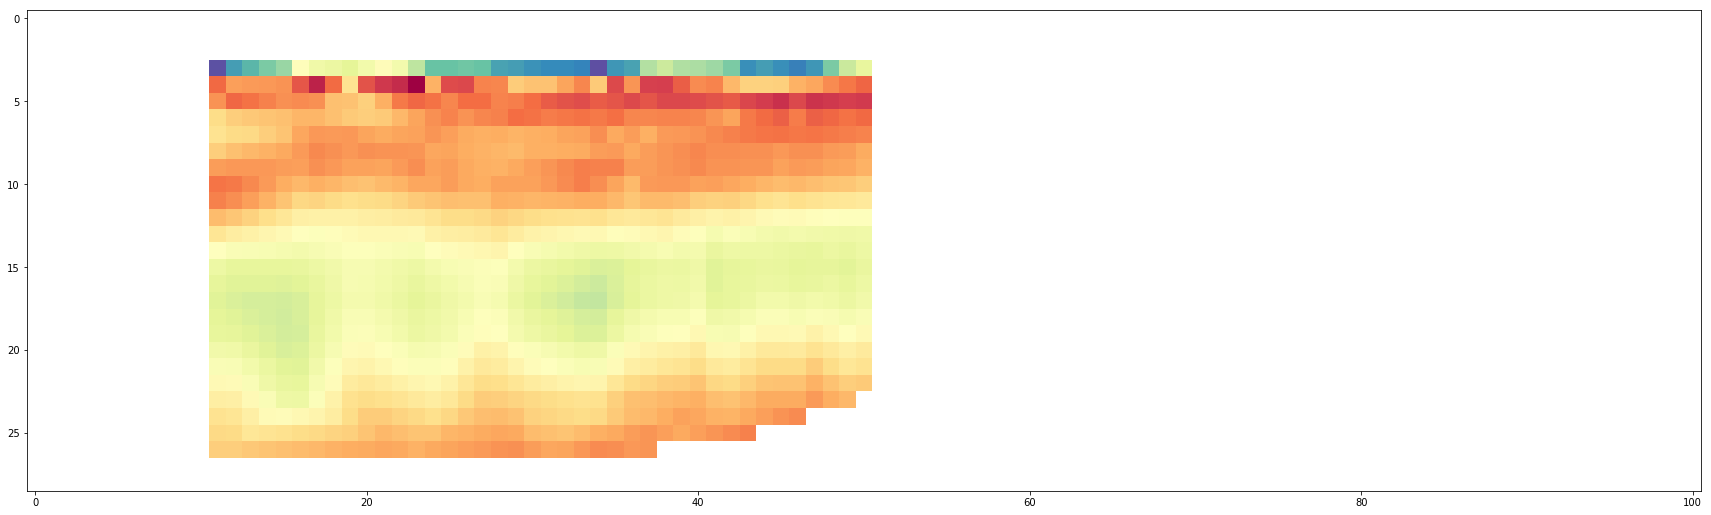

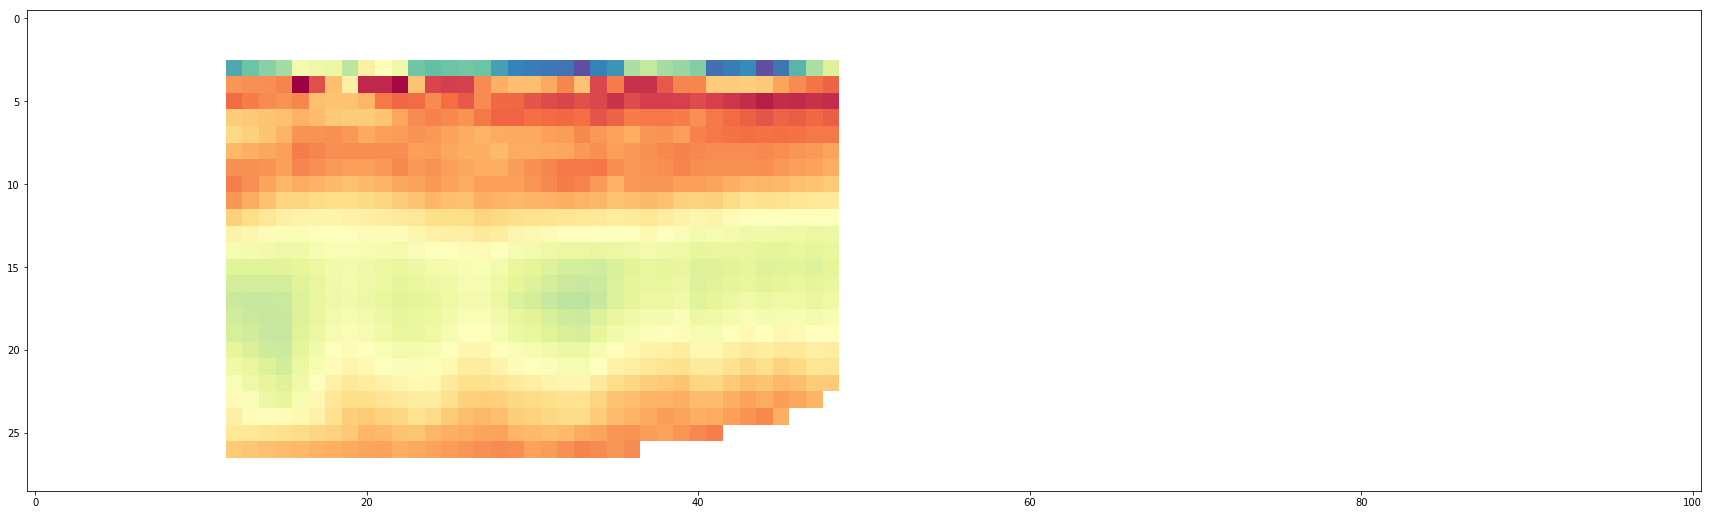

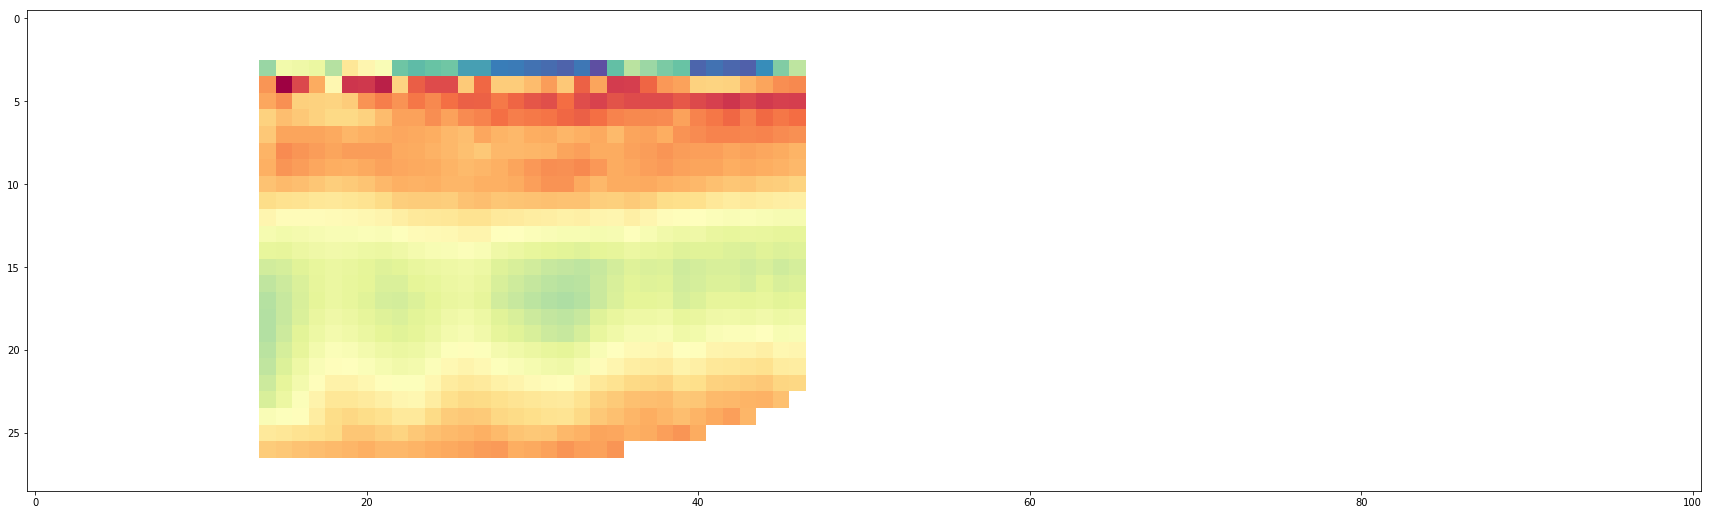

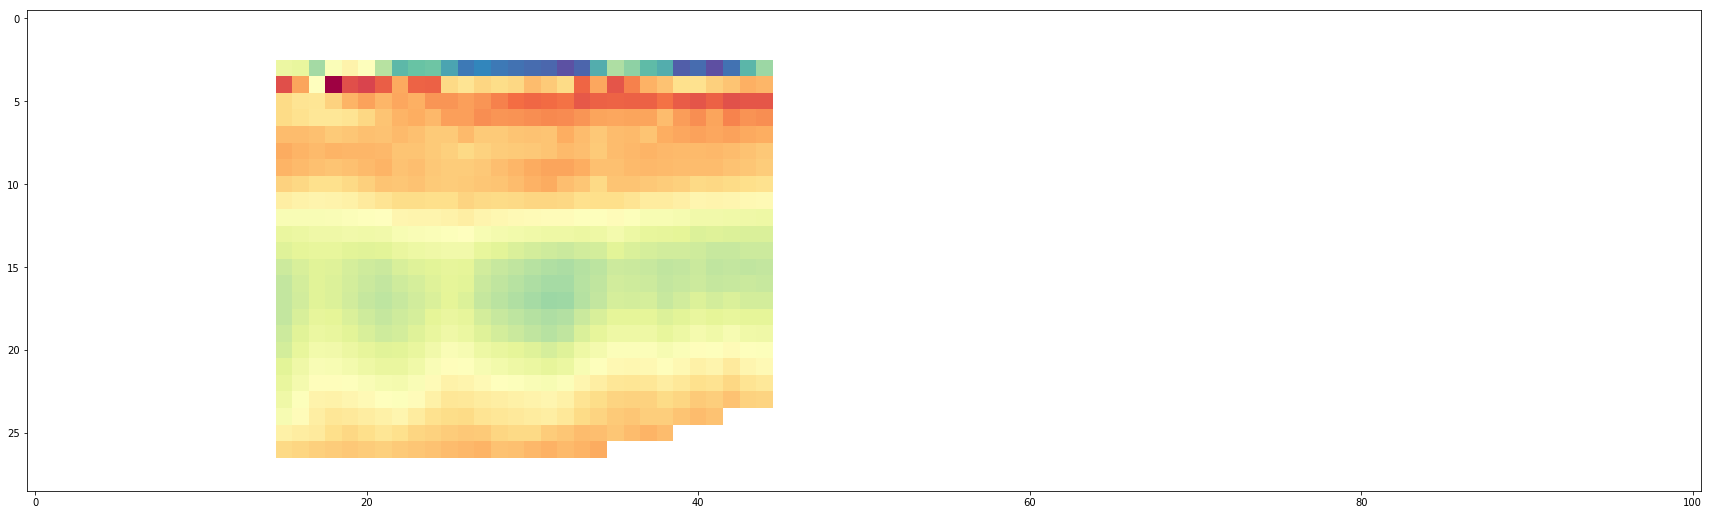

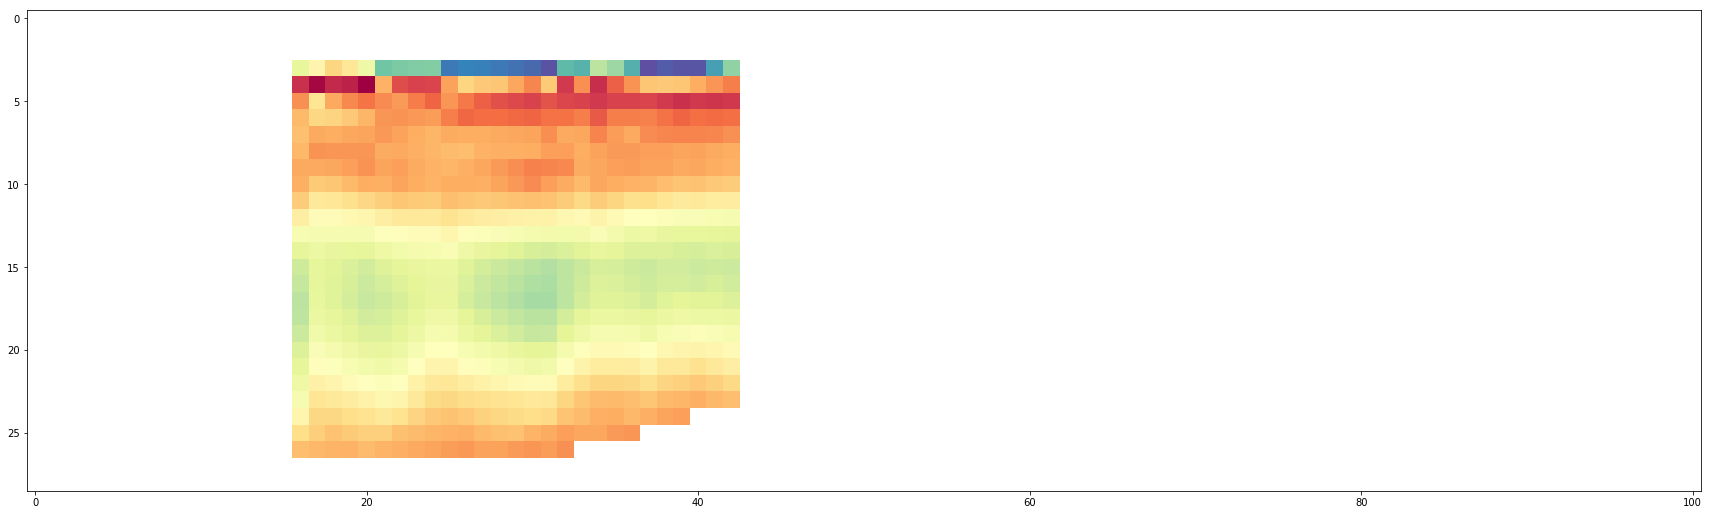

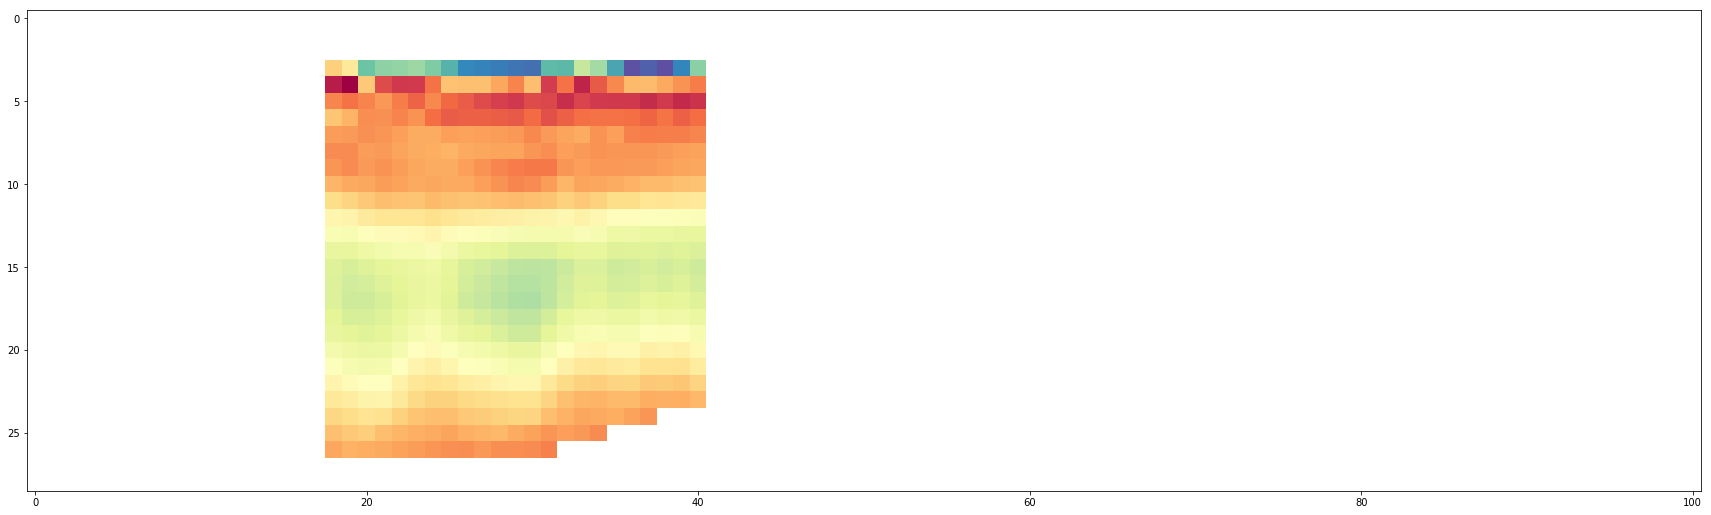

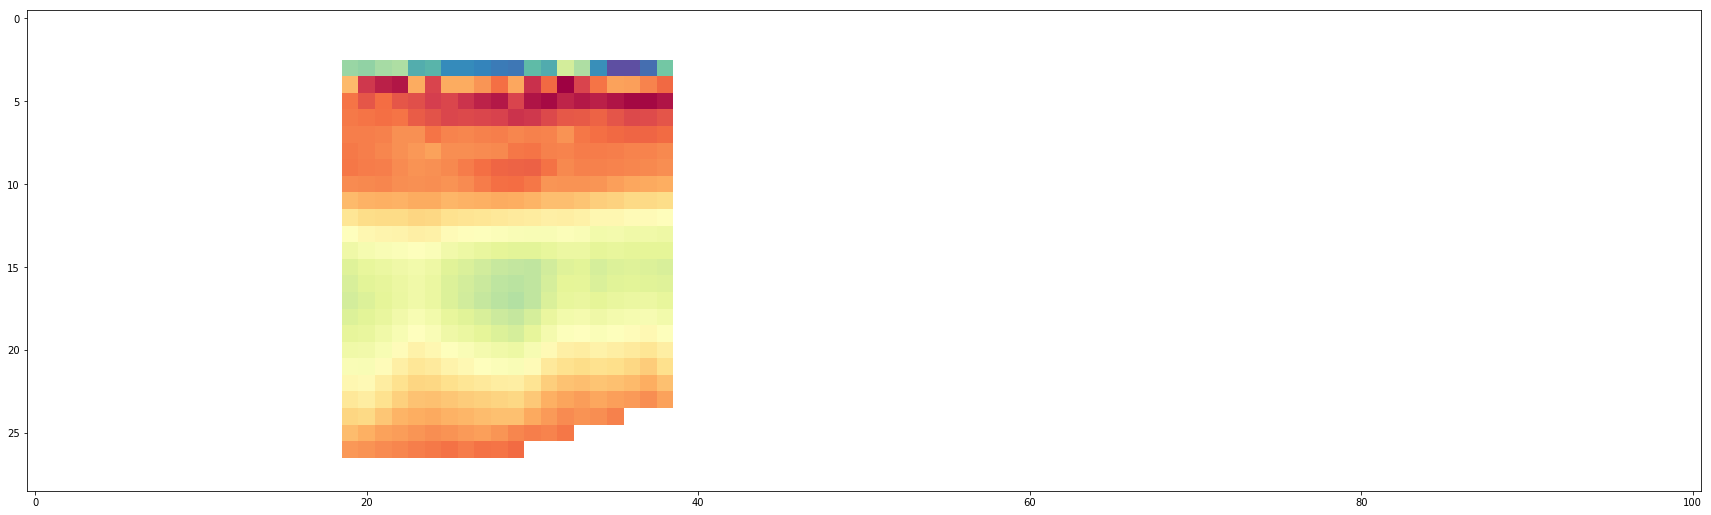

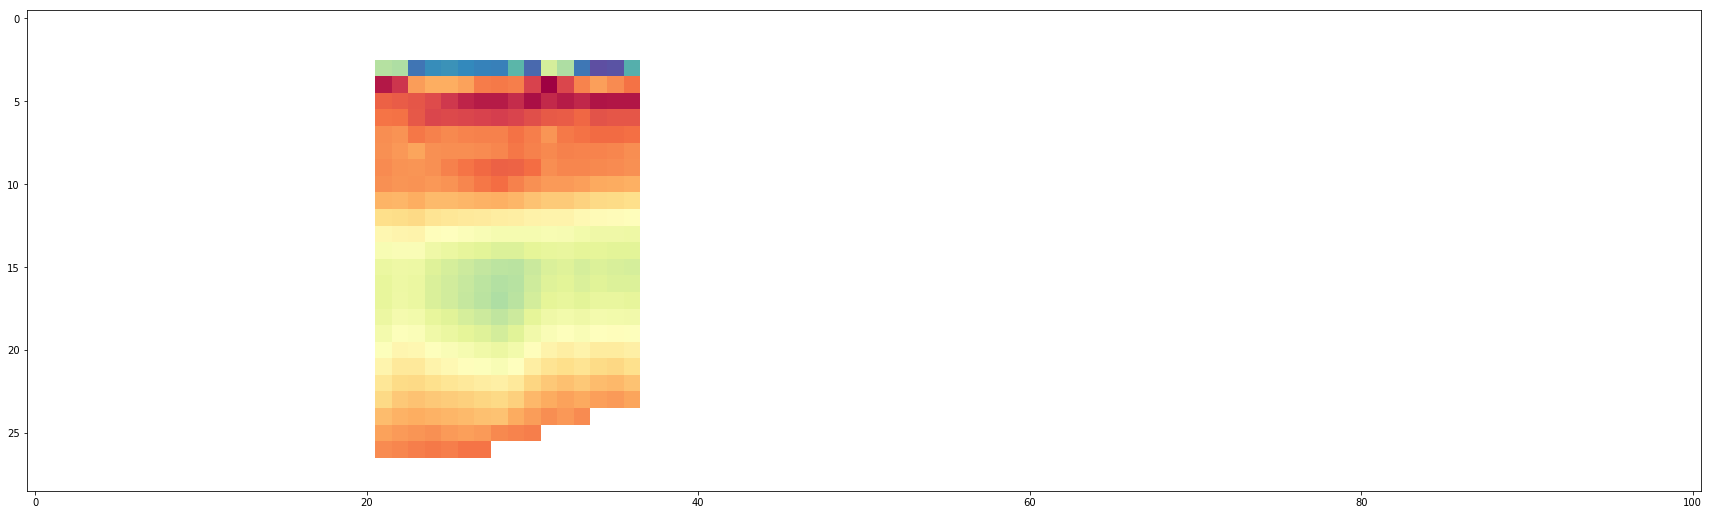

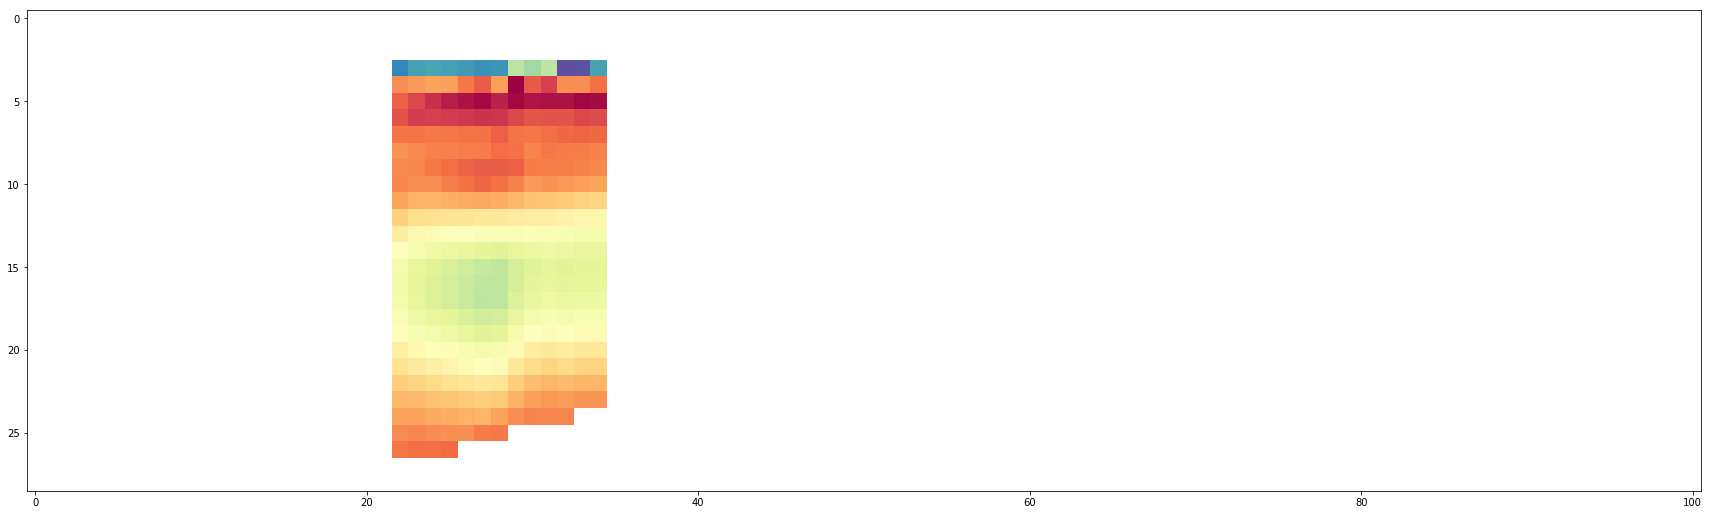

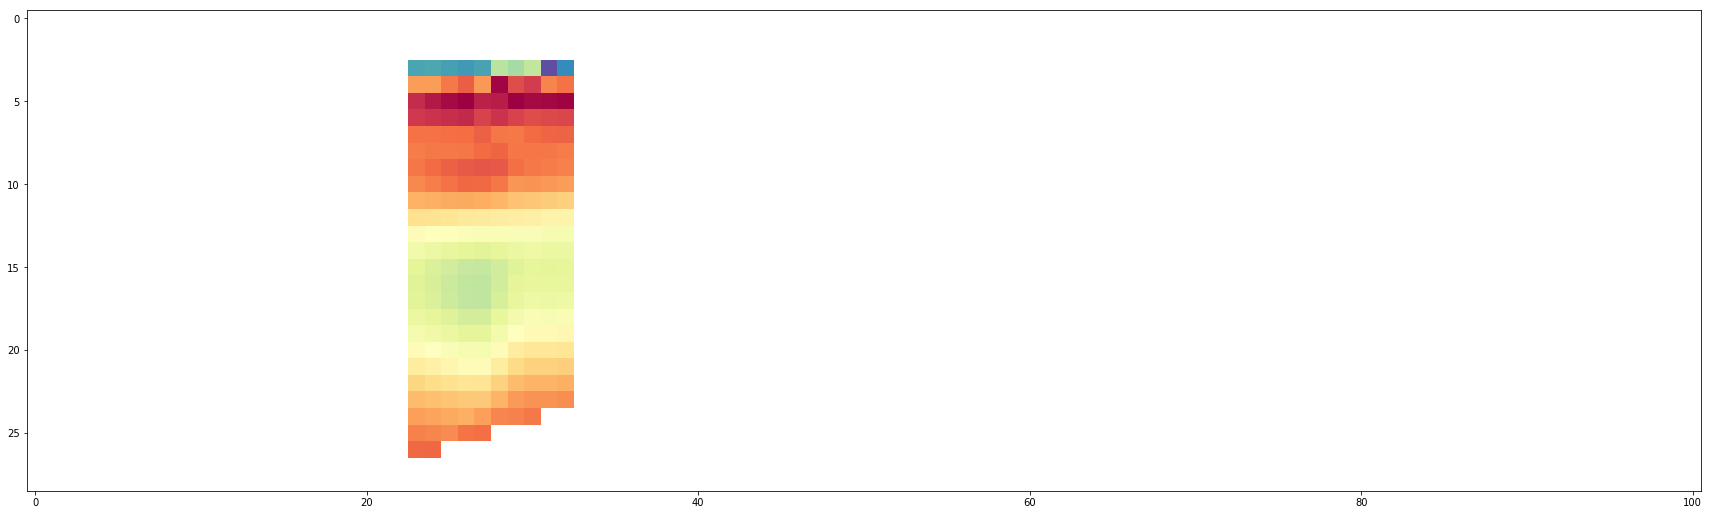

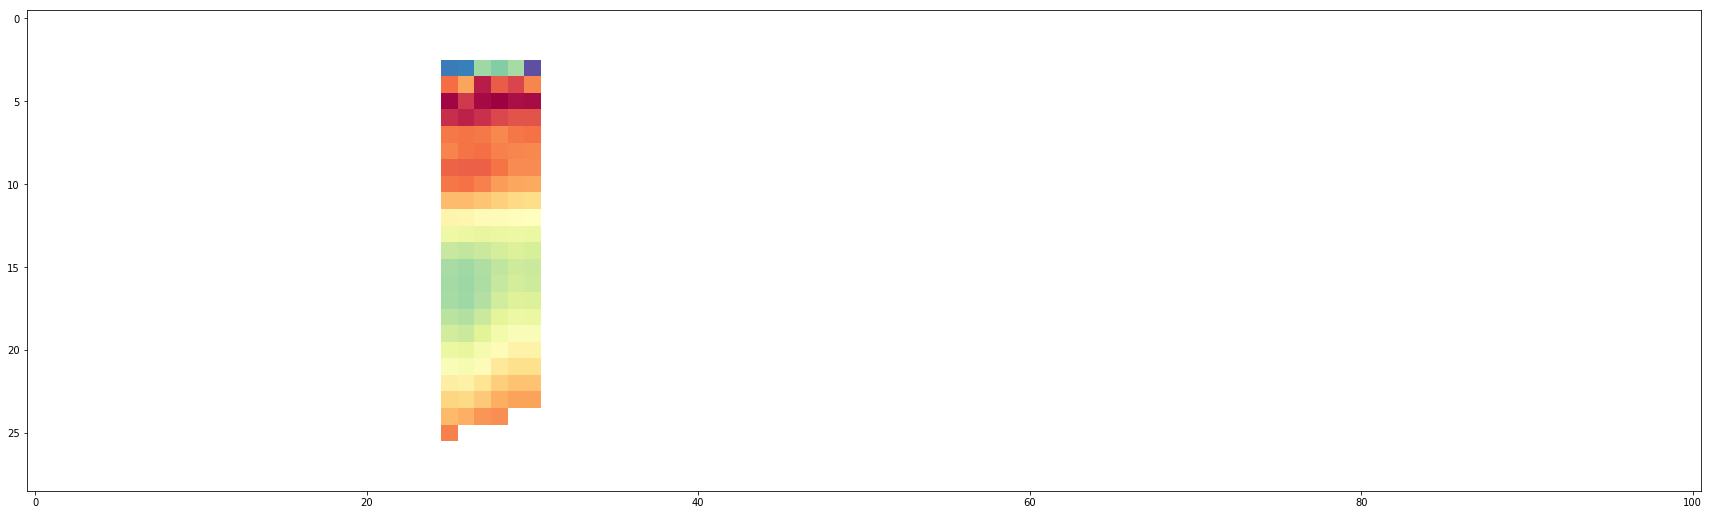

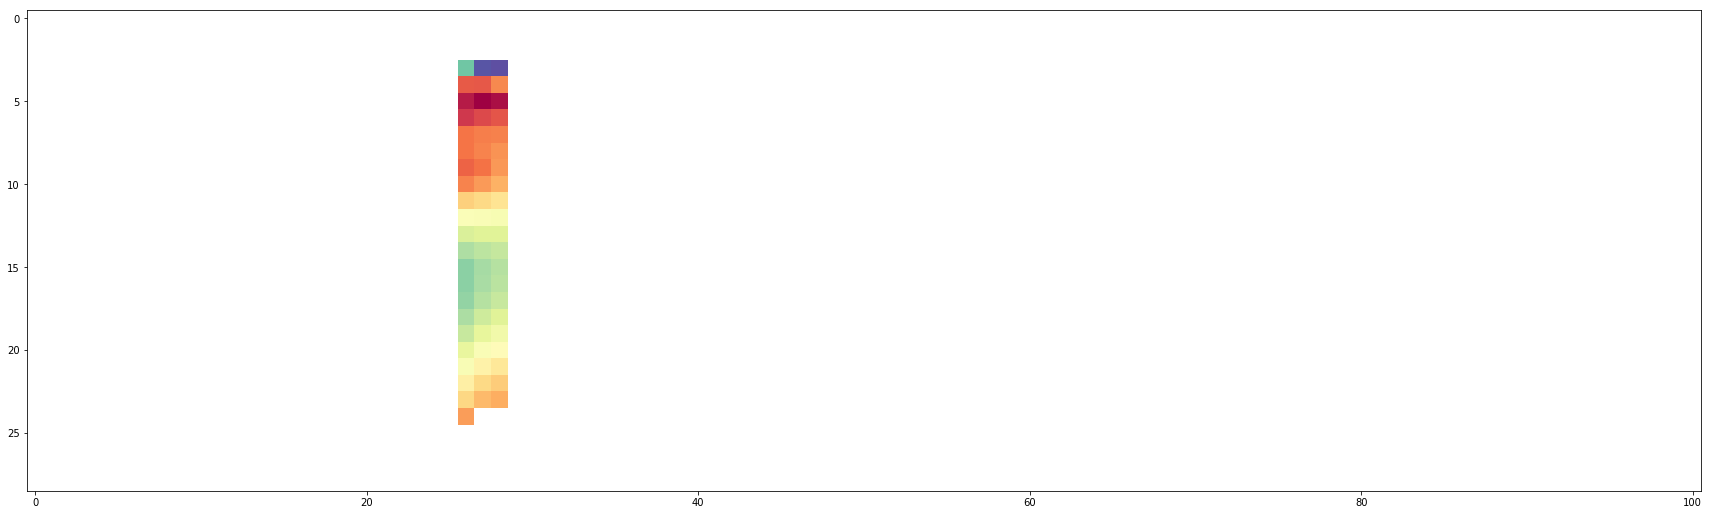

In [19]:
# Plot log colour stretch
for x in x_list:
    plt.figure(figsize=(30,20))    
    plt.imshow(np.log(np.transpose(conductivity_grid[x,:,::-1])), cmap='Spectral_r')